In [1]:
import gaiaxpy as gxp
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sdss

from astroML.sum_of_norms import sum_of_norms, norm
from astroquery.sdss import SDSS as aq_sdss
from scipy.optimize import curve_fit
from tqdm import tqdm

In [2]:
import warnings

warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [3]:
# data-relevant constants
DF = pd.read_csv('../data/main_table.csv')
FIGURE_PATH = '../figures'

GAIA_ID_COLNAME = 'source_id'
SDSS_ID_COLNAME = 'specObjId'
NUM_NORMS = 800

In [4]:
# plot fontsize settings

SMALL_FONT_SIZE = 16
MEDIUM_FONT_SIZE = 20
LARGE_FONT_SIZE = 20

plt.rc('font', size=SMALL_FONT_SIZE)          # default text sizes
plt.rc('axes', titlesize=LARGE_FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_FONT_SIZE)   # fontsize of the figure title

In [5]:
# line properties

PROPS = {
    'sdss_raw': { 'color': '#AAAAAA', 'ls': '--', 'lw': 1, 'label': 'SDSS flux' },
    'gaussian': { 'color': '#FF4444', 'ls': '-', 'lw': 2, 'label': 'Gaussian fit to SDSS flux' },
    'gaia': {'color': '#4444FF', 'ls': '-', 'lw': 2, 'label': 'Gaia flux' }
}

In [6]:
def plot_w_props(x, y, props):
    plt.plot(x, y, color=props['color'], ls=props['ls'], lw=props['lw'], label=props['label'])

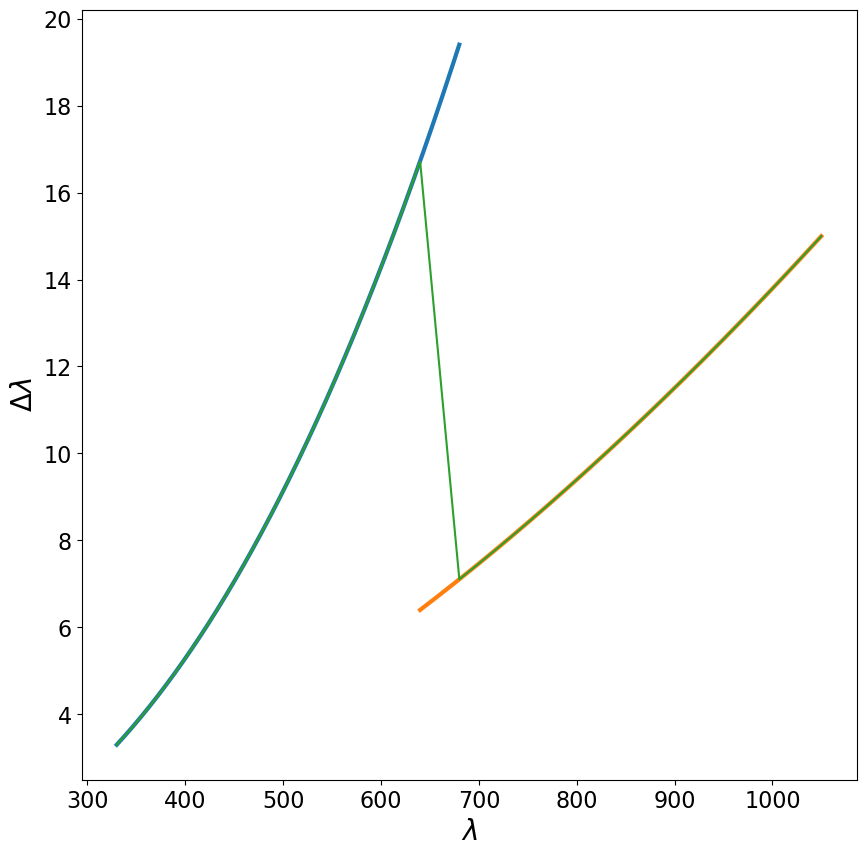

In [7]:
x1 = np.linspace(330, 680, 1000)
y1 = 3.30 * (x1/330)**2.45

x2 = np.linspace(640, 1050, 1000)
y2 = 6.40 * (x2/640)**1.72

plt.figure(figsize=(10, 10))
plt.plot(x1, y1, lw=3)
plt.plot(x2, y2, lw=3)

def deltaXP(wvl):
    y1 = lambda x: 3.30 * (x/330)**2.45
    y2 = lambda x: 6.40 * (x/640)**1.72
    y_mid = lambda x: (y2(680) * (x - 640) + y1(640) * (680 - x))/40
    
    return np.piecewise(wvl, \
                        [wvl < 640, (640 <= wvl) & (wvl <= 680), wvl > 680], \
                        [y1, y_mid, y2])
#     return np.piecewise(wvl, \
#                         [wvl < 660, wvl >= 660], \
#                         [y1, y2])
    
x = np.linspace(330, 1050, 2000)
plt.xlabel('$\\lambda$')
plt.ylabel('$\\Delta\\lambda$')
plt.plot(x, deltaXP(x))

In [8]:
def plot_conv(*, gaia_id=None, sdss_id=None, k=1):
    if gaia_id is None and sdss_id is None:
        print('No ID supplied')
    elif sdss_id is None:    
        try:
            sdss_id = DF.loc[DF[GAIA_ID_COLNAME] == gaia_id][SDSS_ID_COLNAME].to_list()[0]
        except:
            print('Could not find an SDSS ID corresponding to the provided Gaia ID')
    elif gaia_id is None:
        try:
            gaia_id = DF.loc[DF[SDSS_ID_COLNAME] == sdss_id][GAIA_ID_COLNAME].to_list()[0]
        except:
            print('Could not find an Gaia ID corresponding to the provided SDSS ID')
            
    # get sdss data
    try:
        sp = sdss.SpecObj(int(sdss_id))
        data = aq_sdss.get_spectra(plate=sp.plate, mjd=sp.mjd, fiberID=sp.fiberID)
    except:
        print('Could not get SDSS data')
        return
    
    spec_data = data[0][1].data

    sdss_sampling = 10 ** spec_data['loglam'] / 10  # Convert log wavelength to linear and Å to nm
    sdss_flux = spec_data['flux'] * 1e-19 # Convert SDSS units (1e-17 in cgs) to Gaia units (SI)
    
    # const (test)
#     sdss_flux = np.array([np.mean(sdss_flux)] * len(sdss_flux))
    
    # get gaia data and calibrate using sdss sampling
    gaia_flux = gxp.calibrate([gaia_id], sampling=sdss_sampling, truncation=True)[0]['flux'][0]

    weights, fit_rms, locs, widths = sum_of_norms(sdss_sampling, sdss_flux, NUM_NORMS,
                                                 spacing='linear',
                                                 full_output=True)
    
    # convolve sdss with sigma_gaia
#     sigma_conv = np.sqrt(widths**2 + k**2 * deltaXP(locs)**2)  # convolve gaussian sigmas with sigma_gaia
    sigma_conv = np.sqrt(widths**2 + k**2 * deltaXP(sdss_sampling[:, None])**2)  # convolve gaussian sigmas with sigma_gaia
    sdss_flux_fit = (weights * norm(sdss_sampling[:, None], locs, widths)).sum(1)
    sdss_conv = (weights * norm(sdss_sampling[:, None], locs, sigma_conv)).sum(1)
    
    # integrate flux as sanity check
    mask = (sdss_sampling > 390) & (sdss_sampling < 900)
    raw_flux = np.trapz(sdss_flux[mask], sdss_sampling[mask])
    fit_flux = np.trapz(sdss_flux_fit[mask], sdss_sampling[mask])
    conv_flux = np.trapz(sdss_conv[mask], sdss_sampling[mask])
    
    # compute rms error and quotient between sdss convolution and gaia data
    match_rms = np.sqrt(np.mean((sdss_conv[mask] - gaia_flux[mask])**2))
    quot = np.mean(sdss_conv[mask]/gaia_flux[mask])

    # plot the results

    plt.figure(figsize=(20, 10))
    plot_w_props(sdss_sampling, sdss_flux, PROPS['sdss_raw'])
    plot_w_props(sdss_sampling, sdss_conv, PROPS['gaussian'])
    plot_w_props(sdss_sampling, gaia_flux, PROPS['gaia'])

    plt.legend(loc=0)

    plt.text(0.97, 0.8, f"gaussian fit rms error = {fit_rms:.2}", ha='right', va='top', transform=plt.gca().transAxes)
    plt.text(0.97, 0.75, f"k = {k:.2}", ha='right', va='top', transform=plt.gca().transAxes)
    plt.text(0.97, 0.7, f"sdss - gaia rms error = {match_rms:.3}", ha='right', va='top', transform=plt.gca().transAxes)
    plt.text(0.97, 0.65, f"sdss/gaia quotient = {quot:.3}", ha='right', va='top', transform=plt.gca().transAxes)
    plt.text(0.97, 0.6, f"integrated flux (raw) = {raw_flux:.5}", ha='right', va='top', transform=plt.gca().transAxes)
    plt.text(0.97, 0.55, f"integrated flux (fit) = {fit_flux:.5}", ha='right', va='top', transform=plt.gca().transAxes)
    plt.text(0.97, 0.5, f"integrated flux (conv) = {conv_flux:.5}", ha='right', va='top', transform=plt.gca().transAxes)
    plt.title(f"Gaia source_id {gaia_id}\n SDSS specObjId {sdss_id}")
    
    plt.xlabel('$\\lambda$ [nm]')
    plt.ylabel('flux [W m$^{-2}$ nm$^{-1}$]')
    
    plt.xlim(350, 950)
    plt.xticks(np.arange(360, 960, 20))
    
    for axis in [ 'top', 'bottom', 'left', 'right' ]:
        plt.gca().spines[axis].set_linewidth(2)
    
    if not os.path.exists(FIGURE_PATH):
        os.mkdir(FIGURE_PATH)

    plt.savefig(f'{FIGURE_PATH}/gaia_{gaia_id}_sdss_{sdss_id}_k_{int(k*10)}.png')
    plt.show()

In [9]:
def plot_conv_get_gaia(*, gaia_id=None, sdss_id=None):
    if gaia_id is None and sdss_id is None:
        print('No ID supplied')
    elif sdss_id is None:    
        try:
            sdss_id = DF.loc[DF[GAIA_ID_COLNAME] == gaia_id][SDSS_ID_COLNAME].to_list()[0]
        except:
            print('Could not find an SDSS ID corresponding to the provided Gaia ID')
    elif gaia_id is None:
        try:
            gaia_id = DF.loc[DF[SDSS_ID_COLNAME] == sdss_id][GAIA_ID_COLNAME].to_list()[0]
        except:
            print('Could not find an Gaia ID corresponding to the provided SDSS ID')
            
    # get sdss data
    try:
        sp = sdss.SpecObj(int(sdss_id))
        data = aq_sdss.get_spectra(plate=sp.plate, mjd=sp.mjd, fiberID=sp.fiberID)
    except:
        print('Could not get SDSS data')
        return
    
    spec_data = data[0][1].data

    sdss_sampling = 10 ** spec_data['loglam'] / 10  # Convert log wavelength to linear and Å to nm
    sdss_flux = spec_data['flux'] * 1e-19 # Convert SDSS units (1e-17 in cgs) to Gaia units (SI)
    
    # get gaia data and calibrate using sdss sampling
    while True:
        try:
            print('calibrating gaia...')
            gaia_flux = gxp.calibrate([gaia_id], sampling=sdss_sampling, truncation=True)[0]['flux'][0]
            print('done.')
            return gaia_flux
        except Exception as e:
            print(e)
            continue

In [10]:
def plot_conv_k_rms(gaia_flux, *, gaia_id=None, sdss_id=None, k=1):
    if gaia_id is None and sdss_id is None:
        print('No ID supplied')
    elif sdss_id is None:    
        try:
            sdss_id = DF.loc[DF[GAIA_ID_COLNAME] == gaia_id][SDSS_ID_COLNAME].to_list()[0]
        except:
            print('Could not find an SDSS ID corresponding to the provided Gaia ID')
    elif gaia_id is None:
        try:
            gaia_id = DF.loc[DF[SDSS_ID_COLNAME] == sdss_id][GAIA_ID_COLNAME].to_list()[0]
        except:
            print('Could not find an Gaia ID corresponding to the provided SDSS ID')
            
    # get sdss data
    try:
        sp = sdss.SpecObj(int(sdss_id))
        data = aq_sdss.get_spectra(plate=sp.plate, mjd=sp.mjd, fiberID=sp.fiberID)
    except:
        print('Could not get SDSS data')
        return
    
    spec_data = data[0][1].data

    sdss_sampling = 10 ** spec_data['loglam'] / 10  # Convert log wavelength to linear and Å to nm
    sdss_flux = spec_data['flux'] * 1e-19 # Convert SDSS units (1e-17 in cgs) to Gaia units (SI)
    
    weights, fit_rms, locs, widths = sum_of_norms(sdss_sampling, sdss_flux, NUM_NORMS,
                                                 spacing='linear',
                                                 full_output=True)
    
    # convolve sdss with sigma_gaia
    sigma_conv = np.sqrt(widths**2 + k**2 * deltaXP(sdss_sampling[:, None])**2)  # convolve gaussian sigmas with sigma_gaia
    sdss_flux_fit = (weights * norm(sdss_sampling[:, None], locs, widths)).sum(1)
    sdss_conv = (weights * norm(sdss_sampling[:, None], locs, sigma_conv)).sum(1)
    
    # integrate flux as sanity check
    mask = (sdss_sampling > 390) & (sdss_sampling < 900)
    raw_flux = np.trapz(sdss_flux[mask], sdss_sampling[mask])
    fit_flux = np.trapz(sdss_flux_fit[mask], sdss_sampling[mask])
    conv_flux = np.trapz(sdss_conv[mask], sdss_sampling[mask])
    
    # compute rms error and quotient between sdss convolution and gaia data
    match_rms = np.sqrt(np.mean((sdss_conv[mask] - gaia_flux[mask])**2))
    quot = np.median(sdss_conv/gaia_flux)

    return match_rms, quot

In [11]:
ks = {}
qs = {}
for gaia_id in tqdm(DF[:1000][GAIA_ID_COLNAME]):
    min_k, min_rmse, min_q = 100, 100, 100
    gaia_flux = plot_conv_get_gaia(gaia_id=gaia_id)
    if gaia_flux is None:
        continue
            
    for k in np.arange(0.20, 1.800001, 0.02):
        rmse, q = plot_conv_k_rms(gaia_flux, gaia_id=gaia_id, k=k)
        if rmse < min_rmse:
            min_rmse = rmse
            min_k = k
            min_q = q
        else:
            break
        
    ks[gaia_id] = min_k
    qs[gaia_id] = min_q

  0%|                                                                                                                                                                                                                                 | 0/1000 [00:00<?, ?it/s]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  0%|▏                                                                                                                                                                                                                      | 1/1000 [00:13<3:48:41, 13.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  0%|▍                                                                                                                                                                                                                      | 2/1000 [00:20<2:42:22,  9.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  0%|▋                                                                                                                                                                                                                      | 3/1000 [00:28<2:26:24,  8.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  0%|▊                                                                                                                                                                                                                      | 4/1000 [00:35<2:17:19,  8.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  0%|█                                                                                                                                                                                                                      | 5/1000 [00:44<2:19:04,  8.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  1%|█▎                                                                                                                                                                                                                     | 6/1000 [01:16<4:29:52, 16.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  1%|█▌                                                                                                                                                                                                                     | 7/1000 [01:25<3:55:11, 14.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  1%|█▋                                                                                                                                                                                                                     | 8/1000 [01:33<3:19:12, 12.05s/it]

Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  1%|██▎                                                                                                                                                                                                                   | 11/1000 [02:05<3:05:07, 11.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  1%|██▌                                                                                                                                                                                                                   | 12/1000 [02:10<2:43:36,  9.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  1%|██▊                                                                                                                                                                                                                   | 13/1000 [02:47<4:28:19, 16.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  1%|██▉                                                                                                                                                                                                                   | 14/1000 [02:56<3:55:46, 14.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  2%|███▏                                                                                                                                                                                                                  | 15/1000 [03:09<3:51:55, 14.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  2%|███▍                                                                                                                                                                                                                  | 16/1000 [03:14<3:11:11, 11.66s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  2%|███▊                                                                                                                                                                                                                  | 18/1000 [03:19<2:04:11,  7.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  2%|████                                                                                                                                                                                                                  | 19/1000 [03:29<2:14:31,  8.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  2%|████▎                                                                                                                                                                                                                 | 20/1000 [03:39<2:21:29,  8.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  2%|████▍                                                                                                                                                                                                                 | 21/1000 [04:11<4:03:13, 14.91s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  2%|████▋                                                                                                                                                                                                                 | 22/1000 [04:18<3:28:21, 12.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  2%|████▉                                                                                                                                                                                                                 | 23/1000 [04:55<5:16:55, 19.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  2%|█████▏                                                                                                                                                                                                                | 24/1000 [05:03<4:23:29, 16.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  2%|█████▎                                                                                                                                                                                                                | 25/1000 [05:10<3:37:57, 13.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  3%|█████▌                                                                                                                                                                                                                | 26/1000 [05:19<3:20:24, 12.35s/it]

Could not get SDSS data
Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  3%|██████▍                                                                                                                                                                                                               | 30/1000 [05:56<2:48:15, 10.41s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  3%|██████▊                                                                                                                                                                                                               | 32/1000 [06:05<2:17:32,  8.53s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  3%|███████                                                                                                                                                                                                               | 33/1000 [06:11<2:09:04,  8.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  3%|███████▎                                                                                                                                                                                                              | 34/1000 [06:19<2:09:31,  8.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  4%|███████▍                                                                                                                                                                                                              | 35/1000 [06:28<2:12:31,  8.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  4%|███████▋                                                                                                                                                                                                              | 36/1000 [06:56<3:29:45, 13.06s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  4%|████████▏                                                                                                                                                                                                             | 38/1000 [07:07<2:38:39,  9.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  4%|████████▎                                                                                                                                                                                                             | 39/1000 [07:16<2:36:16,  9.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  4%|████████▌                                                                                                                                                                                                             | 40/1000 [07:38<3:26:19, 12.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  4%|████████▊                                                                                                                                                                                                             | 41/1000 [07:50<3:21:24, 12.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  4%|████████▉                                                                                                                                                                                                             | 42/1000 [08:01<3:12:28, 12.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  4%|█████████▏                                                                                                                                                                                                            | 43/1000 [08:10<3:00:14, 11.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  4%|█████████▍                                                                                                                                                                                                            | 44/1000 [08:19<2:48:52, 10.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  4%|█████████▋                                                                                                                                                                                                            | 45/1000 [08:31<2:53:58, 10.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  5%|█████████▊                                                                                                                                                                                                            | 46/1000 [08:39<2:42:40, 10.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  5%|██████████                                                                                                                                                                                                            | 47/1000 [08:49<2:38:48, 10.00s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  5%|██████████▍                                                                                                                                                                                                           | 49/1000 [08:58<2:00:53,  7.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  5%|██████████▋                                                                                                                                                                                                           | 50/1000 [09:06<1:59:45,  7.56s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  5%|██████████▉                                                                                                                                                                                                           | 51/1000 [09:17<2:13:39,  8.45s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  5%|███████████▎                                                                                                                                                                                                          | 53/1000 [09:26<1:47:58,  6.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  5%|███████████▌                                                                                                                                                                                                          | 54/1000 [09:34<1:54:07,  7.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  6%|███████████▊                                                                                                                                                                                                          | 55/1000 [09:41<1:51:01,  7.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  6%|███████████▉                                                                                                                                                                                                          | 56/1000 [09:53<2:13:27,  8.48s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  6%|████████████▏                                                                                                                                                                                                         | 57/1000 [10:04<2:20:35,  8.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  6%|████████████▍                                                                                                                                                                                                         | 58/1000 [10:20<2:52:12, 10.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  6%|████████████▋                                                                                                                                                                                                         | 59/1000 [10:26<2:32:57,  9.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  6%|████████████▊                                                                                                                                                                                                         | 60/1000 [10:36<2:32:13,  9.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  6%|█████████████                                                                                                                                                                                                         | 61/1000 [10:43<2:18:31,  8.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  6%|█████████████▎                                                                                                                                                                                                        | 62/1000 [10:52<2:21:16,  9.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  6%|█████████████▍                                                                                                                                                                                                        | 63/1000 [11:05<2:38:20, 10.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  6%|█████████████▋                                                                                                                                                                                                        | 64/1000 [11:12<2:23:41,  9.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  6%|█████████████▉                                                                                                                                                                                                        | 65/1000 [11:23<2:33:31,  9.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  7%|██████████████                                                                                                                                                                                                        | 66/1000 [11:33<2:34:04,  9.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  7%|██████████████▎                                                                                                                                                                                                       | 67/1000 [11:42<2:25:53,  9.38s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  7%|██████████████▊                                                                                                                                                                                                       | 69/1000 [11:52<1:56:22,  7.50s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  7%|██████████████▉                                                                                                                                                                                                       | 70/1000 [12:01<2:01:34,  7.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  7%|███████████████▏                                                                                                                                                                                                      | 71/1000 [12:11<2:10:09,  8.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  7%|███████████████▍                                                                                                                                                                                                      | 72/1000 [12:21<2:17:33,  8.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  7%|███████████████▌                                                                                                                                                                                                      | 73/1000 [12:33<2:29:36,  9.68s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  8%|████████████████                                                                                                                                                                                                      | 75/1000 [12:43<1:56:28,  7.56s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  8%|████████████████▎                                                                                                                                                                                                     | 76/1000 [12:51<2:00:01,  7.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  8%|████████████████▍                                                                                                                                                                                                     | 77/1000 [13:02<2:12:25,  8.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  8%|████████████████▋                                                                                                                                                                                                     | 78/1000 [13:17<2:35:41, 10.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  8%|████████████████▉                                                                                                                                                                                                     | 79/1000 [13:26<2:32:01,  9.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  8%|█████████████████                                                                                                                                                                                                     | 80/1000 [13:32<2:16:20,  8.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  8%|█████████████████▎                                                                                                                                                                                                    | 81/1000 [13:41<2:14:25,  8.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  8%|█████████████████▌                                                                                                                                                                                                    | 82/1000 [13:52<2:24:18,  9.43s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  8%|█████████████████▊                                                                                                                                                                                                    | 83/1000 [14:02<2:25:56,  9.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  8%|█████████████████▉                                                                                                                                                                                                    | 84/1000 [14:13<2:32:38, 10.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  8%|██████████████████▏                                                                                                                                                                                                   | 85/1000 [14:22<2:28:32,  9.74s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  9%|██████████████████▌                                                                                                                                                                                                   | 87/1000 [14:33<1:58:52,  7.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  9%|██████████████████▊                                                                                                                                                                                                   | 88/1000 [14:41<1:58:34,  7.80s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  9%|███████████████████                                                                                                                                                                                                   | 89/1000 [14:49<2:01:08,  7.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  9%|███████████████████▎                                                                                                                                                                                                  | 90/1000 [14:58<2:05:54,  8.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  9%|███████████████████▍                                                                                                                                                                                                  | 91/1000 [15:10<2:21:50,  9.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  9%|███████████████████▋                                                                                                                                                                                                  | 92/1000 [15:20<2:23:06,  9.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  9%|███████████████████▉                                                                                                                                                                                                  | 93/1000 [15:31<2:29:28,  9.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  9%|████████████████████                                                                                                                                                                                                  | 94/1000 [15:43<2:36:23, 10.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 10%|████████████████████▎                                                                                                                                                                                                 | 95/1000 [15:55<2:44:10, 10.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 10%|████████████████████▌                                                                                                                                                                                                 | 96/1000 [16:03<2:31:52, 10.08s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 10%|████████████████████▉                                                                                                                                                                                                 | 98/1000 [16:13<1:57:45,  7.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 10%|█████████████████████▏                                                                                                                                                                                                | 99/1000 [16:24<2:08:00,  8.52s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 10%|█████████████████████▎                                                                                                                                                                                               | 100/1000 [16:33<2:10:25,  8.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 10%|█████████████████████▌                                                                                                                                                                                               | 101/1000 [16:46<2:27:03,  9.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 10%|█████████████████████▋                                                                                                                                                                                               | 102/1000 [16:57<2:30:18, 10.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 10%|█████████████████████▉                                                                                                                                                                                               | 103/1000 [17:10<2:45:20, 11.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 10%|██████████████████████▏                                                                                                                                                                                              | 104/1000 [17:43<4:17:30, 17.24s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 11%|██████████████████████▌                                                                                                                                                                                              | 106/1000 [17:54<2:59:07, 12.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 11%|██████████████████████▊                                                                                                                                                                                              | 107/1000 [18:05<2:54:44, 11.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 11%|███████████████████████                                                                                                                                                                                              | 108/1000 [18:15<2:48:35, 11.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 11%|███████████████████████▏                                                                                                                                                                                             | 109/1000 [18:24<2:38:15, 10.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 11%|███████████████████████▍                                                                                                                                                                                             | 110/1000 [18:29<2:13:59,  9.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 11%|███████████████████████▋                                                                                                                                                                                             | 111/1000 [18:38<2:13:02,  8.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 11%|███████████████████████▊                                                                                                                                                                                             | 112/1000 [18:48<2:18:19,  9.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 11%|████████████████████████                                                                                                                                                                                             | 113/1000 [19:19<3:53:49, 15.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 11%|████████████████████████▎                                                                                                                                                                                            | 114/1000 [19:38<4:07:44, 16.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 12%|████████████████████████▍                                                                                                                                                                                            | 115/1000 [19:47<3:30:18, 14.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 12%|████████████████████████▋                                                                                                                                                                                            | 116/1000 [20:00<3:25:00, 13.92s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 12%|████████████████████████▉                                                                                                                                                                                            | 117/1000 [20:08<2:59:57, 12.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 12%|█████████████████████████▏                                                                                                                                                                                           | 118/1000 [20:17<2:47:49, 11.42s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 12%|█████████████████████████▎                                                                                                                                                                                           | 119/1000 [20:50<4:19:45, 17.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 12%|█████████████████████████▌                                                                                                                                                                                           | 120/1000 [21:00<3:44:32, 15.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 12%|█████████████████████████▊                                                                                                                                                                                           | 121/1000 [21:05<2:59:55, 12.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 12%|█████████████████████████▉                                                                                                                                                                                           | 122/1000 [21:14<2:46:35, 11.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 12%|██████████████████████████▏                                                                                                                                                                                          | 123/1000 [21:47<4:18:37, 17.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 12%|██████████████████████████▍                                                                                                                                                                                          | 124/1000 [22:19<5:24:13, 22.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 12%|██████████████████████████▋                                                                                                                                                                                          | 125/1000 [22:25<4:12:43, 17.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 13%|██████████████████████████▊                                                                                                                                                                                          | 126/1000 [22:35<3:38:49, 15.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 13%|███████████████████████████                                                                                                                                                                                          | 127/1000 [22:45<3:18:46, 13.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 13%|███████████████████████████▎                                                                                                                                                                                         | 128/1000 [22:52<2:48:46, 11.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 13%|███████████████████████████▍                                                                                                                                                                                         | 129/1000 [23:24<4:18:41, 17.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 13%|███████████████████████████▋                                                                                                                                                                                         | 130/1000 [23:35<3:45:41, 15.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 13%|███████████████████████████▉                                                                                                                                                                                         | 131/1000 [23:47<3:30:46, 14.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 13%|████████████████████████████                                                                                                                                                                                         | 132/1000 [23:55<3:03:17, 12.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 13%|████████████████████████████▎                                                                                                                                                                                        | 133/1000 [24:05<2:51:46, 11.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 13%|████████████████████████████▌                                                                                                                                                                                        | 134/1000 [24:19<2:58:25, 12.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 14%|████████████████████████████▊                                                                                                                                                                                        | 135/1000 [24:26<2:36:43, 10.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 14%|████████████████████████████▉                                                                                                                                                                                        | 136/1000 [25:06<4:41:08, 19.52s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 14%|█████████████████████████████▏                                                                                                                                                                                       | 137/1000 [25:16<3:58:57, 16.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 14%|█████████████████████████████▍                                                                                                                                                                                       | 138/1000 [25:48<5:07:11, 21.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 14%|█████████████████████████████▌                                                                                                                                                                                       | 139/1000 [26:21<5:54:56, 24.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 14%|█████████████████████████████▊                                                                                                                                                                                       | 140/1000 [26:33<4:58:42, 20.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 14%|██████████████████████████████                                                                                                                                                                                       | 141/1000 [26:43<4:15:04, 17.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 14%|██████████████████████████████▏                                                                                                                                                                                      | 142/1000 [26:55<3:48:07, 15.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 14%|██████████████████████████████▍                                                                                                                                                                                      | 143/1000 [27:06<3:27:11, 14.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 14%|██████████████████████████████▋                                                                                                                                                                                      | 144/1000 [27:14<3:00:19, 12.64s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 14%|██████████████████████████████▉                                                                                                                                                                                      | 145/1000 [27:27<3:00:29, 12.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 15%|███████████████████████████████                                                                                                                                                                                      | 146/1000 [28:04<4:43:51, 19.94s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 15%|███████████████████████████████▌                                                                                                                                                                                     | 148/1000 [28:16<3:12:02, 13.52s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 15%|███████████████████████████████▋                                                                                                                                                                                     | 149/1000 [28:27<3:01:55, 12.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 15%|███████████████████████████████▉                                                                                                                                                                                     | 150/1000 [28:59<4:12:54, 17.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 15%|████████████████████████████████▏                                                                                                                                                                                    | 151/1000 [29:10<3:46:05, 15.98s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 15%|████████████████████████████████▌                                                                                                                                                                                    | 153/1000 [29:19<2:34:08, 10.92s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 15%|████████████████████████████████▊                                                                                                                                                                                    | 154/1000 [29:26<2:23:27, 10.17s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 16%|█████████████████████████████████▏                                                                                                                                                                                   | 156/1000 [29:38<1:58:21,  8.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 16%|█████████████████████████████████▍                                                                                                                                                                                   | 157/1000 [29:51<2:11:37,  9.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 16%|█████████████████████████████████▋                                                                                                                                                                                   | 158/1000 [30:00<2:10:03,  9.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 16%|█████████████████████████████████▊                                                                                                                                                                                   | 159/1000 [30:07<2:03:34,  8.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 16%|██████████████████████████████████                                                                                                                                                                                   | 160/1000 [30:14<1:57:33,  8.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 16%|██████████████████████████████████▎                                                                                                                                                                                  | 161/1000 [30:28<2:17:44,  9.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 16%|██████████████████████████████████▌                                                                                                                                                                                  | 162/1000 [30:44<2:40:31, 11.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 16%|██████████████████████████████████▋                                                                                                                                                                                  | 163/1000 [30:55<2:38:32, 11.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 16%|██████████████████████████████████▉                                                                                                                                                                                  | 164/1000 [31:05<2:35:42, 11.18s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 16%|███████████████████████████████████▏                                                                                                                                                                                 | 165/1000 [31:16<2:35:05, 11.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 17%|███████████████████████████████████▎                                                                                                                                                                                 | 166/1000 [31:26<2:26:47, 10.56s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 17%|███████████████████████████████████▌                                                                                                                                                                                 | 167/1000 [32:04<4:21:54, 18.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 17%|███████████████████████████████████▊                                                                                                                                                                                 | 168/1000 [32:15<3:46:50, 16.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 17%|███████████████████████████████████▉                                                                                                                                                                                 | 169/1000 [32:30<3:42:14, 16.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 17%|████████████████████████████████████▏                                                                                                                                                                                | 170/1000 [32:44<3:32:46, 15.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 17%|████████████████████████████████████▍                                                                                                                                                                                | 171/1000 [32:54<3:10:29, 13.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 17%|████████████████████████████████████▋                                                                                                                                                                                | 172/1000 [33:08<3:13:24, 14.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 17%|████████████████████████████████████▊                                                                                                                                                                                | 173/1000 [33:24<3:21:10, 14.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 17%|█████████████████████████████████████                                                                                                                                                                                | 174/1000 [33:36<3:07:20, 13.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 18%|█████████████████████████████████████▎                                                                                                                                                                               | 175/1000 [33:48<3:02:40, 13.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 18%|█████████████████████████████████████▍                                                                                                                                                                               | 176/1000 [34:01<3:01:25, 13.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 18%|█████████████████████████████████████▋                                                                                                                                                                               | 177/1000 [34:15<3:02:43, 13.32s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 18%|█████████████████████████████████████▉                                                                                                                                                                               | 178/1000 [34:24<2:47:30, 12.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 18%|██████████████████████████████████████▏                                                                                                                                                                              | 179/1000 [35:07<4:52:44, 21.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 18%|██████████████████████████████████████▎                                                                                                                                                                              | 180/1000 [35:24<4:33:07, 19.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 18%|██████████████████████████████████████▌                                                                                                                                                                              | 181/1000 [35:43<4:27:19, 19.58s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 18%|██████████████████████████████████████▊                                                                                                                                                                              | 182/1000 [35:48<3:27:57, 15.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 18%|██████████████████████████████████████▉                                                                                                                                                                              | 183/1000 [35:57<3:02:32, 13.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 18%|███████████████████████████████████████▏                                                                                                                                                                             | 184/1000 [36:08<2:51:32, 12.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 18%|███████████████████████████████████████▍                                                                                                                                                                             | 185/1000 [36:22<2:57:09, 13.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 19%|███████████████████████████████████████▌                                                                                                                                                                             | 186/1000 [36:36<3:04:17, 13.58s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 19%|███████████████████████████████████████▊                                                                                                                                                                             | 187/1000 [36:50<3:03:25, 13.54s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 19%|████████████████████████████████████████                                                                                                                                                                             | 188/1000 [37:02<2:58:19, 13.18s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 19%|████████████████████████████████████████▎                                                                                                                                                                            | 189/1000 [37:14<2:52:00, 12.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 19%|████████████████████████████████████████▍                                                                                                                                                                            | 190/1000 [37:27<2:53:41, 12.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 19%|████████████████████████████████████████▋                                                                                                                                                                            | 191/1000 [37:39<2:48:03, 12.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 19%|████████████████████████████████████████▉                                                                                                                                                                            | 192/1000 [37:47<2:29:44, 11.12s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 19%|█████████████████████████████████████████                                                                                                                                                                            | 193/1000 [37:55<2:19:28, 10.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 19%|█████████████████████████████████████████▎                                                                                                                                                                           | 194/1000 [38:32<4:04:22, 18.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 20%|█████████████████████████████████████████▌                                                                                                                                                                           | 195/1000 [38:41<3:27:11, 15.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 20%|█████████████████████████████████████████▋                                                                                                                                                                           | 196/1000 [38:51<3:04:15, 13.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 20%|█████████████████████████████████████████▉                                                                                                                                                                           | 197/1000 [38:57<2:33:40, 11.48s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 20%|██████████████████████████████████████████▏                                                                                                                                                                          | 198/1000 [39:10<2:41:35, 12.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 20%|██████████████████████████████████████████▍                                                                                                                                                                          | 199/1000 [39:23<2:46:06, 12.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 20%|██████████████████████████████████████████▌                                                                                                                                                                          | 200/1000 [39:33<2:35:34, 11.67s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 20%|███████████████████████████████████████████                                                                                                                                                                          | 202/1000 [39:59<2:42:09, 12.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 20%|███████████████████████████████████████████▏                                                                                                                                                                         | 203/1000 [40:07<2:27:17, 11.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 20%|███████████████████████████████████████████▍                                                                                                                                                                         | 204/1000 [40:47<4:06:57, 18.62s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 20%|███████████████████████████████████████████▋                                                                                                                                                                         | 205/1000 [40:56<3:33:17, 16.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 21%|███████████████████████████████████████████▉                                                                                                                                                                         | 206/1000 [41:01<2:53:20, 13.10s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 21%|████████████████████████████████████████████▎                                                                                                                                                                        | 208/1000 [41:13<2:11:35,  9.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 21%|████████████████████████████████████████████▌                                                                                                                                                                        | 209/1000 [41:23<2:11:40,  9.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 21%|████████████████████████████████████████████▋                                                                                                                                                                        | 210/1000 [41:33<2:10:53,  9.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 21%|████████████████████████████████████████████▉                                                                                                                                                                        | 211/1000 [41:42<2:05:58,  9.58s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 21%|█████████████████████████████████████████████▏                                                                                                                                                                       | 212/1000 [41:54<2:13:29, 10.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 21%|█████████████████████████████████████████████▎                                                                                                                                                                       | 213/1000 [42:13<2:48:20, 12.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 21%|█████████████████████████████████████████████▌                                                                                                                                                                       | 214/1000 [42:25<2:45:44, 12.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 22%|█████████████████████████████████████████████▊                                                                                                                                                                       | 215/1000 [42:33<2:25:56, 11.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 22%|██████████████████████████████████████████████                                                                                                                                                                       | 216/1000 [42:43<2:21:44, 10.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 22%|██████████████████████████████████████████████▏                                                                                                                                                                      | 217/1000 [42:53<2:19:19, 10.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 22%|██████████████████████████████████████████████▍                                                                                                                                                                      | 218/1000 [43:06<2:27:55, 11.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 22%|██████████████████████████████████████████████▋                                                                                                                                                                      | 219/1000 [43:14<2:15:56, 10.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 22%|██████████████████████████████████████████████▊                                                                                                                                                                      | 220/1000 [43:23<2:08:01,  9.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 22%|███████████████████████████████████████████████                                                                                                                                                                      | 221/1000 [43:34<2:12:57, 10.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 22%|███████████████████████████████████████████████▎                                                                                                                                                                     | 222/1000 [43:46<2:17:41, 10.62s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 22%|███████████████████████████████████████████████▍                                                                                                                                                                     | 223/1000 [43:56<2:15:26, 10.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 22%|███████████████████████████████████████████████▋                                                                                                                                                                     | 224/1000 [44:06<2:14:15, 10.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 22%|███████████████████████████████████████████████▉                                                                                                                                                                     | 225/1000 [44:42<3:52:17, 17.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 23%|████████████████████████████████████████████████▏                                                                                                                                                                    | 226/1000 [44:49<3:10:54, 14.80s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 23%|████████████████████████████████████████████████▎                                                                                                                                                                    | 227/1000 [44:56<2:42:28, 12.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 23%|████████████████████████████████████████████████▌                                                                                                                                                                    | 228/1000 [45:06<2:31:53, 11.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 23%|████████████████████████████████████████████████▊                                                                                                                                                                    | 229/1000 [45:19<2:33:21, 11.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 23%|████████████████████████████████████████████████▉                                                                                                                                                                    | 230/1000 [45:31<2:36:29, 12.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 23%|█████████████████████████████████████████████████▏                                                                                                                                                                   | 231/1000 [45:39<2:17:01, 10.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 23%|█████████████████████████████████████████████████▍                                                                                                                                                                   | 232/1000 [45:51<2:22:30, 11.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 23%|█████████████████████████████████████████████████▋                                                                                                                                                                   | 233/1000 [46:05<2:33:14, 11.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 23%|█████████████████████████████████████████████████▊                                                                                                                                                                   | 234/1000 [46:17<2:35:34, 12.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 24%|██████████████████████████████████████████████████                                                                                                                                                                   | 235/1000 [46:30<2:38:02, 12.40s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 24%|██████████████████████████████████████████████████▍                                                                                                                                                                  | 237/1000 [46:40<1:52:59,  8.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 24%|██████████████████████████████████████████████████▋                                                                                                                                                                  | 238/1000 [46:50<1:57:59,  9.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 24%|██████████████████████████████████████████████████▉                                                                                                                                                                  | 239/1000 [46:59<1:55:58,  9.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 24%|███████████████████████████████████████████████████                                                                                                                                                                  | 240/1000 [47:32<3:16:42, 15.53s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 24%|███████████████████████████████████████████████████▎                                                                                                                                                                 | 241/1000 [47:40<2:51:36, 13.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 24%|███████████████████████████████████████████████████▌                                                                                                                                                                 | 242/1000 [47:48<2:30:23, 11.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 24%|███████████████████████████████████████████████████▊                                                                                                                                                                 | 243/1000 [47:56<2:16:30, 10.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 24%|███████████████████████████████████████████████████▉                                                                                                                                                                 | 244/1000 [48:07<2:14:56, 10.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 24%|████████████████████████████████████████████████████▏                                                                                                                                                                | 245/1000 [48:25<2:44:16, 13.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 25%|████████████████████████████████████████████████████▍                                                                                                                                                                | 246/1000 [48:34<2:29:43, 11.91s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 25%|████████████████████████████████████████████████████▌                                                                                                                                                                | 247/1000 [48:45<2:24:45, 11.54s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 25%|████████████████████████████████████████████████████▊                                                                                                                                                                | 248/1000 [48:53<2:12:15, 10.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 25%|█████████████████████████████████████████████████████                                                                                                                                                                | 249/1000 [49:07<2:22:14, 11.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 25%|█████████████████████████████████████████████████████▎                                                                                                                                                               | 250/1000 [49:16<2:15:18, 10.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 25%|█████████████████████████████████████████████████████▍                                                                                                                                                               | 251/1000 [49:25<2:06:32, 10.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 25%|█████████████████████████████████████████████████████▋                                                                                                                                                               | 252/1000 [49:34<2:04:32,  9.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 25%|█████████████████████████████████████████████████████▉                                                                                                                                                               | 253/1000 [49:41<1:52:11,  9.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 25%|██████████████████████████████████████████████████████                                                                                                                                                               | 254/1000 [50:09<3:00:44, 14.54s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 26%|██████████████████████████████████████████████████████▎                                                                                                                                                              | 255/1000 [50:18<2:40:41, 12.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 26%|██████████████████████████████████████████████████████▌                                                                                                                                                              | 256/1000 [50:55<4:11:43, 20.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 26%|██████████████████████████████████████████████████████▋                                                                                                                                                              | 257/1000 [51:03<3:26:13, 16.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 26%|██████████████████████████████████████████████████████▉                                                                                                                                                              | 258/1000 [51:35<4:22:44, 21.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 26%|███████████████████████████████████████████████████████▏                                                                                                                                                             | 259/1000 [52:07<5:02:17, 24.48s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 26%|███████████████████████████████████████████████████████▍                                                                                                                                                             | 260/1000 [52:19<4:15:06, 20.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 26%|███████████████████████████████████████████████████████▌                                                                                                                                                             | 261/1000 [52:27<3:26:49, 16.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 26%|███████████████████████████████████████████████████████▊                                                                                                                                                             | 262/1000 [52:37<3:01:33, 14.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 26%|████████████████████████████████████████████████████████                                                                                                                                                             | 263/1000 [52:47<2:43:44, 13.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 26%|████████████████████████████████████████████████████████▏                                                                                                                                                            | 264/1000 [52:55<2:24:53, 11.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 26%|████████████████████████████████████████████████████████▍                                                                                                                                                            | 265/1000 [53:05<2:17:37, 11.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 27%|████████████████████████████████████████████████████████▋                                                                                                                                                            | 266/1000 [53:14<2:08:57, 10.54s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 27%|████████████████████████████████████████████████████████▊                                                                                                                                                            | 267/1000 [53:24<2:05:30, 10.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 27%|█████████████████████████████████████████████████████████                                                                                                                                                            | 268/1000 [53:33<2:02:36, 10.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 27%|█████████████████████████████████████████████████████████▎                                                                                                                                                           | 269/1000 [54:06<3:25:01, 16.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 27%|█████████████████████████████████████████████████████████▌                                                                                                                                                           | 270/1000 [54:16<3:01:09, 14.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 27%|█████████████████████████████████████████████████████████▋                                                                                                                                                           | 271/1000 [54:26<2:42:55, 13.41s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 27%|██████████████████████████████████████████████████████████▏                                                                                                                                                          | 273/1000 [54:36<1:54:47,  9.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 27%|██████████████████████████████████████████████████████████▎                                                                                                                                                          | 274/1000 [54:52<2:14:15, 11.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 28%|██████████████████████████████████████████████████████████▌                                                                                                                                                          | 275/1000 [55:04<2:16:54, 11.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 28%|██████████████████████████████████████████████████████████▊                                                                                                                                                          | 276/1000 [55:14<2:13:24, 11.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 28%|███████████████████████████████████████████████████████████                                                                                                                                                          | 277/1000 [55:23<2:06:11, 10.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 28%|███████████████████████████████████████████████████████████▏                                                                                                                                                         | 278/1000 [55:33<2:02:41, 10.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 28%|███████████████████████████████████████████████████████████▍                                                                                                                                                         | 279/1000 [55:43<2:01:25, 10.10s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 28%|███████████████████████████████████████████████████████████▊                                                                                                                                                         | 281/1000 [56:15<2:34:34, 12.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 28%|████████████████████████████████████████████████████████████                                                                                                                                                         | 282/1000 [56:26<2:29:10, 12.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 28%|████████████████████████████████████████████████████████████▎                                                                                                                                                        | 283/1000 [56:36<2:19:29, 11.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 28%|████████████████████████████████████████████████████████████▍                                                                                                                                                        | 284/1000 [56:46<2:14:43, 11.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 28%|████████████████████████████████████████████████████████████▋                                                                                                                                                        | 285/1000 [56:56<2:12:01, 11.08s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 29%|████████████████████████████████████████████████████████████▉                                                                                                                                                        | 286/1000 [57:04<1:59:12, 10.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 29%|█████████████████████████████████████████████████████████████▏                                                                                                                                                       | 287/1000 [57:11<1:48:37,  9.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 29%|█████████████████████████████████████████████████████████████▎                                                                                                                                                       | 288/1000 [57:22<1:57:11,  9.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 29%|█████████████████████████████████████████████████████████████▌                                                                                                                                                       | 289/1000 [57:35<2:05:32, 10.59s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 29%|█████████████████████████████████████████████████████████████▉                                                                                                                                                       | 291/1000 [57:48<1:43:49,  8.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 29%|██████████████████████████████████████████████████████████████▏                                                                                                                                                      | 292/1000 [57:56<1:40:48,  8.54s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 29%|██████████████████████████████████████████████████████████████▍                                                                                                                                                      | 293/1000 [58:04<1:39:43,  8.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 29%|██████████████████████████████████████████████████████████████▌                                                                                                                                                      | 294/1000 [58:15<1:47:56,  9.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 30%|██████████████████████████████████████████████████████████████▊                                                                                                                                                      | 295/1000 [58:25<1:48:53,  9.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 30%|███████████████████████████████████████████████████████████████                                                                                                                                                      | 296/1000 [58:38<2:01:32, 10.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 30%|███████████████████████████████████████████████████████████████▎                                                                                                                                                     | 297/1000 [58:47<1:57:29, 10.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 30%|███████████████████████████████████████████████████████████████▍                                                                                                                                                     | 298/1000 [58:57<1:56:50,  9.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 30%|███████████████████████████████████████████████████████████████▋                                                                                                                                                     | 299/1000 [59:09<2:05:46, 10.77s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 30%|███████████████████████████████████████████████████████████████▉                                                                                                                                                     | 300/1000 [59:17<1:55:01,  9.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 30%|████████████████████████████████████████████████████████████████                                                                                                                                                     | 301/1000 [59:29<1:59:55, 10.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 30%|████████████████████████████████████████████████████████████████▎                                                                                                                                                    | 302/1000 [59:37<1:54:44,  9.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 30%|████████████████████████████████████████████████████████████████▌                                                                                                                                                    | 303/1000 [59:49<2:00:06, 10.34s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 30%|████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 305/1000 [59:58<1:28:13,  7.62s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 31%|████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 306/1000 [1:00:09<1:38:03,  8.48s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 31%|████████████████████████████████████████████████████████████████▊                                                                                                                                                  | 307/1000 [1:00:22<1:50:47,  9.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 31%|████████████████████████████████████████████████████████████████▉                                                                                                                                                  | 308/1000 [1:00:31<1:50:23,  9.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 31%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 309/1000 [1:00:45<2:05:08, 10.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 31%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                 | 310/1000 [1:00:57<2:08:28, 11.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 31%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                 | 311/1000 [1:01:06<2:01:45, 10.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 31%|█████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 312/1000 [1:01:17<2:02:54, 10.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 31%|██████████████████████████████████████████████████████████████████                                                                                                                                                 | 313/1000 [1:01:25<1:52:38,  9.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 31%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                | 314/1000 [1:01:51<2:45:54, 14.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 32%|██████████████████████████████████████████████████████████████████▍                                                                                                                                                | 315/1000 [1:02:11<3:04:10, 16.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 32%|██████████████████████████████████████████████████████████████████▋                                                                                                                                                | 316/1000 [1:02:21<2:44:02, 14.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 32%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                | 317/1000 [1:02:32<2:32:18, 13.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 32%|███████████████████████████████████████████████████████████████████                                                                                                                                                | 318/1000 [1:03:09<3:53:13, 20.52s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 32%|███████████████████████████████████████████████████████████████████▌                                                                                                                                               | 320/1000 [1:03:21<2:35:32, 13.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 32%|███████████████████████████████████████████████████████████████████▋                                                                                                                                               | 321/1000 [1:03:29<2:20:59, 12.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 32%|███████████████████████████████████████████████████████████████████▉                                                                                                                                               | 322/1000 [1:03:45<2:29:28, 13.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 32%|████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 323/1000 [1:03:55<2:20:24, 12.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 32%|████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 324/1000 [1:04:04<2:08:13, 11.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 32%|████████████████████████████████████████████████████████████████████▌                                                                                                                                              | 325/1000 [1:04:11<1:53:31, 10.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 33%|████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 326/1000 [1:04:21<1:55:17, 10.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 33%|████████████████████████████████████████████████████████████████████▉                                                                                                                                              | 327/1000 [1:04:29<1:46:26,  9.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 33%|█████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 328/1000 [1:04:39<1:47:53,  9.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 33%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 329/1000 [1:04:55<2:10:14, 11.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 33%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 330/1000 [1:05:04<1:59:28, 10.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 33%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                             | 331/1000 [1:05:15<2:00:32, 10.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 33%|██████████████████████████████████████████████████████████████████████                                                                                                                                             | 332/1000 [1:05:25<1:58:51, 10.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 33%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                            | 333/1000 [1:05:35<1:54:00, 10.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 33%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                            | 334/1000 [1:05:44<1:52:51, 10.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 34%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 335/1000 [1:05:56<1:55:55, 10.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 34%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                            | 336/1000 [1:06:03<1:47:11,  9.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 34%|███████████████████████████████████████████████████████████████████████                                                                                                                                            | 337/1000 [1:06:18<2:02:46, 11.11s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 34%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                           | 338/1000 [1:06:31<2:08:07, 11.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 34%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 339/1000 [1:06:41<2:03:48, 11.24s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 34%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 341/1000 [1:06:48<1:25:09,  7.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 34%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                          | 342/1000 [1:06:53<1:16:20,  6.96s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 34%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                          | 344/1000 [1:07:03<1:06:09,  6.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 34%|████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 345/1000 [1:07:14<1:20:12,  7.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 35%|█████████████████████████████████████████████████████████████████████████                                                                                                                                          | 346/1000 [1:07:26<1:31:18,  8.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 35%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                         | 347/1000 [1:07:38<1:41:24,  9.32s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 35%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                         | 348/1000 [1:07:49<1:46:54,  9.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 35%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 349/1000 [1:08:01<1:54:18, 10.53s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 35%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 350/1000 [1:08:10<1:47:42,  9.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 35%|██████████████████████████████████████████████████████████████████████████                                                                                                                                         | 351/1000 [1:08:21<1:51:54, 10.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 35%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 352/1000 [1:08:35<2:02:49, 11.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 35%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                        | 353/1000 [1:08:41<1:46:48,  9.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 35%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 354/1000 [1:08:52<1:49:10, 10.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 36%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 355/1000 [1:09:05<1:58:50, 11.06s/it]

Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 36%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 358/1000 [1:09:16<1:13:59,  6.92s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 36%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                                       | 359/1000 [1:09:26<1:20:00,  7.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 36%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                       | 360/1000 [1:09:39<1:33:01,  8.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 36%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 361/1000 [1:09:50<1:39:03,  9.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 36%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 362/1000 [1:10:00<1:41:36,  9.56s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 36%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 363/1000 [1:10:09<1:38:09,  9.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 36%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 364/1000 [1:10:18<1:39:36,  9.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 36%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 365/1000 [1:10:27<1:38:07,  9.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 37%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 366/1000 [1:11:00<2:49:23, 16.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 37%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 367/1000 [1:11:10<2:31:21, 14.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 37%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 368/1000 [1:11:47<3:41:39, 21.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 37%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 369/1000 [1:11:59<3:13:31, 18.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 37%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                     | 370/1000 [1:12:12<2:54:03, 16.58s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 37%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 371/1000 [1:12:26<2:48:19, 16.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 37%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 372/1000 [1:12:34<2:22:18, 13.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 37%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 373/1000 [1:12:43<2:06:19, 12.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 37%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 374/1000 [1:12:50<1:51:20, 10.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 38%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 375/1000 [1:13:00<1:47:56, 10.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 38%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 376/1000 [1:13:08<1:41:18,  9.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 38%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                   | 377/1000 [1:13:45<3:07:08, 18.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 38%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 378/1000 [1:13:55<2:39:44, 15.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 38%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 379/1000 [1:14:04<2:20:39, 13.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 38%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 380/1000 [1:14:21<2:29:48, 14.50s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 38%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 381/1000 [1:14:32<2:18:48, 13.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 38%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 382/1000 [1:14:47<2:24:28, 14.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 38%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 383/1000 [1:14:58<2:13:53, 13.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 38%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                  | 384/1000 [1:15:09<2:06:43, 12.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 38%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 385/1000 [1:15:19<1:59:14, 11.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 39%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 386/1000 [1:15:30<1:58:21, 11.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 39%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 387/1000 [1:15:38<1:48:57, 10.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 39%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 388/1000 [1:15:51<1:53:38, 11.14s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 39%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 390/1000 [1:16:06<1:35:42,  9.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 39%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 391/1000 [1:16:14<1:34:22,  9.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 39%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 392/1000 [1:16:31<1:53:08, 11.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 39%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 393/1000 [1:16:42<1:51:40, 11.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 39%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 394/1000 [1:16:49<1:41:14, 10.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 40%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 395/1000 [1:17:01<1:47:03, 10.62s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 40%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 396/1000 [1:17:07<1:33:32,  9.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 40%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                               | 397/1000 [1:17:19<1:39:53,  9.94s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 40%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 399/1000 [1:17:29<1:18:28,  7.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 40%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 400/1000 [1:17:40<1:26:13,  8.62s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 40%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 401/1000 [1:17:51<1:31:28,  9.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 40%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 402/1000 [1:18:03<1:39:16,  9.96s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 40%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 403/1000 [1:18:15<1:43:25, 10.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 40%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 404/1000 [1:18:48<2:48:33, 16.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 40%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 405/1000 [1:18:57<2:25:51, 14.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 41%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 406/1000 [1:19:05<2:05:38, 12.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 41%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 407/1000 [1:19:20<2:10:23, 13.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 41%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                             | 408/1000 [1:19:29<1:59:53, 12.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 41%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 409/1000 [1:19:39<1:52:32, 11.43s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 41%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 410/1000 [1:19:50<1:50:39, 11.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 41%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 411/1000 [1:19:58<1:42:23, 10.43s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 41%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 413/1000 [1:20:08<1:16:25,  7.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 41%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 414/1000 [1:20:16<1:16:14,  7.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 42%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 415/1000 [1:20:26<1:21:57,  8.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 42%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 416/1000 [1:20:38<1:31:58,  9.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 42%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 417/1000 [1:20:47<1:31:26,  9.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 42%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 418/1000 [1:20:56<1:28:52,  9.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 42%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 419/1000 [1:21:07<1:34:12,  9.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 42%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 420/1000 [1:21:18<1:36:58, 10.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 42%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 421/1000 [1:21:28<1:38:01, 10.16s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 42%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 423/1000 [1:21:42<1:22:59,  8.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 42%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 424/1000 [1:21:52<1:26:07,  8.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 42%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 425/1000 [1:22:04<1:33:13,  9.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 43%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 426/1000 [1:22:12<1:29:08,  9.32s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 43%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 427/1000 [1:22:21<1:27:49,  9.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 43%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 428/1000 [1:22:31<1:29:25,  9.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 43%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 429/1000 [1:22:40<1:28:18,  9.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 43%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 430/1000 [1:23:06<2:16:47, 14.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 43%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 431/1000 [1:23:19<2:10:48, 13.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 43%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 432/1000 [1:23:30<2:02:18, 12.92s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 43%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 433/1000 [1:23:40<1:56:09, 12.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 43%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 434/1000 [1:23:51<1:51:45, 11.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 44%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 435/1000 [1:24:03<1:51:33, 11.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 44%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 436/1000 [1:24:40<3:02:32, 19.42s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 44%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 437/1000 [1:24:51<2:36:53, 16.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 44%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 438/1000 [1:25:06<2:32:55, 16.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 44%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 439/1000 [1:25:14<2:10:42, 13.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 44%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 440/1000 [1:25:22<1:52:04, 12.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 44%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 441/1000 [1:25:32<1:47:16, 11.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 44%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 442/1000 [1:25:46<1:52:47, 12.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 44%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 443/1000 [1:25:54<1:42:34, 11.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 44%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 444/1000 [1:26:17<2:15:33, 14.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 44%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 445/1000 [1:26:30<2:08:43, 13.92s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 45%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 446/1000 [1:26:52<2:32:12, 16.48s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 45%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 447/1000 [1:27:01<2:10:51, 14.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 45%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 448/1000 [1:27:10<1:56:04, 12.62s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 45%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 449/1000 [1:27:20<1:48:46, 11.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 45%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 450/1000 [1:27:29<1:41:21, 11.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 45%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 451/1000 [1:27:44<1:52:18, 12.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 45%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 452/1000 [1:28:21<2:59:55, 19.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 45%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 453/1000 [1:28:30<2:30:09, 16.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 45%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 454/1000 [1:28:40<2:12:01, 14.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 46%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 455/1000 [1:28:47<1:51:35, 12.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 46%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 456/1000 [1:28:54<1:35:13, 10.50s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 46%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 457/1000 [1:29:09<1:48:39, 12.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 46%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 458/1000 [1:29:19<1:41:35, 11.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 46%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 459/1000 [1:29:49<2:34:22, 17.12s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 460/1000 [1:30:01<2:18:50, 15.43s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 461/1000 [1:30:16<2:17:03, 15.26s/it]

Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 464/1000 [1:30:26<1:17:43,  8.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 465/1000 [1:30:33<1:12:37,  8.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 47%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 466/1000 [1:30:46<1:22:32,  9.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 47%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 467/1000 [1:30:53<1:17:40,  8.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 47%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 468/1000 [1:31:00<1:13:38,  8.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 47%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 469/1000 [1:31:08<1:13:15,  8.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 470/1000 [1:31:20<1:21:44,  9.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 471/1000 [1:31:57<2:32:12, 17.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 472/1000 [1:32:11<2:23:21, 16.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 473/1000 [1:32:20<2:03:16, 14.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 474/1000 [1:32:31<1:56:32, 13.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 48%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 475/1000 [1:32:42<1:50:48, 12.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 48%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 476/1000 [1:32:48<1:32:04, 10.54s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 48%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 477/1000 [1:32:59<1:33:13, 10.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 48%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 478/1000 [1:33:10<1:34:06, 10.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 479/1000 [1:33:19<1:29:38, 10.32s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 481/1000 [1:33:25<59:25,  6.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 482/1000 [1:33:35<1:05:39,  7.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 483/1000 [1:33:46<1:13:58,  8.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 484/1000 [1:33:57<1:19:10,  9.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 485/1000 [1:34:07<1:22:09,  9.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 486/1000 [1:34:16<1:18:47,  9.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 487/1000 [1:34:25<1:18:06,  9.14s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 489/1000 [1:34:32<56:13,  6.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 490/1000 [1:34:39<58:38,  6.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 491/1000 [1:34:51<1:09:17,  8.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 492/1000 [1:35:06<1:24:19,  9.96s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 493/1000 [1:35:15<1:21:41,  9.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 494/1000 [1:35:26<1:25:47, 10.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/1000 [1:35:38<1:28:01, 10.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 496/1000 [1:35:51<1:35:52, 11.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 497/1000 [1:35:59<1:27:36, 10.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 498/1000 [1:36:08<1:22:45,  9.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 499/1000 [1:36:20<1:27:17, 10.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 500/1000 [1:36:27<1:19:50,  9.58s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 501/1000 [1:36:34<1:13:01,  8.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 502/1000 [1:36:52<1:35:13, 11.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 503/1000 [1:37:02<1:31:25, 11.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 504/1000 [1:37:15<1:36:12, 11.64s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 505/1000 [1:37:36<1:59:11, 14.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 506/1000 [1:37:48<1:52:37, 13.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 507/1000 [1:37:57<1:40:45, 12.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 508/1000 [1:38:04<1:28:13, 10.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 509/1000 [1:38:24<1:51:21, 13.61s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 511/1000 [1:38:31<1:13:00,  8.96s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 512/1000 [1:38:42<1:16:34,  9.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 513/1000 [1:38:52<1:16:09,  9.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 514/1000 [1:38:59<1:12:20,  8.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 515/1000 [1:39:08<1:11:20,  8.83s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 517/1000 [1:39:19<59:45,  7.42s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 518/1000 [1:39:30<1:05:31,  8.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 519/1000 [1:39:44<1:17:36,  9.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 520/1000 [1:39:55<1:19:45,  9.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 521/1000 [1:40:09<1:28:54, 11.14s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 523/1000 [1:40:19<1:07:10,  8.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 524/1000 [1:40:29<1:09:58,  8.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 525/1000 [1:40:39<1:13:21,  9.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 526/1000 [1:40:48<1:10:58,  8.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 527/1000 [1:41:00<1:18:47,  9.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 528/1000 [1:41:12<1:23:27, 10.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 529/1000 [1:41:23<1:22:49, 10.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 530/1000 [1:41:34<1:23:53, 10.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 531/1000 [1:41:44<1:22:55, 10.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 532/1000 [1:41:54<1:21:04, 10.39s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 534/1000 [1:42:04<1:01:07,  7.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 535/1000 [1:42:13<1:02:22,  8.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 536/1000 [1:42:22<1:04:59,  8.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 537/1000 [1:42:31<1:05:54,  8.54s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 538/1000 [1:42:40<1:07:28,  8.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 539/1000 [1:42:58<1:26:14, 11.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 540/1000 [1:43:06<1:19:31, 10.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 541/1000 [1:43:15<1:16:08,  9.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 542/1000 [1:43:26<1:18:38, 10.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 543/1000 [1:43:37<1:21:13, 10.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 544/1000 [1:43:48<1:21:23, 10.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 545/1000 [1:44:02<1:27:20, 11.52s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 546/1000 [1:44:15<1:32:09, 12.18s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 547/1000 [1:44:48<2:17:33, 18.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 548/1000 [1:45:01<2:05:06, 16.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 549/1000 [1:45:29<2:30:49, 20.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 550/1000 [1:45:41<2:12:11, 17.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 551/1000 [1:46:02<2:21:10, 18.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 552/1000 [1:46:12<2:00:32, 16.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 553/1000 [1:46:22<1:44:56, 14.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 554/1000 [1:46:33<1:39:05, 13.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 555/1000 [1:46:45<1:34:55, 12.80s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 556/1000 [1:46:54<1:27:37, 11.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 557/1000 [1:47:27<2:14:01, 18.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 558/1000 [1:47:37<1:55:03, 15.62s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 559/1000 [1:47:50<1:48:35, 14.78s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 561/1000 [1:48:00<1:16:12, 10.42s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 562/1000 [1:48:10<1:15:03, 10.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 563/1000 [1:48:19<1:11:37,  9.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 564/1000 [1:48:35<1:23:39, 11.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 565/1000 [1:48:43<1:17:32, 10.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 566/1000 [1:48:50<1:09:54,  9.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 567/1000 [1:49:04<1:17:59, 10.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 568/1000 [1:49:14<1:15:27, 10.48s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 569/1000 [1:49:27<1:20:27, 11.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 570/1000 [1:49:37<1:19:16, 11.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 571/1000 [1:49:46<1:13:42, 10.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 572/1000 [1:49:56<1:13:24, 10.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 573/1000 [1:50:06<1:12:09, 10.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 574/1000 [1:50:19<1:17:04, 10.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 575/1000 [1:50:27<1:12:51, 10.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 576/1000 [1:51:00<1:59:55, 16.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 577/1000 [1:51:33<2:33:01, 21.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 578/1000 [1:51:41<2:03:26, 17.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 579/1000 [1:51:53<1:52:06, 15.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 580/1000 [1:52:05<1:43:41, 14.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 581/1000 [1:52:16<1:34:23, 13.52s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 582/1000 [1:52:33<1:41:23, 14.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 583/1000 [1:52:44<1:34:10, 13.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 584/1000 [1:52:53<1:25:09, 12.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 585/1000 [1:53:02<1:18:42, 11.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 586/1000 [1:53:10<1:10:07, 10.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 587/1000 [1:53:22<1:14:48, 10.87s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 589/1000 [1:53:34<58:44,  8.58s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 590/1000 [1:53:41<55:58,  8.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 591/1000 [1:53:52<1:00:45,  8.91s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 592/1000 [1:54:02<1:02:39,  9.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 593/1000 [1:54:07<55:05,  8.12s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 594/1000 [1:54:18<59:08,  8.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 595/1000 [1:54:29<1:03:31,  9.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 596/1000 [1:54:39<1:04:54,  9.64s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 598/1000 [1:54:48<49:48,  7.43s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 599/1000 [1:54:56<50:43,  7.59s/it]

Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 602/1000 [1:55:06<35:00,  5.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 603/1000 [1:55:14<38:34,  5.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 604/1000 [1:55:25<45:40,  6.92s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 606/1000 [1:55:37<43:33,  6.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 607/1000 [1:55:54<58:06,  8.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 608/1000 [1:56:04<59:15,  9.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 609/1000 [1:56:16<1:03:55,  9.81s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 611/1000 [1:56:30<55:55,  8.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 612/1000 [1:57:06<1:37:08, 15.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 613/1000 [1:57:38<2:04:22, 19.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 614/1000 [1:57:48<1:48:32, 16.87s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 616/1000 [1:57:59<1:16:24, 11.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 617/1000 [1:58:09<1:13:32, 11.52s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 618/1000 [1:58:47<1:54:44, 18.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 619/1000 [1:58:56<1:39:49, 15.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 620/1000 [1:59:09<1:34:14, 14.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 621/1000 [1:59:20<1:27:18, 13.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 622/1000 [1:59:26<1:14:16, 11.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 623/1000 [1:59:44<1:24:39, 13.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 624/1000 [1:59:55<1:20:43, 12.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 625/1000 [2:00:07<1:18:08, 12.50s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 626/1000 [2:00:18<1:14:38, 11.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 627/1000 [2:00:32<1:17:47, 12.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 628/1000 [2:00:42<1:13:24, 11.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 629/1000 [2:00:54<1:13:05, 11.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 630/1000 [2:01:01<1:04:41, 10.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 631/1000 [2:01:38<1:53:15, 18.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 632/1000 [2:01:48<1:38:12, 16.01s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 634/1000 [2:01:57<1:05:20, 10.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 635/1000 [2:02:09<1:06:28, 10.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 636/1000 [2:02:18<1:03:43, 10.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 637/1000 [2:02:30<1:04:57, 10.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 638/1000 [2:02:38<1:01:06, 10.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 639/1000 [2:02:48<1:00:48, 10.11s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 641/1000 [2:03:25<1:22:58, 13.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 642/1000 [2:04:03<1:56:51, 19.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 643/1000 [2:04:12<1:41:18, 17.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 644/1000 [2:04:23<1:30:26, 15.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 645/1000 [2:04:32<1:20:24, 13.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 646/1000 [2:05:05<1:51:56, 18.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 647/1000 [2:05:19<1:43:47, 17.64s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 648/1000 [2:05:27<1:27:10, 14.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 649/1000 [2:05:46<1:34:52, 16.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 650/1000 [2:05:56<1:23:04, 14.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 651/1000 [2:06:12<1:26:29, 14.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 652/1000 [2:06:22<1:16:49, 13.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 653/1000 [2:06:34<1:14:25, 12.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 654/1000 [2:07:11<1:56:22, 20.18s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 655/1000 [2:07:19<1:35:18, 16.58s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 657/1000 [2:07:28<1:03:12, 11.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 658/1000 [2:07:42<1:06:50, 11.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 659/1000 [2:08:04<1:22:07, 14.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 660/1000 [2:08:15<1:16:18, 13.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 661/1000 [2:08:29<1:16:56, 13.62s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 662/1000 [2:08:40<1:12:42, 12.91s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 663/1000 [2:08:51<1:08:09, 12.13s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 665/1000 [2:08:59<47:23,  8.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 666/1000 [2:09:11<51:51,  9.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 667/1000 [2:09:48<1:32:15, 16.62s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 668/1000 [2:09:58<1:21:11, 14.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 669/1000 [2:10:09<1:16:47, 13.92s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 670/1000 [2:10:19<1:09:52, 12.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 671/1000 [2:10:28<1:03:37, 11.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 672/1000 [2:10:42<1:06:33, 12.18s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 673/1000 [2:10:51<1:02:12, 11.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 674/1000 [2:11:03<1:03:10, 11.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 675/1000 [2:11:16<1:04:58, 12.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 676/1000 [2:11:28<1:04:25, 11.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 677/1000 [2:11:37<59:54, 11.13s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 679/1000 [2:11:48<45:18,  8.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 680/1000 [2:12:00<50:32,  9.48s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 681/1000 [2:12:10<50:39,  9.53s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 682/1000 [2:12:21<52:41,  9.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 683/1000 [2:12:31<52:49, 10.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 684/1000 [2:12:39<48:46,  9.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 685/1000 [2:12:51<52:40, 10.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 686/1000 [2:13:02<54:45, 10.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 687/1000 [2:13:12<53:32, 10.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 688/1000 [2:13:23<54:12, 10.43s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 689/1000 [2:13:33<53:06, 10.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 690/1000 [2:13:41<50:15,  9.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 691/1000 [2:13:50<49:23,  9.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 692/1000 [2:14:07<1:00:00, 11.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 693/1000 [2:14:18<58:49, 11.50s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 694/1000 [2:14:29<58:01, 11.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 695/1000 [2:14:41<58:39, 11.54s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 696/1000 [2:14:48<51:16, 10.12s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 698/1000 [2:14:57<38:18,  7.61s/it]

Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 701/1000 [2:15:08<28:15,  5.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 702/1000 [2:15:16<30:15,  6.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 703/1000 [2:15:28<36:00,  7.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 704/1000 [2:15:39<40:41,  8.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 705/1000 [2:15:50<43:40,  8.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 706/1000 [2:15:59<44:06,  9.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 707/1000 [2:16:08<43:07,  8.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 708/1000 [2:16:18<44:31,  9.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 709/1000 [2:16:30<49:02, 10.11s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 710/1000 [2:16:40<48:31, 10.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 711/1000 [2:16:49<46:09,  9.58s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 712/1000 [2:17:04<54:30, 11.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 713/1000 [2:17:15<53:22, 11.16s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 715/1000 [2:17:20<33:51,  7.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 716/1000 [2:17:29<36:37,  7.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 717/1000 [2:17:46<47:37, 10.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 718/1000 [2:17:57<48:15, 10.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 719/1000 [2:18:06<46:31,  9.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 720/1000 [2:18:18<49:05, 10.52s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 721/1000 [2:18:28<47:57, 10.32s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 722/1000 [2:18:36<44:53,  9.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 723/1000 [2:18:44<42:44,  9.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 724/1000 [2:18:53<42:01,  9.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 725/1000 [2:19:18<1:03:28, 13.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 726/1000 [2:19:30<1:00:57, 13.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 727/1000 [2:19:37<52:41, 11.58s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 728/1000 [2:20:10<1:21:11, 17.91s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 729/1000 [2:20:25<1:16:56, 17.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 730/1000 [2:20:34<1:05:13, 14.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 731/1000 [2:20:45<1:00:29, 13.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 732/1000 [2:20:55<55:17, 12.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 733/1000 [2:21:09<57:45, 12.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 734/1000 [2:21:16<49:58, 11.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 735/1000 [2:21:25<46:45, 10.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 736/1000 [2:21:37<48:15, 10.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 737/1000 [2:21:48<48:14, 11.01s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 739/1000 [2:21:57<35:01,  8.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 740/1000 [2:22:10<39:22,  9.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 741/1000 [2:22:21<41:30,  9.62s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 742/1000 [2:22:29<40:15,  9.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 743/1000 [2:22:44<46:36, 10.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 744/1000 [2:22:55<46:43, 10.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 745/1000 [2:23:06<45:56, 10.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 746/1000 [2:23:10<37:20,  8.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 747/1000 [2:23:19<38:12,  9.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 748/1000 [2:23:30<39:58,  9.52s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 750/1000 [2:23:39<30:22,  7.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 751/1000 [2:23:49<32:20,  7.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 752/1000 [2:23:58<34:11,  8.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 753/1000 [2:24:06<33:38,  8.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 754/1000 [2:24:16<35:12,  8.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 755/1000 [2:24:26<37:01,  9.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 756/1000 [2:24:42<45:08, 11.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 757/1000 [2:24:48<38:56,  9.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 758/1000 [2:25:21<1:06:03, 16.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 759/1000 [2:25:31<58:07, 14.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 760/1000 [2:25:41<53:22, 13.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 761/1000 [2:25:51<48:14, 12.11s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 762/1000 [2:26:02<47:24, 11.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 763/1000 [2:26:13<46:10, 11.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 764/1000 [2:26:22<42:15, 10.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 765/1000 [2:26:32<41:02, 10.48s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 766/1000 [2:26:41<38:57,  9.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 767/1000 [2:26:49<37:09,  9.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 768/1000 [2:27:00<37:58,  9.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 769/1000 [2:27:09<37:48,  9.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 770/1000 [2:27:24<42:54, 11.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 771/1000 [2:27:31<38:21, 10.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 772/1000 [2:27:41<38:11, 10.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 773/1000 [2:27:56<43:03, 11.38s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 775/1000 [2:28:07<32:44,  8.73s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 777/1000 [2:28:14<24:56,  6.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 778/1000 [2:28:25<27:56,  7.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 779/1000 [2:28:37<32:00,  8.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 780/1000 [2:28:49<34:32,  9.42s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 781/1000 [2:28:58<34:11,  9.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 782/1000 [2:29:05<32:04,  8.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 783/1000 [2:29:15<33:09,  9.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 784/1000 [2:29:48<57:20, 15.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 785/1000 [2:29:58<50:28, 14.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 786/1000 [2:30:30<1:09:24, 19.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 787/1000 [2:30:47<1:06:38, 18.77s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 788/1000 [2:30:56<55:31, 15.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 789/1000 [2:31:08<51:47, 14.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 790/1000 [2:31:16<45:04, 12.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 791/1000 [2:31:26<41:06, 11.80s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 792/1000 [2:31:35<38:07, 11.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 793/1000 [2:31:49<41:30, 12.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 794/1000 [2:32:04<44:15, 12.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 795/1000 [2:32:20<46:50, 13.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 796/1000 [2:32:29<41:44, 12.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 797/1000 [2:32:38<38:33, 11.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 798/1000 [2:32:45<34:00, 10.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 799/1000 [2:32:54<32:17,  9.64s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 801/1000 [2:33:05<26:01,  7.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 802/1000 [2:33:15<27:48,  8.43s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 803/1000 [2:33:26<29:14,  8.90s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 805/1000 [2:33:31<20:10,  6.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 806/1000 [2:33:42<23:29,  7.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 807/1000 [2:33:57<30:05,  9.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 808/1000 [2:34:06<29:18,  9.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 809/1000 [2:34:18<31:25,  9.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 810/1000 [2:34:38<40:42, 12.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 811/1000 [2:34:54<43:18, 13.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 812/1000 [2:35:05<40:36, 12.96s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 813/1000 [2:35:17<39:03, 12.53s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 814/1000 [2:35:49<56:56, 18.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 815/1000 [2:35:56<46:31, 15.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 816/1000 [2:36:09<43:48, 14.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 817/1000 [2:36:18<39:01, 12.80s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 818/1000 [2:36:28<36:35, 12.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 819/1000 [2:36:37<33:48, 11.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 820/1000 [2:36:50<34:51, 11.62s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 821/1000 [2:36:57<30:55, 10.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 822/1000 [2:37:14<36:17, 12.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 823/1000 [2:37:25<35:22, 11.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 824/1000 [2:37:31<29:10,  9.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 825/1000 [2:37:40<28:11,  9.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 826/1000 [2:37:50<28:54,  9.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 827/1000 [2:37:58<26:47,  9.29s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 829/1000 [2:38:08<21:04,  7.39s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 831/1000 [2:38:20<19:15,  6.84s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 833/1000 [2:38:30<16:57,  6.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 834/1000 [2:38:36<17:06,  6.18s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 835/1000 [2:38:46<19:09,  6.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 836/1000 [2:38:55<20:01,  7.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 837/1000 [2:39:02<20:06,  7.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 838/1000 [2:39:11<21:23,  7.92s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 839/1000 [2:39:20<21:26,  7.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 840/1000 [2:39:31<24:10,  9.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 841/1000 [2:39:40<23:49,  8.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 842/1000 [2:39:50<24:24,  9.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 843/1000 [2:40:01<25:38,  9.80s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 845/1000 [2:40:10<18:47,  7.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 846/1000 [2:40:18<18:57,  7.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 847/1000 [2:40:26<19:39,  7.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 848/1000 [2:41:03<39:45, 15.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 849/1000 [2:41:14<35:48, 14.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 850/1000 [2:41:24<32:48, 13.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 851/1000 [2:41:43<36:42, 14.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 852/1000 [2:41:54<33:37, 13.63s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 854/1000 [2:42:04<23:30,  9.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 855/1000 [2:42:36<37:04, 15.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 856/1000 [2:42:44<31:39, 13.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 857/1000 [2:42:54<29:51, 12.53s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 858/1000 [2:43:04<27:48, 11.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 859/1000 [2:43:16<27:53, 11.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 860/1000 [2:43:31<29:45, 12.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 861/1000 [2:43:42<28:24, 12.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 862/1000 [2:43:54<27:57, 12.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 863/1000 [2:44:06<27:38, 12.11s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 864/1000 [2:44:15<25:04, 11.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 865/1000 [2:44:29<27:12, 12.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 866/1000 [2:44:38<24:53, 11.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 867/1000 [2:44:48<24:10, 10.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 868/1000 [2:44:56<21:56,  9.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 869/1000 [2:45:08<23:14, 10.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 870/1000 [2:45:46<40:33, 18.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 871/1000 [2:46:00<37:08, 17.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 872/1000 [2:46:12<33:13, 15.58s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 873/1000 [2:46:21<28:57, 13.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 874/1000 [2:46:30<25:57, 12.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 875/1000 [2:46:39<23:37, 11.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 876/1000 [2:47:11<36:21, 17.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 877/1000 [2:47:44<45:12, 22.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 878/1000 [2:47:54<37:55, 18.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 879/1000 [2:48:22<43:20, 21.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 880/1000 [2:48:32<35:58, 17.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 881/1000 [2:48:47<33:28, 16.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 882/1000 [2:48:57<29:34, 15.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 883/1000 [2:49:06<25:33, 13.11s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 884/1000 [2:49:13<21:49, 11.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 885/1000 [2:49:20<18:56,  9.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 886/1000 [2:49:31<19:28, 10.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 887/1000 [2:49:39<17:55,  9.52s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 888/1000 [2:49:49<18:27,  9.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 889/1000 [2:50:02<19:48, 10.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 890/1000 [2:50:16<21:30, 11.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 891/1000 [2:50:24<19:23, 10.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 892/1000 [2:50:40<21:46, 12.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 893/1000 [2:50:56<23:52, 13.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 894/1000 [2:51:07<22:15, 12.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 895/1000 [2:51:18<21:16, 12.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 896/1000 [2:51:53<33:07, 19.11s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 897/1000 [2:52:01<27:11, 15.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 898/1000 [2:52:03<19:48, 11.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 899/1000 [2:52:12<18:00, 10.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 900/1000 [2:52:23<18:17, 10.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 901/1000 [2:52:36<18:41, 11.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 902/1000 [2:52:44<16:56, 10.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 903/1000 [2:52:55<17:17, 10.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 904/1000 [2:53:27<27:27, 17.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 905/1000 [2:53:36<22:52, 14.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 906/1000 [2:53:47<21:10, 13.52s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 907/1000 [2:53:54<18:06, 11.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 908/1000 [2:54:07<18:36, 12.13s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 910/1000 [2:54:16<12:45,  8.50s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 911/1000 [2:54:25<12:44,  8.58s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 912/1000 [2:54:32<12:02,  8.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 913/1000 [2:54:44<13:29,  9.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 914/1000 [2:55:21<24:32, 17.12s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 915/1000 [2:55:34<22:17, 15.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 916/1000 [2:55:43<19:23, 13.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 917/1000 [2:55:51<16:51, 12.18s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 919/1000 [2:56:01<11:54,  8.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 920/1000 [2:56:13<12:47,  9.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 921/1000 [2:56:28<14:35, 11.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 922/1000 [2:56:39<14:26, 11.11s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 923/1000 [2:56:49<13:43, 10.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 924/1000 [2:56:56<12:23,  9.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 925/1000 [2:57:10<13:30, 10.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 926/1000 [2:57:20<13:18, 10.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 927/1000 [2:57:31<13:13, 10.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 928/1000 [2:57:39<11:58,  9.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 929/1000 [2:57:52<12:50, 10.85s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 931/1000 [2:58:04<09:44,  8.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 932/1000 [2:58:23<12:36, 11.12s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 933/1000 [2:58:32<11:59, 10.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 934/1000 [2:58:42<11:34, 10.53s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 935/1000 [2:58:53<11:28, 10.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 936/1000 [2:59:03<11:11, 10.50s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 937/1000 [2:59:12<10:32, 10.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 938/1000 [2:59:21<09:53,  9.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 939/1000 [2:59:30<09:35,  9.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 940/1000 [2:59:40<09:36,  9.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 941/1000 [2:59:51<09:53, 10.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 942/1000 [2:59:57<08:26,  8.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 943/1000 [3:00:08<09:09,  9.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 944/1000 [3:00:24<10:38, 11.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 945/1000 [3:00:30<09:07,  9.95s/it]

Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 948/1000 [3:00:40<05:16,  6.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 949/1000 [3:00:49<05:41,  6.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 950/1000 [3:00:57<05:52,  7.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 951/1000 [3:01:09<06:43,  8.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 952/1000 [3:01:20<07:16,  9.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 953/1000 [3:01:53<12:07, 15.48s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 955/1000 [3:02:04<08:20, 11.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 956/1000 [3:02:12<07:35, 10.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 957/1000 [3:02:44<11:29, 16.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 958/1000 [3:02:53<09:49, 14.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 959/1000 [3:03:01<08:29, 12.42s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 960/1000 [3:03:10<07:32, 11.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 961/1000 [3:03:19<06:57, 10.70s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 963/1000 [3:03:29<05:06,  8.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 964/1000 [3:03:56<07:41, 12.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 965/1000 [3:04:05<06:51, 11.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 966/1000 [3:04:14<06:10, 10.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 967/1000 [3:04:46<09:16, 16.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 968/1000 [3:04:57<08:02, 15.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 969/1000 [3:05:07<07:01, 13.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 970/1000 [3:05:20<06:48, 13.62s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 971/1000 [3:05:32<06:21, 13.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 972/1000 [3:05:39<05:14, 11.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 973/1000 [3:06:12<07:55, 17.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 974/1000 [3:06:24<06:56, 16.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 975/1000 [3:06:45<07:15, 17.42s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 976/1000 [3:06:55<06:08, 15.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 977/1000 [3:07:09<05:42, 14.91s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 978/1000 [3:07:41<07:23, 20.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 979/1000 [3:07:48<05:36, 16.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 980/1000 [3:07:58<04:43, 14.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 981/1000 [3:08:08<04:06, 12.98s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 983/1000 [3:08:19<02:42,  9.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 984/1000 [3:08:28<02:28,  9.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 985/1000 [3:08:39<02:28,  9.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 986/1000 [3:08:47<02:10,  9.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 987/1000 [3:08:54<01:51,  8.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 988/1000 [3:09:09<02:06, 10.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 989/1000 [3:09:18<01:52, 10.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 990/1000 [3:09:35<02:01, 12.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 991/1000 [3:09:44<01:40, 11.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 992/1000 [3:09:50<01:16,  9.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 993/1000 [3:10:00<01:08,  9.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 994/1000 [3:10:08<00:54,  9.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 995/1000 [3:10:19<00:48,  9.77s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 996/1000 [3:10:31<00:41, 10.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 997/1000 [3:10:37<00:27,  9.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 998/1000 [3:10:46<00:18,  9.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 999/1000 [3:10:57<00:09,  9.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [3:11:10<00:00, 11.47s/it]


In [12]:
ks

{2542246912654630912: 0.6999999999999997,
 2689854321458250112: 0.35999999999999993,
 2500641186499915392: 0.33999999999999997,
 2686850112096922368: 0.3799999999999999,
 2541998766623853184: 0.4399999999999999,
 3263125837205951872: 1.7999999999999992,
 2686240123658296192: 0.5199999999999998,
 3256467332228378624: 0.3799999999999999,
 3267690425368759680: 1.7999999999999992,
 2693482636814536576: 0.26,
 2506564938538312960: 1.7999999999999992,
 2677612324634274176: 0.4399999999999999,
 4227003188048533888: 0.7199999999999998,
 2679977683383222656: 0.24,
 2535815796128392448: 0.2,
 5187724218963904256: 0.5399999999999998,
 2542478806528953600: 0.5199999999999998,
 2510512666318224640: 1.7999999999999992,
 2508625732566432512: 0.31999999999999995,
 2494655750140354048: 1.7999999999999992,
 2538007328960080640: 0.41999999999999993,
 2677157088165139584: 0.33999999999999997,
 3265446528294787968: 0.4399999999999999,
 2506627443197595648: 1.7999999999999992,
 5187816126968839424: 0.439999

In [13]:
qs

{2542246912654630912: 1.0591435742863198,
 2689854321458250112: 0.9603345223672664,
 2500641186499915392: 1.0677013137956832,
 2686850112096922368: 0.7673625448131585,
 2541998766623853184: 1.010148460436093,
 3263125837205951872: 1.1496527334523745,
 2686240123658296192: 1.045066579424306,
 3256467332228378624: 0.9863439390003254,
 3267690425368759680: 1.0598650025444263,
 2693482636814536576: 1.0014719289291965,
 2506564938538312960: 1.2882019910826479,
 2677612324634274176: 0.9971762562720761,
 4227003188048533888: 0.9378775541134285,
 2679977683383222656: 1.0378744215785873,
 2535815796128392448: 0.7083365996813717,
 5187724218963904256: 1.0082275859876215,
 2542478806528953600: 1.0348996421870011,
 2510512666318224640: 1.1515598863242742,
 2508625732566432512: 1.008214225334309,
 2494655750140354048: 1.0691442820343824,
 2538007328960080640: 0.9732292044308499,
 2677157088165139584: 1.0057618282275431,
 3265446528294787968: 0.9277870788370861,
 2506627443197595648: 1.2953285129433

(array([ 6.,  1.,  3.,  8., 10.,  3., 13., 17., 29., 27., 32., 40., 67.,
        40., 71., 51., 51., 48., 63., 52., 32., 33., 34., 14., 16., 11.,
         9.,  7., 11.,  5.,  3.,  9.,  0.,  5.,  2.,  5.,  2.,  1.,  2.,
         1.,  1.,  3.,  0.,  0.,  2.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,
         2.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         1.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  2.,
         0., 63.]),
 array([0.2 , 0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 ,
        0.42, 0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62,
        0.64, 0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84,
        0.86, 0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06,
        1.08, 1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28,
        1.3 , 1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 ,
        1.52, 1.54, 1.56, 1.58, 1.6 , 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72,
        1.74, 1.76, 1.78

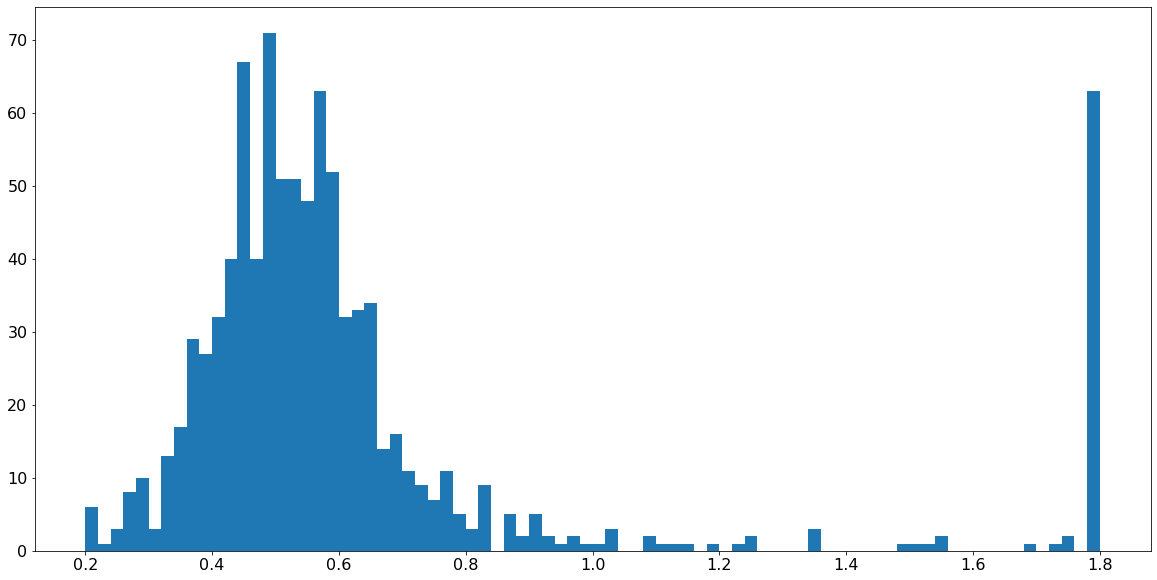

In [14]:
plt.figure(figsize=(20, 10))
plt.hist(ks.values(), bins=80)

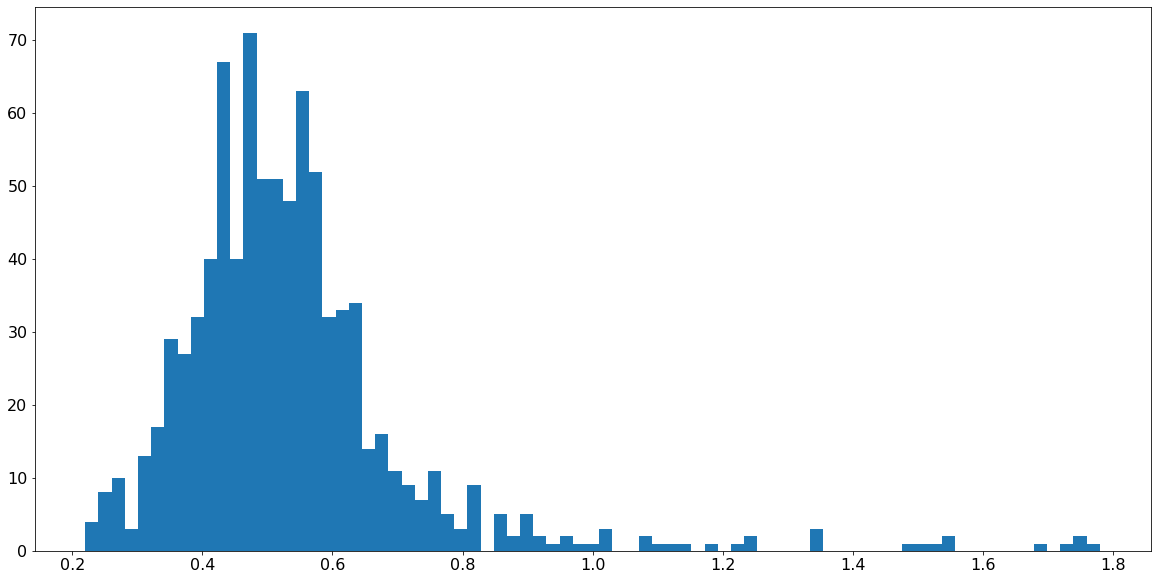

In [15]:
plt.figure(figsize=(20, 10))
counts, bins, _ = plt.hist([ x for x in ks.values() if x > 0.201 and x < 1.799 ], bins=77)

In [16]:
counts, bins

(array([ 4.,  8., 10.,  3., 13., 17., 29., 27., 32., 40., 67., 40., 71.,
        51., 51., 48., 63., 52., 32., 33., 34., 14., 16., 11.,  9.,  7.,
        11.,  5.,  3.,  9.,  0.,  5.,  2.,  5.,  2.,  1.,  2.,  1.,  1.,
         3.,  0.,  0.,  2.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  2.,  0.,
         0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
         2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  2.,  1.]),
 array([0.22      , 0.24025974, 0.26051948, 0.28077922, 0.30103896,
        0.3212987 , 0.34155844, 0.36181818, 0.38207792, 0.40233766,
        0.4225974 , 0.44285714, 0.46311688, 0.48337662, 0.50363636,
        0.5238961 , 0.54415584, 0.56441558, 0.58467532, 0.60493506,
        0.62519481, 0.64545455, 0.66571429, 0.68597403, 0.70623377,
        0.72649351, 0.74675325, 0.76701299, 0.78727273, 0.80753247,
        0.82779221, 0.84805195, 0.86831169, 0.88857143, 0.90883117,
        0.92909091, 0.94935065, 0.96961039, 0.98987013, 1.01012987,
        1.03038961, 1

In [11]:
def gaussian(x, *pars):
    A, mu, sigma = pars
    return A * np.exp(-(x-mu)**2/2/sigma**2)

(0.4890612720031042, 0.004024322092850655, 0.11176523915787599)

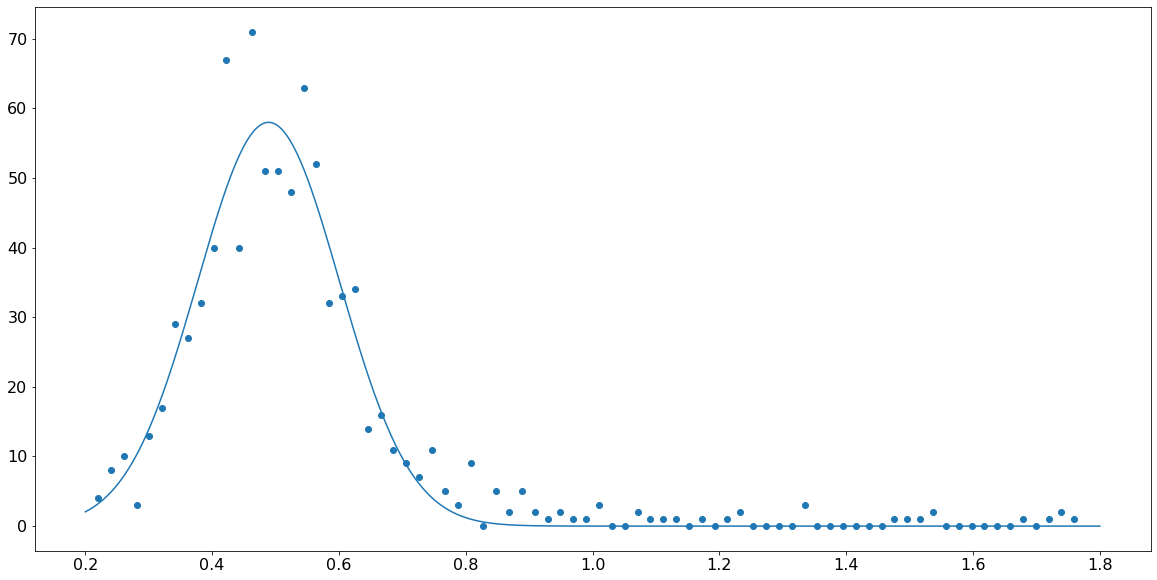

In [18]:
(A_fit, mu_fit, sigma_fit), var_matrix = curve_fit(gaussian, bins[:-1], counts, p0=[1, 0, 1])

xs = np.linspace(0.2, 1.8, 2000)
plt.figure(figsize=(20, 10))
plt.scatter(bins[:-1], counts)
plt.plot(xs, gaussian(xs, A_fit, mu_fit, sigma_fit))
mu_fit, var_matrix[1, 1]**.5, sigma_fit

In [11]:
ks_hr = {}
qs_hr = {}
for gaia_id in tqdm(DF[:1000][GAIA_ID_COLNAME]):
    min_k, min_rmse, min_q = 100, 100, 100
    gaia_flux = plot_conv_get_gaia(gaia_id=gaia_id)
    if gaia_flux is None:
        continue
            
    for k in np.arange(0.2, 0.8, 0.0025):
        rmse, q = plot_conv_k_rms(gaia_flux, gaia_id=gaia_id, k=k)
        if rmse < min_rmse:
            min_rmse = rmse
            min_k = k
            min_q = q
        else:
            break
        
    ks_hr[gaia_id] = min_k
    qs_hr[gaia_id] = min_q

  0%|                                                                                                                                | 0/1000 [00:00<?, ?it/s]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  0%|                                                                                                                    | 1/1000 [01:55<32:09:59, 115.92s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  0%|▏                                                                                                                    | 2/1000 [02:38<20:12:19, 72.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  0%|▎                                                                                                                    | 3/1000 [03:23<16:39:29, 60.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  0%|▍                                                                                                                    | 4/1000 [04:11<15:18:15, 55.32s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  0%|▌                                                                                                                    | 5/1000 [05:17<16:21:08, 59.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  1%|▋                                                                                                                    | 6/1000 [07:47<24:51:21, 90.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  1%|▊                                                                                                                    | 7/1000 [09:10<24:10:17, 87.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  1%|▉                                                                                                                    | 8/1000 [10:00<20:53:23, 75.81s/it]

Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  1%|█▎                                                                                                                  | 11/1000 [12:29<16:41:28, 60.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  1%|█▍                                                                                                                  | 12/1000 [12:47<14:07:28, 51.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  1%|█▌                                                                                                                  | 13/1000 [15:35<21:37:00, 78.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  1%|█▌                                                                                                                  | 14/1000 [16:40<20:39:42, 75.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  2%|█▋                                                                                                                  | 15/1000 [18:52<24:45:17, 90.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  2%|█▊                                                                                                                  | 16/1000 [19:09<19:13:16, 70.32s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  2%|██                                                                                                                  | 18/1000 [19:23<11:34:44, 42.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  2%|██▏                                                                                                                 | 19/1000 [20:58<14:58:07, 54.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  2%|██▎                                                                                                                 | 20/1000 [22:23<17:03:03, 62.64s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  2%|██▍                                                                                                                 | 21/1000 [24:56<23:35:36, 86.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  2%|██▌                                                                                                                 | 22/1000 [25:41<20:23:38, 75.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  2%|██▋                                                                                                                | 23/1000 [28:33<27:48:52, 102.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  2%|██▊                                                                                                                 | 24/1000 [29:38<24:54:07, 91.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  2%|██▉                                                                                                                 | 25/1000 [30:24<21:13:17, 78.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  3%|███                                                                                                                 | 26/1000 [31:39<20:56:23, 77.40s/it]

Could not get SDSS data
Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  3%|███▍                                                                                                                | 30/1000 [34:33<15:08:18, 56.18s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  3%|███▋                                                                                                                | 32/1000 [35:45<13:25:35, 49.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  3%|███▊                                                                                                                | 33/1000 [36:15<12:26:19, 46.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  3%|███▉                                                                                                                | 34/1000 [37:14<13:09:19, 49.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  4%|████                                                                                                                | 35/1000 [38:27<14:35:27, 54.43s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  4%|████▏                                                                                                               | 36/1000 [41:17<22:09:04, 82.72s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  4%|████▍                                                                                                               | 38/1000 [42:52<18:14:37, 68.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  4%|████▌                                                                                                               | 39/1000 [44:11<18:49:37, 70.53s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  4%|████▋                                                                                                               | 40/1000 [47:01<25:21:40, 95.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  4%|████▊                                                                                                               | 41/1000 [48:44<25:49:14, 96.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  4%|████▊                                                                                                               | 42/1000 [50:11<25:08:29, 94.48s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  4%|████▉                                                                                                               | 43/1000 [51:28<23:46:18, 89.42s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  4%|█████                                                                                                               | 44/1000 [52:41<22:32:06, 84.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  4%|█████▏                                                                                                              | 45/1000 [54:32<24:28:02, 92.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  5%|█████▎                                                                                                              | 46/1000 [55:37<22:20:46, 84.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  5%|█████▍                                                                                                              | 47/1000 [56:46<21:08:49, 79.88s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  5%|█████▋                                                                                                              | 49/1000 [58:10<16:30:37, 62.50s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  5%|█████▊                                                                                                              | 50/1000 [58:54<15:18:25, 58.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  5%|█████▊                                                                                                            | 51/1000 [1:00:37<18:21:35, 69.65s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  5%|██████                                                                                                            | 53/1000 [1:01:54<14:50:49, 56.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  5%|██████▏                                                                                                           | 54/1000 [1:02:53<14:59:43, 57.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  6%|██████▎                                                                                                           | 55/1000 [1:03:27<13:28:46, 51.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  6%|██████▍                                                                                                           | 56/1000 [1:05:32<18:33:00, 70.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  6%|██████▍                                                                                                           | 57/1000 [1:06:52<19:08:06, 73.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  6%|██████▌                                                                                                           | 58/1000 [1:09:25<25:03:08, 95.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  6%|██████▋                                                                                                           | 59/1000 [1:10:07<20:59:19, 80.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  6%|██████▊                                                                                                           | 60/1000 [1:11:29<21:03:08, 80.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  6%|██████▉                                                                                                           | 61/1000 [1:12:10<18:01:00, 69.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  6%|███████                                                                                                           | 62/1000 [1:13:27<18:35:27, 71.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  6%|███████▏                                                                                                          | 63/1000 [1:15:30<22:33:50, 86.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  6%|███████▎                                                                                                          | 64/1000 [1:16:18<19:33:41, 75.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  6%|███████▍                                                                                                          | 65/1000 [1:18:03<21:51:39, 84.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  7%|███████▌                                                                                                          | 66/1000 [1:19:31<22:08:29, 85.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  7%|███████▋                                                                                                          | 67/1000 [1:20:26<19:45:52, 76.26s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  7%|███████▊                                                                                                          | 69/1000 [1:22:01<16:17:51, 63.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  7%|███████▉                                                                                                          | 70/1000 [1:23:07<16:28:10, 63.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  7%|████████                                                                                                          | 71/1000 [1:24:35<18:04:33, 70.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  7%|████████▏                                                                                                         | 72/1000 [1:26:04<19:24:03, 75.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  7%|████████▎                                                                                                         | 73/1000 [1:27:56<22:01:17, 85.52s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  8%|████████▌                                                                                                         | 75/1000 [1:29:21<17:01:49, 66.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  8%|████████▋                                                                                                         | 76/1000 [1:30:26<16:58:41, 66.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  8%|████████▊                                                                                                         | 77/1000 [1:32:08<19:18:20, 75.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  8%|████████▉                                                                                                         | 78/1000 [1:34:30<23:52:12, 93.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  8%|█████████                                                                                                         | 79/1000 [1:35:50<22:52:54, 89.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  8%|█████████                                                                                                         | 80/1000 [1:36:28<19:09:26, 74.96s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  8%|█████████▏                                                                                                        | 81/1000 [1:37:34<18:28:13, 72.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  8%|█████████▎                                                                                                        | 82/1000 [1:39:14<20:31:08, 80.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  8%|█████████▍                                                                                                        | 83/1000 [1:40:39<20:46:32, 81.56s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  8%|█████████▌                                                                                                        | 84/1000 [1:42:17<22:01:58, 86.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  8%|█████████▋                                                                                                        | 85/1000 [1:43:33<21:12:28, 83.44s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  9%|█████████▉                                                                                                        | 87/1000 [1:45:12<17:11:25, 67.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  9%|██████████                                                                                                        | 88/1000 [1:46:11<16:37:56, 65.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  9%|██████████▏                                                                                                       | 89/1000 [1:47:19<16:47:11, 66.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  9%|██████████▎                                                                                                       | 90/1000 [1:48:34<17:21:30, 68.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  9%|██████████▎                                                                                                       | 91/1000 [1:50:21<20:03:02, 79.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  9%|██████████▍                                                                                                       | 92/1000 [1:51:42<20:05:53, 79.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  9%|██████████▌                                                                                                       | 93/1000 [1:53:24<21:45:29, 86.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  9%|██████████▋                                                                                                       | 94/1000 [1:55:08<23:00:22, 91.42s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 10%|██████████▊                                                                                                       | 95/1000 [1:57:04<24:48:43, 98.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 10%|██████████▉                                                                                                       | 96/1000 [1:58:07<22:05:53, 88.00s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 10%|███████████▏                                                                                                      | 98/1000 [1:59:38<17:09:56, 68.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 10%|███████████▎                                                                                                      | 99/1000 [2:01:14<18:51:29, 75.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 10%|███████████▎                                                                                                     | 100/1000 [2:02:31<18:55:49, 75.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 10%|███████████▍                                                                                                     | 101/1000 [2:04:35<22:13:06, 88.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 10%|███████████▌                                                                                                     | 102/1000 [2:05:59<21:49:02, 87.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 10%|███████████▋                                                                                                     | 103/1000 [2:08:08<24:44:58, 99.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 10%|███████████▋                                                                                                    | 104/1000 [2:10:43<28:44:11, 115.46s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 11%|███████████▉                                                                                                     | 106/1000 [2:12:19<21:05:52, 84.96s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 11%|████████████                                                                                                     | 107/1000 [2:13:45<21:09:01, 85.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 11%|████████████▏                                                                                                    | 108/1000 [2:15:10<21:05:15, 85.11s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 11%|████████████▎                                                                                                    | 109/1000 [2:16:19<19:59:48, 80.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 11%|████████████▍                                                                                                    | 110/1000 [2:16:30<15:11:36, 61.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 11%|████████████▌                                                                                                    | 111/1000 [2:17:38<15:37:01, 63.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 11%|████████████▋                                                                                                    | 112/1000 [2:19:08<17:31:01, 71.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 11%|████████████▊                                                                                                    | 113/1000 [2:21:41<23:21:15, 94.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 11%|████████████▊                                                                                                   | 114/1000 [2:24:14<27:34:45, 112.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 12%|████████████▉                                                                                                    | 115/1000 [2:25:18<24:00:17, 97.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 12%|████████████▉                                                                                                   | 116/1000 [2:27:24<26:04:31, 106.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 12%|█████████████▏                                                                                                   | 117/1000 [2:28:26<22:48:04, 92.96s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 12%|█████████████▎                                                                                                   | 118/1000 [2:29:45<21:46:15, 88.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 12%|█████████████▎                                                                                                  | 119/1000 [2:32:19<26:32:35, 108.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 12%|█████████████▍                                                                                                  | 120/1000 [2:33:41<24:34:29, 100.53s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 12%|█████████████▋                                                                                                   | 121/1000 [2:34:04<18:50:12, 77.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 12%|█████████████▊                                                                                                   | 122/1000 [2:35:45<20:34:48, 84.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 12%|█████████████▊                                                                                                  | 123/1000 [2:38:20<25:41:36, 105.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 12%|█████████████▉                                                                                                  | 124/1000 [2:40:55<29:15:08, 120.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 12%|██████████████▏                                                                                                  | 125/1000 [2:41:27<22:51:32, 94.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 13%|██████████████▏                                                                                                  | 126/1000 [2:42:49<21:54:53, 90.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 13%|██████████████▎                                                                                                  | 127/1000 [2:44:22<22:04:53, 91.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 13%|██████████████▍                                                                                                  | 128/1000 [2:45:07<18:43:09, 77.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 13%|██████████████▍                                                                                                 | 129/1000 [2:47:41<24:15:05, 100.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 13%|██████████████▋                                                                                                  | 130/1000 [2:49:14<23:44:44, 98.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 13%|██████████████▋                                                                                                 | 131/1000 [2:51:11<25:04:20, 103.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 13%|██████████████▉                                                                                                  | 132/1000 [2:52:12<21:54:19, 90.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 13%|███████████████                                                                                                  | 133/1000 [2:53:27<20:46:21, 86.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 13%|███████████████▏                                                                                                 | 134/1000 [2:55:18<22:31:00, 93.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 14%|███████████████▎                                                                                                 | 135/1000 [2:56:10<19:29:51, 81.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 14%|███████████████▏                                                                                                | 136/1000 [2:58:43<24:39:41, 102.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 14%|███████████████▍                                                                                                 | 137/1000 [3:00:16<23:53:31, 99.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 14%|███████████████▍                                                                                                | 138/1000 [3:02:50<27:46:52, 116.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 14%|███████████████▌                                                                                                | 139/1000 [3:05:24<30:26:36, 127.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 14%|███████████████▋                                                                                                | 140/1000 [3:07:17<29:23:39, 123.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 14%|███████████████▊                                                                                                | 141/1000 [3:08:55<27:35:57, 115.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 14%|███████████████▉                                                                                                | 142/1000 [3:10:35<26:27:05, 110.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 14%|████████████████                                                                                                | 143/1000 [3:12:16<25:41:27, 107.92s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 14%|████████████████▎                                                                                                | 144/1000 [3:13:18<22:22:56, 94.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 14%|████████████████▏                                                                                               | 145/1000 [3:15:14<23:55:40, 100.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 15%|████████████████▎                                                                                               | 146/1000 [3:18:05<28:53:32, 121.80s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 15%|████████████████▋                                                                                                | 148/1000 [3:20:04<22:00:27, 92.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 15%|████████████████▊                                                                                                | 149/1000 [3:21:42<22:18:25, 94.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 15%|████████████████▊                                                                                               | 150/1000 [3:24:15<25:54:28, 109.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 15%|████████████████▉                                                                                               | 151/1000 [3:25:56<25:17:13, 107.22s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 15%|█████████████████▎                                                                                               | 153/1000 [3:27:07<17:50:45, 75.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 15%|█████████████████▍                                                                                               | 154/1000 [3:27:58<16:27:26, 70.03s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 16%|█████████████████▋                                                                                               | 156/1000 [3:29:48<14:58:18, 63.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 16%|█████████████████▋                                                                                               | 157/1000 [3:31:50<17:59:12, 76.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 16%|█████████████████▊                                                                                               | 158/1000 [3:32:56<17:22:50, 74.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 16%|█████████████████▉                                                                                               | 159/1000 [3:33:50<16:07:22, 69.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 16%|██████████████████                                                                                               | 160/1000 [3:34:36<14:39:27, 62.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 16%|██████████████████▏                                                                                              | 161/1000 [3:35:55<15:43:12, 67.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 16%|██████████████████▎                                                                                              | 162/1000 [3:37:05<15:50:19, 68.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 16%|██████████████████▍                                                                                              | 163/1000 [3:38:23<16:31:36, 71.08s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 16%|██████████████████▌                                                                                              | 164/1000 [3:39:35<16:32:02, 71.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 16%|██████████████████▋                                                                                              | 165/1000 [3:41:09<18:03:38, 77.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 17%|██████████████████▊                                                                                              | 166/1000 [3:42:15<17:14:57, 74.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 17%|██████████████████▊                                                                                              | 167/1000 [3:44:48<22:39:03, 97.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 17%|██████████████████▉                                                                                              | 168/1000 [3:46:22<22:17:50, 96.48s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 17%|██████████████████▉                                                                                             | 169/1000 [3:48:32<24:37:30, 106.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 17%|███████████████████                                                                                             | 170/1000 [3:50:29<25:18:13, 109.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 17%|███████████████████▎                                                                                             | 171/1000 [3:51:39<22:30:55, 97.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 17%|███████████████████▎                                                                                            | 172/1000 [3:53:52<24:55:16, 108.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 17%|███████████████████▌                                                                                             | 173/1000 [3:55:12<22:56:27, 99.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 17%|███████████████████▋                                                                                             | 174/1000 [3:56:37<21:51:43, 95.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 18%|███████████████████▊                                                                                             | 175/1000 [3:58:15<22:03:34, 96.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 18%|███████████████████▉                                                                                             | 176/1000 [3:59:42<21:22:39, 93.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 18%|████████████████████                                                                                             | 177/1000 [4:01:22<21:47:49, 95.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 18%|████████████████████                                                                                             | 178/1000 [4:02:30<19:55:17, 87.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 18%|████████████████████                                                                                            | 179/1000 [4:05:25<25:55:09, 113.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 18%|████████████████████▏                                                                                           | 180/1000 [4:07:59<28:35:22, 125.52s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 18%|████████████████████▎                                                                                           | 181/1000 [4:10:31<30:23:36, 133.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 18%|████████████████████▌                                                                                            | 182/1000 [4:10:48<22:25:11, 98.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 18%|████████████████████▋                                                                                            | 183/1000 [4:11:54<20:09:42, 88.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 18%|████████████████████▊                                                                                            | 184/1000 [4:13:21<20:00:40, 88.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 18%|████████████████████▉                                                                                            | 185/1000 [4:15:11<21:25:52, 94.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 19%|████████████████████▊                                                                                           | 186/1000 [4:17:06<22:50:08, 100.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 19%|████████████████████▉                                                                                           | 187/1000 [4:19:04<23:57:43, 106.11s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 19%|█████████████████████                                                                                           | 188/1000 [4:20:39<23:10:18, 102.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 19%|█████████████████████▏                                                                                          | 189/1000 [4:22:19<22:55:20, 101.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 19%|█████████████████████▎                                                                                          | 190/1000 [4:24:03<23:02:40, 102.42s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 19%|█████████████████████▍                                                                                          | 191/1000 [4:25:38<22:33:47, 100.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 19%|█████████████████████▋                                                                                           | 192/1000 [4:26:31<19:18:08, 86.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 19%|█████████████████████▊                                                                                           | 193/1000 [4:27:35<17:47:58, 79.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 19%|█████████████████████▋                                                                                          | 194/1000 [4:30:09<22:49:45, 101.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 20%|██████████████████████                                                                                           | 195/1000 [4:31:18<20:31:55, 91.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 20%|██████████████████████▏                                                                                          | 196/1000 [4:32:35<19:31:15, 87.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 20%|██████████████████████▎                                                                                          | 197/1000 [4:33:13<16:13:10, 72.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 20%|██████████████████████▎                                                                                          | 198/1000 [4:35:13<19:23:01, 87.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 20%|██████████████████████▍                                                                                          | 199/1000 [4:37:09<21:17:16, 95.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 20%|██████████████████████▌                                                                                          | 200/1000 [4:38:27<20:01:32, 90.12s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 20%|██████████████████████▊                                                                                          | 202/1000 [4:41:17<19:29:13, 87.91s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 20%|██████████████████████▉                                                                                          | 203/1000 [4:42:11<17:34:45, 79.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 20%|██████████████████████▊                                                                                         | 204/1000 [4:45:04<22:59:21, 103.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 20%|███████████████████████▏                                                                                         | 205/1000 [4:46:12<20:46:51, 94.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 21%|███████████████████████▎                                                                                         | 206/1000 [4:46:36<16:27:35, 74.63s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 21%|███████████████████████▌                                                                                         | 208/1000 [4:48:16<14:00:47, 63.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 21%|███████████████████████▌                                                                                         | 209/1000 [4:49:37<14:54:34, 67.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 21%|███████████████████████▋                                                                                         | 210/1000 [4:50:56<15:30:52, 70.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 21%|███████████████████████▊                                                                                         | 211/1000 [4:51:50<14:30:28, 66.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 21%|███████████████████████▉                                                                                         | 212/1000 [4:53:30<16:31:06, 75.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 21%|████████████████████████                                                                                         | 213/1000 [4:56:03<21:17:30, 97.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 21%|████████████████████████▏                                                                                        | 214/1000 [4:57:40<21:13:50, 97.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 22%|████████████████████████▎                                                                                        | 215/1000 [4:58:28<18:05:07, 82.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 22%|████████████████████████▍                                                                                        | 216/1000 [4:59:49<17:58:22, 82.53s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 22%|████████████████████████▌                                                                                        | 217/1000 [5:01:13<18:01:16, 82.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 22%|████████████████████████▋                                                                                        | 218/1000 [5:02:55<19:15:28, 88.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 22%|████████████████████████▋                                                                                        | 219/1000 [5:03:54<17:16:53, 79.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 22%|████████████████████████▊                                                                                        | 220/1000 [5:04:49<15:41:17, 72.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 22%|████████████████████████▉                                                                                        | 221/1000 [5:06:10<16:11:03, 74.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 22%|█████████████████████████                                                                                        | 222/1000 [5:07:44<17:24:37, 80.56s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 22%|█████████████████████████▏                                                                                       | 223/1000 [5:08:55<16:47:47, 77.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 22%|█████████████████████████▎                                                                                       | 224/1000 [5:10:14<16:49:22, 78.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 22%|█████████████████████████▏                                                                                      | 225/1000 [5:12:47<21:38:59, 100.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 23%|█████████████████████████▌                                                                                       | 226/1000 [5:13:27<17:43:05, 82.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 23%|█████████████████████████▋                                                                                       | 227/1000 [5:14:14<15:26:32, 71.92s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 23%|█████████████████████████▊                                                                                       | 228/1000 [5:15:27<15:27:03, 72.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 23%|█████████████████████████▉                                                                                       | 229/1000 [5:17:08<17:20:00, 80.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 23%|█████████████████████████▉                                                                                       | 230/1000 [5:19:03<19:27:04, 90.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 23%|██████████████████████████                                                                                       | 231/1000 [5:19:38<15:51:01, 74.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 23%|██████████████████████████▏                                                                                      | 232/1000 [5:21:22<17:47:18, 83.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 23%|██████████████████████████▎                                                                                      | 233/1000 [5:23:27<20:25:01, 95.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 23%|██████████████████████████▍                                                                                      | 234/1000 [5:25:14<21:05:42, 99.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 24%|██████████████████████████▎                                                                                     | 235/1000 [5:27:03<21:40:53, 102.03s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 24%|██████████████████████████▊                                                                                      | 237/1000 [5:28:22<15:31:28, 73.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 24%|██████████████████████████▉                                                                                      | 238/1000 [5:29:52<16:21:17, 77.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 24%|███████████████████████████                                                                                      | 239/1000 [5:30:57<15:40:34, 74.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 24%|███████████████████████████                                                                                      | 240/1000 [5:33:30<20:10:54, 95.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 24%|███████████████████████████▏                                                                                     | 241/1000 [5:34:39<18:33:12, 88.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 24%|███████████████████████████▎                                                                                     | 242/1000 [5:35:38<16:47:40, 79.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 24%|███████████████████████████▍                                                                                     | 243/1000 [5:36:39<15:39:23, 74.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 24%|███████████████████████████▌                                                                                     | 244/1000 [5:38:12<16:45:42, 79.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 24%|███████████████████████████▍                                                                                    | 245/1000 [5:41:04<22:24:48, 106.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 25%|███████████████████████████▊                                                                                     | 246/1000 [5:42:20<20:31:05, 97.96s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 25%|███████████████████████████▉                                                                                     | 247/1000 [5:43:54<20:15:05, 96.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 25%|████████████████████████████                                                                                     | 248/1000 [5:44:55<17:57:07, 85.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 25%|████████████████████████████▏                                                                                    | 249/1000 [5:47:02<20:30:29, 98.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 25%|████████████████████████████▎                                                                                    | 250/1000 [5:48:25<19:31:41, 93.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 25%|████████████████████████████▎                                                                                    | 251/1000 [5:49:25<17:23:42, 83.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 25%|████████████████████████████▍                                                                                    | 252/1000 [5:50:45<17:07:19, 82.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 25%|████████████████████████████▌                                                                                    | 253/1000 [5:51:30<14:46:49, 71.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 25%|████████████████████████████▋                                                                                    | 254/1000 [5:54:02<19:48:38, 95.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 26%|████████████████████████████▊                                                                                    | 255/1000 [5:55:19<18:36:04, 89.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 26%|████████████████████████████▋                                                                                   | 256/1000 [5:58:12<23:44:09, 114.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 26%|█████████████████████████████                                                                                    | 257/1000 [5:59:13<20:22:34, 98.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 26%|████████████████████████████▉                                                                                   | 258/1000 [6:01:45<23:38:55, 114.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 26%|█████████████████████████████                                                                                   | 259/1000 [6:04:18<25:58:43, 126.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 26%|█████████████████████████████                                                                                   | 260/1000 [6:06:07<24:51:26, 120.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 26%|█████████████████████████████▏                                                                                  | 261/1000 [6:07:07<21:05:06, 102.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 26%|█████████████████████████████▌                                                                                   | 262/1000 [6:08:35<20:07:50, 98.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 26%|█████████████████████████████▋                                                                                   | 263/1000 [6:09:59<19:14:00, 93.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 26%|█████████████████████████████▊                                                                                   | 264/1000 [6:11:01<17:15:10, 84.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 26%|█████████████████████████████▉                                                                                   | 265/1000 [6:12:21<16:59:29, 83.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 27%|██████████████████████████████                                                                                   | 266/1000 [6:13:32<16:13:10, 79.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 27%|██████████████████████████████▏                                                                                  | 267/1000 [6:14:53<16:15:20, 79.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 27%|██████████████████████████████▎                                                                                  | 268/1000 [6:16:03<15:38:50, 76.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 27%|██████████████████████████████▍                                                                                  | 269/1000 [6:18:36<20:14:32, 99.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 27%|██████████████████████████████▌                                                                                  | 270/1000 [6:20:05<19:35:03, 96.58s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 27%|██████████████████████████████▌                                                                                  | 271/1000 [6:21:29<18:45:55, 92.67s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 27%|██████████████████████████████▊                                                                                  | 273/1000 [6:22:47<13:42:51, 67.91s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 27%|██████████████████████████████▉                                                                                  | 274/1000 [6:25:21<18:00:25, 89.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 28%|███████████████████████████████                                                                                  | 275/1000 [6:27:05<18:46:49, 93.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 28%|███████████████████████████████▏                                                                                 | 276/1000 [6:28:38<18:44:22, 93.18s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 28%|███████████████████████████████▎                                                                                 | 277/1000 [6:29:52<17:36:14, 87.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 28%|███████████████████████████████▍                                                                                 | 278/1000 [6:31:17<17:27:39, 87.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 28%|███████████████████████████████▌                                                                                 | 279/1000 [6:32:51<17:50:10, 89.06s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 28%|███████████████████████████████▊                                                                                 | 281/1000 [6:35:24<16:39:01, 83.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 28%|███████████████████████████████▊                                                                                 | 282/1000 [6:37:08<17:38:07, 88.42s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 28%|███████████████████████████████▉                                                                                 | 283/1000 [6:38:20<16:44:34, 84.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 28%|████████████████████████████████                                                                                 | 284/1000 [6:39:53<17:13:19, 86.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 28%|████████████████████████████████▏                                                                                | 285/1000 [6:41:28<17:38:19, 88.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 29%|████████████████████████████████▎                                                                                | 286/1000 [6:42:12<15:07:02, 76.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 29%|████████████████████████████████▍                                                                                | 287/1000 [6:43:00<13:25:57, 67.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 29%|████████████████████████████████▌                                                                                | 288/1000 [6:44:49<15:48:39, 79.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 29%|████████████████████████████████▋                                                                                | 289/1000 [6:46:39<17:32:47, 88.84s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 29%|████████████████████████████████▉                                                                                | 291/1000 [6:48:48<15:17:14, 77.62s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 29%|████████████████████████████████▉                                                                                | 292/1000 [6:49:45<14:18:42, 72.77s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 29%|█████████████████████████████████                                                                                | 293/1000 [6:50:48<13:44:45, 69.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 29%|█████████████████████████████████▏                                                                               | 294/1000 [6:52:30<15:27:35, 78.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 30%|█████████████████████████████████▎                                                                               | 295/1000 [6:53:42<15:04:19, 76.96s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 30%|█████████████████████████████████▍                                                                               | 296/1000 [6:55:42<17:27:28, 89.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 30%|█████████████████████████████████▌                                                                               | 297/1000 [6:57:00<16:45:36, 85.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 30%|█████████████████████████████████▋                                                                               | 298/1000 [6:58:26<16:44:15, 85.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 30%|█████████████████████████████████▊                                                                               | 299/1000 [7:00:23<18:32:00, 95.18s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 30%|█████████████████████████████████▉                                                                               | 300/1000 [7:01:13<15:53:15, 81.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 30%|██████████████████████████████████                                                                               | 301/1000 [7:02:58<17:12:50, 88.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 30%|██████████████████████████████████▏                                                                              | 302/1000 [7:04:10<16:13:36, 83.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 30%|██████████████████████████████████▏                                                                              | 303/1000 [7:05:53<17:20:28, 89.57s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 30%|██████████████████████████████████▍                                                                              | 305/1000 [7:07:00<12:16:20, 63.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 31%|██████████████████████████████████▌                                                                              | 306/1000 [7:08:32<13:38:32, 70.77s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 31%|██████████████████████████████████▋                                                                              | 307/1000 [7:10:36<16:17:47, 84.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 31%|██████████████████████████████████▊                                                                              | 308/1000 [7:11:57<16:03:50, 83.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 31%|██████████████████████████████████▉                                                                              | 309/1000 [7:14:19<19:09:42, 99.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 31%|██████████████████████████████████▋                                                                             | 310/1000 [7:16:17<20:07:53, 105.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 31%|███████████████████████████████████▏                                                                             | 311/1000 [7:17:32<18:28:29, 96.53s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 31%|███████████████████████████████████▎                                                                             | 312/1000 [7:19:13<18:41:13, 97.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 31%|███████████████████████████████████▎                                                                             | 313/1000 [7:20:12<16:29:38, 86.43s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 31%|███████████████████████████████████▏                                                                            | 314/1000 [7:23:02<21:10:03, 111.08s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 32%|███████████████████████████████████▎                                                                            | 315/1000 [7:25:54<24:35:42, 129.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 32%|███████████████████████████████████▍                                                                            | 316/1000 [7:27:23<22:14:39, 117.08s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 32%|███████████████████████████████████▌                                                                            | 317/1000 [7:29:03<21:16:14, 112.11s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 32%|███████████████████████████████████▌                                                                            | 318/1000 [7:31:58<24:48:51, 130.98s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 32%|████████████████████████████████████▏                                                                            | 320/1000 [7:33:41<17:48:01, 94.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 32%|████████████████████████████████████▎                                                                            | 321/1000 [7:34:47<16:29:22, 87.43s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 32%|████████████████████████████████████                                                                            | 322/1000 [7:37:21<19:42:33, 104.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 32%|████████████████████████████████████▏                                                                           | 323/1000 [7:38:51<18:57:36, 100.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 32%|████████████████████████████████████▌                                                                            | 324/1000 [7:39:52<16:50:23, 89.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 32%|████████████████████████████████████▋                                                                            | 325/1000 [7:40:34<14:15:40, 76.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 33%|████████████████████████████████████▊                                                                            | 326/1000 [7:42:10<15:19:30, 81.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 33%|████████████████████████████████████▉                                                                            | 327/1000 [7:43:02<13:38:14, 72.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 33%|█████████████████████████████████████                                                                            | 328/1000 [7:44:27<14:16:01, 76.43s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 33%|████████████████████████████████████▊                                                                           | 329/1000 [7:47:10<19:02:55, 102.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 33%|█████████████████████████████████████▎                                                                           | 330/1000 [7:48:18<17:07:09, 91.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 33%|█████████████████████████████████████▍                                                                           | 331/1000 [7:50:00<17:38:00, 94.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 33%|█████████████████████████████████████▌                                                                           | 332/1000 [7:51:30<17:21:49, 93.58s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 33%|█████████████████████████████████████▋                                                                           | 333/1000 [7:52:48<16:27:50, 88.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 33%|█████████████████████████████████████▋                                                                           | 334/1000 [7:54:13<16:13:03, 87.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 34%|█████████████████████████████████████▊                                                                           | 335/1000 [7:55:51<16:47:31, 90.91s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 34%|█████████████████████████████████████▉                                                                           | 336/1000 [7:56:54<15:12:35, 82.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 34%|██████████████████████████████████████                                                                           | 337/1000 [7:59:08<18:03:04, 98.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 34%|█████████████████████████████████████▊                                                                          | 338/1000 [8:01:10<19:19:56, 105.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 34%|█████████████████████████████████████▉                                                                          | 339/1000 [8:02:41<18:30:40, 100.82s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 34%|██████████████████████████████████████▌                                                                          | 341/1000 [8:03:32<12:06:10, 66.12s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 34%|██████████████████████████████████████▋                                                                          | 342/1000 [8:03:55<10:08:13, 55.46s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 34%|███████████████████████████████████████▏                                                                          | 344/1000 [8:05:16<8:57:36, 49.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 34%|██████████████████████████████████████▉                                                                          | 345/1000 [8:07:06<11:30:06, 63.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 35%|███████████████████████████████████████                                                                          | 346/1000 [8:08:51<13:20:27, 73.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 35%|███████████████████████████████████████▏                                                                         | 347/1000 [8:10:44<15:12:09, 83.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 35%|███████████████████████████████████████▎                                                                         | 348/1000 [8:12:29<16:10:45, 89.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 35%|███████████████████████████████████████▍                                                                         | 349/1000 [8:14:16<17:03:56, 94.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 35%|███████████████████████████████████████▌                                                                         | 350/1000 [8:15:24<15:39:48, 86.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 35%|███████████████████████████████████████▋                                                                         | 351/1000 [8:17:09<16:35:22, 92.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 35%|███████████████████████████████████████▍                                                                        | 352/1000 [8:19:28<19:04:35, 105.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 35%|███████████████████████████████████████▉                                                                         | 353/1000 [8:20:14<15:50:22, 88.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 35%|████████████████████████████████████████                                                                         | 354/1000 [8:21:51<16:16:49, 90.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 36%|███████████████████████████████████████▊                                                                        | 355/1000 [8:24:03<18:29:27, 103.21s/it]

Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 36%|████████████████████████████████████████▍                                                                        | 358/1000 [8:25:39<11:17:10, 63.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 36%|████████████████████████████████████████▌                                                                        | 359/1000 [8:26:59<11:52:10, 66.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 36%|████████████████████████████████████████▋                                                                        | 360/1000 [8:28:52<13:47:14, 77.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 36%|████████████████████████████████████████▊                                                                        | 361/1000 [8:30:34<14:50:47, 83.64s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 36%|████████████████████████████████████████▉                                                                        | 362/1000 [8:32:14<15:32:56, 87.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 36%|█████████████████████████████████████████                                                                        | 363/1000 [8:33:23<14:38:10, 82.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 36%|█████████████████████████████████████████▏                                                                       | 364/1000 [8:34:43<14:29:11, 82.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 36%|█████████████████████████████████████████▏                                                                       | 365/1000 [8:35:47<13:33:49, 76.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 37%|█████████████████████████████████████████▎                                                                       | 366/1000 [8:38:21<17:27:12, 99.11s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 37%|█████████████████████████████████████████▍                                                                       | 367/1000 [8:39:53<17:04:23, 97.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 37%|█████████████████████████████████████████▏                                                                      | 368/1000 [8:42:51<21:14:58, 121.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 37%|█████████████████████████████████████████▎                                                                      | 369/1000 [8:44:46<20:52:27, 119.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 37%|█████████████████████████████████████████▍                                                                      | 370/1000 [8:46:38<20:28:44, 117.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 37%|█████████████████████████████████████████▌                                                                      | 371/1000 [8:49:01<21:46:53, 124.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 37%|█████████████████████████████████████████▋                                                                      | 372/1000 [8:49:57<18:10:39, 104.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 37%|██████████████████████████████████████████▏                                                                      | 373/1000 [8:51:02<16:07:35, 92.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 37%|██████████████████████████████████████████▎                                                                      | 374/1000 [8:51:49<13:42:11, 78.80s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 38%|██████████████████████████████████████████▍                                                                      | 375/1000 [8:53:09<13:45:38, 79.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 38%|██████████████████████████████████████████▍                                                                      | 376/1000 [8:54:10<12:48:31, 73.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 38%|██████████████████████████████████████████▏                                                                     | 377/1000 [8:57:01<17:48:54, 102.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 38%|██████████████████████████████████████████▋                                                                      | 378/1000 [8:58:16<16:19:13, 94.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 38%|██████████████████████████████████████████▊                                                                      | 379/1000 [8:59:35<15:31:48, 90.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 38%|██████████████████████████████████████████▌                                                                     | 380/1000 [9:02:16<19:08:42, 111.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 38%|██████████████████████████████████████████▋                                                                     | 381/1000 [9:03:49<18:11:57, 105.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 38%|██████████████████████████████████████████▊                                                                     | 382/1000 [9:06:23<20:38:18, 120.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 38%|██████████████████████████████████████████▉                                                                     | 383/1000 [9:07:58<19:18:33, 112.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 38%|███████████████████████████████████████████                                                                     | 384/1000 [9:09:32<18:18:57, 107.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 38%|███████████████████████████████████████████                                                                     | 385/1000 [9:10:57<17:09:28, 100.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 39%|███████████████████████████████████████████▏                                                                    | 386/1000 [9:12:42<17:22:27, 101.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 39%|███████████████████████████████████████████▋                                                                     | 387/1000 [9:13:51<15:39:30, 91.96s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 39%|███████████████████████████████████████████▊                                                                     | 388/1000 [9:15:47<16:52:05, 99.22s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 39%|████████████████████████████████████████████                                                                     | 390/1000 [9:18:15<14:48:25, 87.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 39%|████████████████████████████████████████████▏                                                                    | 391/1000 [9:19:26<14:07:56, 83.54s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 39%|███████████████████████████████████████████▉                                                                    | 392/1000 [9:22:06<17:26:54, 103.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 39%|████████████████████████████████████████████                                                                    | 393/1000 [9:23:42<17:06:45, 101.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 39%|████████████████████████████████████████████▌                                                                    | 394/1000 [9:24:32<14:40:06, 87.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 40%|████████████████████████████████████████████▋                                                                    | 395/1000 [9:26:28<16:00:06, 95.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 40%|████████████████████████████████████████████▋                                                                    | 396/1000 [9:26:57<12:46:43, 76.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 40%|████████████████████████████████████████████▊                                                                    | 397/1000 [9:28:37<13:54:31, 83.04s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 40%|█████████████████████████████████████████████                                                                    | 399/1000 [9:30:03<10:50:00, 64.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 40%|█████████████████████████████████████████████▏                                                                   | 400/1000 [9:31:45<12:20:06, 74.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 40%|█████████████████████████████████████████████▎                                                                   | 401/1000 [9:33:19<13:09:14, 79.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 40%|█████████████████████████████████████████████▍                                                                   | 402/1000 [9:35:10<14:35:40, 87.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 40%|█████████████████████████████████████████████▌                                                                   | 403/1000 [9:36:53<15:16:22, 92.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 40%|█████████████████████████████████████████████▏                                                                  | 404/1000 [9:39:26<18:06:28, 109.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 40%|█████████████████████████████████████████████▊                                                                   | 405/1000 [9:40:32<15:59:01, 96.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 41%|█████████████████████████████████████████████▉                                                                   | 406/1000 [9:41:28<14:01:35, 85.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 41%|█████████████████████████████████████████████▌                                                                  | 407/1000 [9:43:53<16:54:06, 102.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 41%|██████████████████████████████████████████████                                                                   | 408/1000 [9:45:06<15:23:57, 93.64s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 41%|██████████████████████████████████████████████▏                                                                  | 409/1000 [9:46:28<14:48:10, 90.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 41%|██████████████████████████████████████████████▎                                                                  | 410/1000 [9:48:05<15:07:30, 92.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 41%|██████████████████████████████████████████████▍                                                                  | 411/1000 [9:49:16<14:04:11, 86.00s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 41%|██████████████████████████████████████████████▋                                                                  | 413/1000 [9:50:30<10:21:12, 63.50s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 41%|███████████████████████████████████████████████▏                                                                  | 414/1000 [9:51:23<9:53:58, 60.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 42%|██████████████████████████████████████████████▉                                                                  | 415/1000 [9:52:48<10:54:08, 67.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 42%|███████████████████████████████████████████████                                                                  | 416/1000 [9:54:45<13:04:20, 80.58s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 42%|███████████████████████████████████████████████                                                                  | 417/1000 [9:56:04<12:58:53, 80.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 42%|███████████████████████████████████████████████▏                                                                 | 418/1000 [9:57:13<12:28:00, 77.11s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 42%|███████████████████████████████████████████████▎                                                                 | 419/1000 [9:58:56<13:40:16, 84.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 42%|███████████████████████████████████████████████                                                                 | 420/1000 [10:00:33<14:11:19, 88.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 42%|███████████████████████████████████████████████▏                                                                | 421/1000 [10:02:03<14:15:54, 88.70s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 42%|███████████████████████████████████████████████▍                                                                | 423/1000 [10:04:08<12:17:11, 76.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 42%|███████████████████████████████████████████████▍                                                                | 424/1000 [10:05:33<12:37:54, 78.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 42%|███████████████████████████████████████████████▌                                                                | 425/1000 [10:07:25<13:56:58, 87.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 43%|███████████████████████████████████████████████▋                                                                | 426/1000 [10:08:20<12:33:08, 78.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 43%|███████████████████████████████████████████████▊                                                                | 427/1000 [10:09:36<12:24:05, 77.92s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 43%|███████████████████████████████████████████████▉                                                                | 428/1000 [10:10:51<12:15:22, 77.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 43%|████████████████████████████████████████████████                                                                | 429/1000 [10:12:01<11:54:18, 75.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 43%|████████████████████████████████████████████████▏                                                               | 430/1000 [10:14:11<14:25:34, 91.11s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 43%|████████████████████████████████████████████████▎                                                               | 431/1000 [10:16:02<15:18:15, 96.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 43%|████████████████████████████████████████████████▍                                                               | 432/1000 [10:17:37<15:11:54, 96.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 43%|████████████████████████████████████████████████▍                                                               | 433/1000 [10:19:10<15:01:09, 95.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 43%|████████████████████████████████████████████████▌                                                               | 434/1000 [10:20:49<15:11:27, 96.62s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 44%|████████████████████████████████████████████████▎                                                              | 435/1000 [10:22:41<15:52:52, 101.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 44%|████████████████████████████████████████████████▍                                                              | 436/1000 [10:25:32<19:05:59, 121.91s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 44%|████████████████████████████████████████████████▌                                                              | 437/1000 [10:27:02<17:34:03, 112.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 44%|████████████████████████████████████████████████▌                                                              | 438/1000 [10:29:37<19:31:59, 125.12s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 44%|████████████████████████████████████████████████▋                                                              | 439/1000 [10:30:44<16:47:20, 107.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 44%|█████████████████████████████████████████████████▎                                                              | 440/1000 [10:31:38<14:15:34, 91.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 44%|█████████████████████████████████████████████████▍                                                              | 441/1000 [10:33:10<14:15:12, 91.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 44%|█████████████████████████████████████████████████                                                              | 442/1000 [10:35:24<16:09:40, 104.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 44%|█████████████████████████████████████████████████▌                                                              | 443/1000 [10:36:30<14:21:30, 92.80s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 44%|█████████████████████████████████████████████████▎                                                             | 444/1000 [10:39:03<17:09:08, 111.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 44%|█████████████████████████████████████████████████▍                                                             | 445/1000 [10:40:57<17:15:25, 111.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 45%|█████████████████████████████████████████████████▌                                                             | 446/1000 [10:43:31<19:10:07, 124.56s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 45%|█████████████████████████████████████████████████▌                                                             | 447/1000 [10:44:43<16:42:12, 108.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 45%|██████████████████████████████████████████████████▏                                                             | 448/1000 [10:45:56<15:00:24, 97.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 45%|██████████████████████████████████████████████████▎                                                             | 449/1000 [10:47:23<14:30:09, 94.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 45%|██████████████████████████████████████████████████▍                                                             | 450/1000 [10:48:40<13:39:10, 89.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 45%|██████████████████████████████████████████████████                                                             | 451/1000 [10:51:05<16:10:30, 106.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 45%|██████████████████████████████████████████████████▏                                                            | 452/1000 [10:53:55<19:04:57, 125.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 45%|██████████████████████████████████████████████████▎                                                            | 453/1000 [10:55:07<16:36:28, 109.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 45%|██████████████████████████████████████████████████▍                                                            | 454/1000 [10:56:30<15:23:42, 101.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 46%|██████████████████████████████████████████████████▉                                                             | 455/1000 [10:57:20<13:00:33, 85.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 46%|███████████████████████████████████████████████████                                                             | 456/1000 [10:57:56<10:44:13, 71.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 46%|███████████████████████████████████████████████████▏                                                            | 457/1000 [11:00:29<14:23:59, 95.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 46%|███████████████████████████████████████████████████▎                                                            | 458/1000 [11:01:26<12:40:01, 84.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 46%|██████████████████████████████████████████████████▉                                                            | 459/1000 [11:04:00<15:45:45, 104.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 46%|███████████████████████████████████████████████████                                                            | 460/1000 [11:05:45<15:43:53, 104.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 46%|███████████████████████████████████████████████████▏                                                           | 461/1000 [11:08:14<17:42:00, 118.22s/it]

Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 46%|███████████████████████████████████████████████████▉                                                            | 464/1000 [11:09:49<10:20:39, 69.48s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 46%|████████████████████████████████████████████████████▌                                                            | 465/1000 [11:10:22<9:11:13, 61.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 47%|████████████████████████████████████████████████████▏                                                           | 466/1000 [11:12:24<11:15:20, 75.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 47%|████████████████████████████████████████████████████▎                                                           | 467/1000 [11:13:10<10:08:04, 68.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 47%|████████████████████████████████████████████████████▉                                                            | 468/1000 [11:13:59<9:20:09, 63.18s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 47%|████████████████████████████████████████████████████▉                                                            | 469/1000 [11:14:59<9:11:31, 62.32s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 47%|████████████████████████████████████████████████████▋                                                           | 470/1000 [11:16:46<11:00:41, 74.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 47%|████████████████████████████████████████████████████▎                                                          | 471/1000 [11:19:35<14:59:04, 101.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 47%|████████████████████████████████████████████████████▍                                                          | 472/1000 [11:21:55<16:33:38, 112.91s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 47%|████████████████████████████████████████████████████▉                                                           | 473/1000 [11:23:01<14:30:42, 99.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 47%|████████████████████████████████████████████████████▌                                                          | 474/1000 [11:24:50<14:54:03, 101.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 48%|████████████████████████████████████████████████████▋                                                          | 475/1000 [11:26:35<15:01:06, 102.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 48%|█████████████████████████████████████████████████████▎                                                          | 476/1000 [11:27:05<11:49:21, 81.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 48%|█████████████████████████████████████████████████████▍                                                          | 477/1000 [11:28:50<12:49:54, 88.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 48%|█████████████████████████████████████████████████████▌                                                          | 478/1000 [11:30:29<13:16:49, 91.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 48%|█████████████████████████████████████████████████████▋                                                          | 479/1000 [11:31:44<12:32:20, 86.64s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 48%|██████████████████████████████████████████████████████▎                                                          | 481/1000 [11:32:06<7:26:45, 51.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 48%|██████████████████████████████████████████████████████▍                                                          | 482/1000 [11:33:24<8:22:41, 58.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 48%|██████████████████████████████████████████████████████                                                          | 483/1000 [11:35:07<10:03:21, 70.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 48%|██████████████████████████████████████████████████████▏                                                         | 484/1000 [11:36:41<10:57:57, 76.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 48%|██████████████████████████████████████████████████████▎                                                         | 485/1000 [11:38:09<11:24:50, 79.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 49%|██████████████████████████████████████████████████████▍                                                         | 486/1000 [11:39:03<10:20:18, 72.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 49%|██████████████████████████████████████████████████████▌                                                         | 487/1000 [11:40:14<10:14:49, 71.91s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 49%|███████████████████████████████████████████████████████▎                                                         | 489/1000 [11:41:02<7:08:00, 50.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 49%|███████████████████████████████████████████████████████▎                                                         | 490/1000 [11:42:01<7:24:16, 52.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 49%|███████████████████████████████████████████████████████▍                                                         | 491/1000 [11:43:49<9:25:52, 66.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 49%|███████████████████████████████████████████████████████                                                         | 492/1000 [11:46:21<12:39:05, 89.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 49%|███████████████████████████████████████████████████████▏                                                        | 493/1000 [11:47:33<11:57:52, 84.96s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 49%|███████████████████████████████████████████████████████▎                                                        | 494/1000 [11:49:17<12:42:15, 90.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 50%|███████████████████████████████████████████████████████▍                                                        | 495/1000 [11:50:57<13:02:42, 93.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 50%|███████████████████████████████████████████████████████                                                        | 496/1000 [11:53:15<14:52:10, 106.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 50%|███████████████████████████████████████████████████████▋                                                        | 497/1000 [11:54:09<12:41:55, 90.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 50%|███████████████████████████████████████████████████████▊                                                        | 498/1000 [11:55:14<11:34:52, 83.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 50%|███████████████████████████████████████████████████████▉                                                        | 499/1000 [11:56:53<12:12:55, 87.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 50%|████████████████████████████████████████████████████████                                                        | 500/1000 [11:57:48<10:50:03, 78.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 50%|████████████████████████████████████████████████████████▌                                                        | 501/1000 [11:58:28<9:15:33, 66.80s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 50%|████████████████████████████████████████████████████████▏                                                       | 502/1000 [12:01:00<12:46:37, 92.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 50%|████████████████████████████████████████████████████████▎                                                       | 503/1000 [12:02:27<12:31:23, 90.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 50%|███████████████████████████████████████████████████████▉                                                       | 504/1000 [12:04:31<13:51:58, 100.64s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 50%|████████████████████████████████████████████████████████                                                       | 505/1000 [12:07:05<16:02:39, 116.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 51%|████████████████████████████████████████████████████████▏                                                      | 506/1000 [12:08:56<15:47:12, 115.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 51%|████████████████████████████████████████████████████████▎                                                      | 507/1000 [12:10:10<14:02:43, 102.56s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 51%|████████████████████████████████████████████████████████▉                                                       | 508/1000 [12:10:57<11:44:04, 85.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 51%|████████████████████████████████████████████████████████▍                                                      | 509/1000 [12:13:32<14:32:27, 106.61s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 51%|█████████████████████████████████████████████████████████▋                                                       | 511/1000 [12:14:20<9:18:55, 68.58s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 51%|█████████████████████████████████████████████████████████▊                                                       | 512/1000 [12:15:47<9:54:51, 73.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 51%|█████████████████████████████████████████████████████████▉                                                       | 513/1000 [12:17:03<9:58:38, 73.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 51%|██████████████████████████████████████████████████████████                                                       | 514/1000 [12:17:53<9:06:22, 67.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 52%|██████████████████████████████████████████████████████████▏                                                      | 515/1000 [12:18:58<9:00:04, 66.81s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 52%|██████████████████████████████████████████████████████████▍                                                      | 517/1000 [12:20:34<7:50:03, 58.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 52%|██████████████████████████████████████████████████████████▌                                                      | 518/1000 [12:22:03<8:48:56, 65.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 52%|██████████████████████████████████████████████████████████▏                                                     | 519/1000 [12:24:14<10:59:46, 82.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 52%|██████████████████████████████████████████████████████████▏                                                     | 520/1000 [12:25:52<11:33:31, 86.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 52%|██████████████████████████████████████████████████████████▎                                                     | 521/1000 [12:28:05<13:14:24, 99.51s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 52%|███████████████████████████████████████████████████████████                                                      | 523/1000 [12:29:32<9:53:44, 74.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 52%|██████████████████████████████████████████████████████████▋                                                     | 524/1000 [12:31:00<10:18:37, 77.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 52%|██████████████████████████████████████████████████████████▊                                                     | 525/1000 [12:32:39<10:59:32, 83.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 53%|███████████████████████████████████████████████████████████▍                                                     | 526/1000 [12:33:34<9:57:14, 75.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 53%|███████████████████████████████████████████████████████████                                                     | 527/1000 [12:35:35<11:35:47, 88.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 53%|███████████████████████████████████████████████████████████▏                                                    | 528/1000 [12:37:31<12:35:07, 95.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 53%|███████████████████████████████████████████████████████████▏                                                    | 529/1000 [12:39:04<12:27:41, 95.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 53%|███████████████████████████████████████████████████████████▎                                                    | 530/1000 [12:40:44<12:36:53, 96.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 53%|███████████████████████████████████████████████████████████▍                                                    | 531/1000 [12:42:15<12:23:33, 95.12s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 53%|███████████████████████████████████████████████████████████▌                                                    | 532/1000 [12:43:32<11:38:16, 89.52s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 53%|████████████████████████████████████████████████████████████▎                                                    | 534/1000 [12:44:53<8:41:08, 67.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 54%|████████████████████████████████████████████████████████████▍                                                    | 535/1000 [12:46:02<8:44:27, 67.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 54%|████████████████████████████████████████████████████████████▌                                                    | 536/1000 [12:47:20<9:03:15, 70.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 54%|████████████████████████████████████████████████████████████▋                                                    | 537/1000 [12:48:31<9:04:13, 70.53s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 54%|████████████████████████████████████████████████████████████▊                                                    | 538/1000 [12:49:46<9:13:19, 71.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 54%|████████████████████████████████████████████████████████████▎                                                   | 539/1000 [12:52:20<12:11:17, 95.18s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 54%|████████████████████████████████████████████████████████████▍                                                   | 540/1000 [12:53:22<10:55:12, 85.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 54%|████████████████████████████████████████████████████████████▌                                                   | 541/1000 [12:54:33<10:22:47, 81.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 54%|████████████████████████████████████████████████████████████▋                                                   | 542/1000 [12:56:14<11:06:01, 87.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 54%|████████████████████████████████████████████████████████████▊                                                   | 543/1000 [12:57:52<11:27:33, 90.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 54%|████████████████████████████████████████████████████████████▉                                                   | 544/1000 [12:59:25<11:33:34, 91.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 55%|████████████████████████████████████████████████████████████▍                                                  | 545/1000 [13:01:36<12:59:51, 102.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 55%|████████████████████████████████████████████████████████████▌                                                  | 546/1000 [13:03:49<14:07:09, 111.96s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 55%|████████████████████████████████████████████████████████████▋                                                  | 547/1000 [13:06:24<15:41:37, 124.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 55%|████████████████████████████████████████████████████████████▊                                                  | 548/1000 [13:08:29<15:41:24, 124.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 55%|████████████████████████████████████████████████████████████▉                                                  | 549/1000 [13:11:04<16:47:16, 134.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 55%|█████████████████████████████████████████████████████████████                                                  | 550/1000 [13:12:48<15:36:18, 124.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 55%|█████████████████████████████████████████████████████████████▏                                                 | 551/1000 [13:15:42<17:25:18, 139.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 55%|█████████████████████████████████████████████████████████████▎                                                 | 552/1000 [13:16:59<15:01:59, 120.80s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 55%|█████████████████████████████████████████████████████████████▍                                                 | 553/1000 [13:18:16<13:21:50, 107.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 55%|█████████████████████████████████████████████████████████████▍                                                 | 554/1000 [13:20:02<13:17:43, 107.32s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 56%|█████████████████████████████████████████████████████████████▌                                                 | 555/1000 [13:21:48<13:12:04, 106.80s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 56%|██████████████████████████████████████████████████████████████▎                                                 | 556/1000 [13:23:09<12:13:37, 99.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 56%|█████████████████████████████████████████████████████████████▊                                                 | 557/1000 [13:25:42<14:11:54, 115.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 56%|█████████████████████████████████████████████████████████████▉                                                 | 558/1000 [13:27:05<12:57:23, 105.53s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 56%|██████████████████████████████████████████████████████████████                                                 | 559/1000 [13:28:59<13:14:05, 108.04s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 56%|███████████████████████████████████████████████████████████████▍                                                 | 561/1000 [13:30:28<9:35:42, 78.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 56%|███████████████████████████████████████████████████████████████▌                                                 | 562/1000 [13:31:51<9:42:41, 79.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 56%|███████████████████████████████████████████████████████████████▌                                                 | 563/1000 [13:32:51<9:04:26, 74.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 56%|███████████████████████████████████████████████████████████████▏                                                | 564/1000 [13:35:15<11:19:08, 93.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 56%|███████████████████████████████████████████████████████████████▎                                                | 565/1000 [13:36:23<10:26:21, 86.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 57%|███████████████████████████████████████████████████████████████▉                                                 | 566/1000 [13:37:11<9:04:34, 75.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 57%|███████████████████████████████████████████████████████████████▌                                                | 567/1000 [13:39:18<10:51:54, 90.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 57%|███████████████████████████████████████████████████████████████▌                                                | 568/1000 [13:40:37<10:26:29, 87.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 57%|███████████████████████████████████████████████████████████████▋                                                | 569/1000 [13:42:45<11:52:40, 99.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 57%|███████████████████████████████████████████████████████████████▊                                                | 570/1000 [13:44:15<11:30:15, 96.32s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 57%|███████████████████████████████████████████████████████████████▉                                                | 571/1000 [13:45:19<10:21:30, 86.92s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 57%|████████████████████████████████████████████████████████████████                                                | 572/1000 [13:46:42<10:11:54, 85.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 57%|████████████████████████████████████████████████████████████████▏                                               | 573/1000 [13:48:05<10:03:16, 84.77s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 57%|████████████████████████████████████████████████████████████████▎                                               | 574/1000 [13:50:09<11:24:42, 96.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 57%|████████████████████████████████████████████████████████████████▍                                               | 575/1000 [13:51:22<10:34:58, 89.64s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 58%|███████████████████████████████████████████████████████████████▉                                               | 576/1000 [13:53:56<12:49:37, 108.91s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 58%|████████████████████████████████████████████████████████████████                                               | 577/1000 [13:56:30<14:21:54, 122.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 58%|████████████████████████████████████████████████████████████████▏                                              | 578/1000 [13:57:26<12:01:08, 102.53s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 58%|████████████████████████████████████████████████████████████████▎                                              | 579/1000 [13:59:14<12:10:54, 104.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 58%|████████████████████████████████████████████████████████████████▍                                              | 580/1000 [14:01:03<12:19:17, 105.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 58%|████████████████████████████████████████████████████████████████▍                                              | 581/1000 [14:02:37<11:52:15, 101.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 58%|████████████████████████████████████████████████████████████████▌                                              | 582/1000 [14:05:09<13:35:33, 117.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 58%|████████████████████████████████████████████████████████████████▋                                              | 583/1000 [14:06:50<13:00:01, 112.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 58%|████████████████████████████████████████████████████████████████▊                                              | 584/1000 [14:08:09<11:49:57, 102.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 58%|█████████████████████████████████████████████████████████████████▌                                              | 585/1000 [14:09:24<10:50:33, 94.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 59%|██████████████████████████████████████████████████████████████████▏                                              | 586/1000 [14:10:18<9:26:43, 82.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 59%|█████████████████████████████████████████████████████████████████▋                                              | 587/1000 [14:12:20<10:46:23, 93.91s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 59%|██████████████████████████████████████████████████████████████████▌                                              | 589/1000 [14:14:13<8:45:07, 76.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 59%|██████████████████████████████████████████████████████████████████▋                                              | 590/1000 [14:15:00<7:53:21, 69.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 59%|██████████████████████████████████████████████████████████████████▊                                              | 591/1000 [14:16:34<8:36:51, 75.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 59%|██████████████████████████████████████████████████████████████████▉                                              | 592/1000 [14:17:58<8:51:13, 78.12s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 59%|███████████████████████████████████████████████████████████████████                                              | 593/1000 [14:18:22<7:07:18, 62.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 59%|███████████████████████████████████████████████████████████████████                                              | 594/1000 [14:19:54<8:01:02, 71.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 60%|███████████████████████████████████████████████████████████████████▏                                             | 595/1000 [14:21:34<8:56:21, 79.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 60%|███████████████████████████████████████████████████████████████████▎                                             | 596/1000 [14:22:56<8:59:55, 80.19s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 60%|███████████████████████████████████████████████████████████████████▌                                             | 598/1000 [14:24:19<6:59:41, 62.64s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 60%|███████████████████████████████████████████████████████████████████▋                                             | 599/1000 [14:25:19<6:54:32, 62.03s/it]

Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 60%|████████████████████████████████████████████████████████████████████                                             | 602/1000 [14:26:43<4:55:13, 44.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 60%|████████████████████████████████████████████████████████████████████▏                                            | 603/1000 [14:27:46<5:18:41, 48.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 60%|████████████████████████████████████████████████████████████████████▎                                            | 604/1000 [14:29:22<6:26:48, 58.61s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 61%|████████████████████████████████████████████████████████████████████▍                                            | 606/1000 [14:31:11<6:15:21, 57.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 61%|████████████████████████████████████████████████████████████████████▌                                            | 607/1000 [14:33:45<8:30:51, 77.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 61%|████████████████████████████████████████████████████████████████████▋                                            | 608/1000 [14:34:59<8:22:57, 76.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 61%|████████████████████████████████████████████████████████████████████▊                                            | 609/1000 [14:36:41<9:02:29, 83.25s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 61%|█████████████████████████████████████████████████████████████████████                                            | 611/1000 [14:38:54<8:14:42, 76.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 61%|████████████████████████████████████████████████████████████████████▌                                           | 612/1000 [14:41:46<10:36:15, 98.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 61%|████████████████████████████████████████████████████████████████████                                           | 613/1000 [14:44:19<12:01:03, 111.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 61%|████████████████████████████████████████████████████████████████████▏                                          | 614/1000 [14:45:43<11:13:14, 104.65s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 62%|█████████████████████████████████████████████████████████████████████▌                                           | 616/1000 [14:47:19<8:34:17, 80.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 62%|█████████████████████████████████████████████████████████████████████▋                                           | 617/1000 [14:48:47<8:44:17, 82.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 62%|████████████████████████████████████████████████████████████████████▌                                          | 618/1000 [14:51:38<11:04:48, 104.42s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 62%|█████████████████████████████████████████████████████████████████████▎                                          | 619/1000 [14:52:54<10:16:22, 97.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 62%|████████████████████████████████████████████████████████████████████▊                                          | 620/1000 [14:54:50<10:47:12, 102.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 62%|████████████████████████████████████████████████████████████████████▉                                          | 621/1000 [14:56:30<10:40:53, 101.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 62%|██████████████████████████████████████████████████████████████████████▎                                          | 622/1000 [14:57:12<8:52:49, 84.58s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 62%|█████████████████████████████████████████████████████████████████████▏                                         | 623/1000 [14:59:47<10:58:52, 104.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 62%|█████████████████████████████████████████████████████████████████████▎                                         | 624/1000 [15:01:33<11:00:18, 105.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 62%|█████████████████████████████████████████████████████████████████████▍                                         | 625/1000 [15:03:20<11:01:25, 105.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 63%|█████████████████████████████████████████████████████████████████████▍                                         | 626/1000 [15:04:55<10:39:48, 102.64s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 63%|█████████████████████████████████████████████████████████████████████▌                                         | 627/1000 [15:07:09<11:35:03, 111.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 63%|█████████████████████████████████████████████████████████████████████▋                                         | 628/1000 [15:08:31<10:38:49, 103.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 63%|█████████████████████████████████████████████████████████████████████▊                                         | 629/1000 [15:10:25<10:56:59, 106.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 63%|███████████████████████████████████████████████████████████████████████▏                                         | 630/1000 [15:11:20<9:20:13, 90.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 63%|██████████████████████████████████████████████████████████████████████                                         | 631/1000 [15:14:14<11:51:21, 115.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 63%|██████████████████████████████████████████████████████████████████████▏                                        | 632/1000 [15:15:45<11:05:08, 108.45s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 63%|███████████████████████████████████████████████████████████████████████▋                                         | 634/1000 [15:16:54<7:33:18, 74.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 64%|███████████████████████████████████████████████████████████████████████▊                                         | 635/1000 [15:18:40<8:19:43, 82.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 64%|███████████████████████████████████████████████████████████████████████▊                                         | 636/1000 [15:19:59<8:13:31, 81.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 64%|███████████████████████████████████████████████████████████████████████▉                                         | 637/1000 [15:21:36<8:38:12, 85.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 64%|████████████████████████████████████████████████████████████████████████                                         | 638/1000 [15:22:43<8:05:03, 80.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 64%|████████████████████████████████████████████████████████████████████████▏                                        | 639/1000 [15:24:09<8:13:03, 81.95s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 64%|████████████████████████████████████████████████████████████████████████▍                                        | 641/1000 [15:27:00<8:20:22, 83.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 64%|███████████████████████████████████████████████████████████████████████▎                                       | 642/1000 [15:29:55<10:30:29, 105.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 64%|████████████████████████████████████████████████████████████████████████▋                                        | 643/1000 [15:31:15<9:50:42, 99.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 64%|████████████████████████████████████████████████████████████████████████▊                                        | 644/1000 [15:32:45<9:34:10, 96.77s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 64%|████████████████████████████████████████████████████████████████████████▉                                        | 645/1000 [15:34:02<8:58:44, 91.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 65%|███████████████████████████████████████████████████████████████████████▋                                       | 646/1000 [15:36:36<10:43:41, 109.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 65%|███████████████████████████████████████████████████████████████████████▊                                       | 647/1000 [15:38:59<11:39:46, 118.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 65%|███████████████████████████████████████████████████████████████████████▉                                       | 648/1000 [15:40:01<10:00:08, 102.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 65%|████████████████████████████████████████████████████████████████████████                                       | 649/1000 [15:42:55<12:00:52, 123.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 650/1000 [15:44:08<10:32:41, 108.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 65%|████████████████████████████████████████████████████████████████████████▎                                      | 651/1000 [15:46:42<11:50:06, 122.08s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 65%|████████████████████████████████████████████████████████████████████████▎                                      | 652/1000 [15:47:54<10:21:35, 107.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 65%|████████████████████████████████████████████████████████████████████████▍                                      | 653/1000 [15:49:43<10:23:00, 107.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 65%|████████████████████████████████████████████████████████████████████████▌                                      | 654/1000 [15:52:38<12:16:47, 127.77s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 66%|████████████████████████████████████████████████████████████████████████▋                                      | 655/1000 [15:53:38<10:18:00, 107.48s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 66%|██████████████████████████████████████████████████████████████████████████▏                                      | 657/1000 [15:54:55<7:12:54, 75.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 66%|██████████████████████████████████████████████████████████████████████████▎                                      | 658/1000 [15:57:11<8:35:37, 90.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 659/1000 [15:59:44<10:07:58, 106.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 66%|█████████████████████████████████████████████████████████████████████████▉                                      | 660/1000 [16:01:20<9:49:35, 104.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 661/1000 [16:03:37<10:38:59, 113.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 662/1000 [16:05:17<10:16:16, 109.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 66%|██████████████████████████████████████████████████████████████████████████▎                                     | 663/1000 [16:06:38<9:27:42, 101.08s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 66%|███████████████████████████████████████████████████████████████████████████▏                                     | 665/1000 [16:07:34<6:19:46, 68.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 67%|███████████████████████████████████████████████████████████████████████████▎                                     | 666/1000 [16:09:22<7:13:11, 77.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 67%|██████████████████████████████████████████████████████████████████████████▋                                     | 667/1000 [16:12:16<9:29:30, 102.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 67%|███████████████████████████████████████████████████████████████████████████▍                                     | 668/1000 [16:13:37<8:55:34, 96.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 67%|██████████████████████████████████████████████████████████████████████████▉                                     | 669/1000 [16:15:29<9:18:36, 101.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 67%|███████████████████████████████████████████████████████████████████████████▋                                     | 670/1000 [16:16:49<8:43:17, 95.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 67%|███████████████████████████████████████████████████████████████████████████▊                                     | 671/1000 [16:18:01<8:04:35, 88.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 67%|███████████████████████████████████████████████████████████████████████████▎                                    | 672/1000 [16:20:19<9:21:44, 102.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 67%|████████████████████████████████████████████████████████████████████████████                                     | 673/1000 [16:21:40<8:45:54, 96.50s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 67%|███████████████████████████████████████████████████████████████████████████▍                                    | 674/1000 [16:23:35<9:14:36, 102.08s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 68%|███████████████████████████████████████████████████████████████████████████▌                                    | 675/1000 [16:25:42<9:52:00, 109.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 68%|███████████████████████████████████████████████████████████████████████████▋                                    | 676/1000 [16:27:36<9:57:30, 110.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 68%|███████████████████████████████████████████████████████████████████████████▊                                    | 677/1000 [16:28:56<9:06:26, 101.51s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 68%|████████████████████████████████████████████████████████████████████████████▋                                    | 679/1000 [16:30:31<6:50:33, 76.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 68%|████████████████████████████████████████████████████████████████████████████▊                                    | 680/1000 [16:32:31<7:46:35, 87.48s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 68%|████████████████████████████████████████████████████████████████████████████▉                                    | 681/1000 [16:33:56<7:41:59, 86.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 68%|█████████████████████████████████████████████████████████████████████████████                                    | 682/1000 [16:35:34<7:55:47, 89.77s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 68%|█████████████████████████████████████████████████████████████████████████████▏                                   | 683/1000 [16:37:00<7:49:03, 88.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 68%|█████████████████████████████████████████████████████████████████████████████▎                                   | 684/1000 [16:37:53<6:53:50, 78.58s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 68%|█████████████████████████████████████████████████████████████████████████████▍                                   | 685/1000 [16:39:42<7:38:52, 87.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 69%|█████████████████████████████████████████████████████████████████████████████▌                                   | 686/1000 [16:41:18<7:50:39, 89.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 69%|█████████████████████████████████████████████████████████████████████████████▋                                   | 687/1000 [16:42:43<7:41:35, 88.48s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 69%|█████████████████████████████████████████████████████████████████████████████▋                                   | 688/1000 [16:44:22<7:56:31, 91.64s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 69%|█████████████████████████████████████████████████████████████████████████████▊                                   | 689/1000 [16:45:41<7:34:23, 87.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 69%|█████████████████████████████████████████████████████████████████████████████▉                                   | 690/1000 [16:46:50<7:04:20, 82.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 69%|██████████████████████████████████████████████████████████████████████████████                                   | 691/1000 [16:48:08<6:57:17, 81.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 69%|█████████████████████████████████████████████████████████████████████████████▌                                  | 692/1000 [16:50:48<8:57:12, 104.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 69%|█████████████████████████████████████████████████████████████████████████████▌                                  | 693/1000 [16:52:30<8:51:05, 103.80s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 69%|█████████████████████████████████████████████████████████████████████████████▋                                  | 694/1000 [16:54:10<8:42:48, 102.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 70%|█████████████████████████████████████████████████████████████████████████████▊                                  | 695/1000 [16:55:57<8:48:04, 103.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 70%|██████████████████████████████████████████████████████████████████████████████▋                                  | 696/1000 [16:56:41<7:15:23, 85.93s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 70%|██████████████████████████████████████████████████████████████████████████████▊                                  | 698/1000 [16:57:59<5:24:19, 64.44s/it]

Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 70%|███████████████████████████████████████████████████████████████████████████████▏                                 | 701/1000 [16:59:45<4:08:37, 49.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 70%|███████████████████████████████████████████████████████████████████████████████▎                                 | 702/1000 [17:00:41<4:13:28, 51.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 70%|███████████████████████████████████████████████████████████████████████████████▍                                 | 703/1000 [17:02:29<5:13:17, 63.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 70%|███████████████████████████████████████████████████████████████████████████████▌                                 | 704/1000 [17:04:15<6:02:26, 73.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 70%|███████████████████████████████████████████████████████████████████████████████▋                                 | 705/1000 [17:05:52<6:30:13, 79.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 71%|███████████████████████████████████████████████████████████████████████████████▊                                 | 706/1000 [17:07:12<6:29:35, 79.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 71%|███████████████████████████████████████████████████████████████████████████████▉                                 | 707/1000 [17:08:10<5:59:37, 73.64s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 71%|████████████████████████████████████████████████████████████████████████████████                                 | 708/1000 [17:09:40<6:19:47, 78.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 71%|████████████████████████████████████████████████████████████████████████████████                                 | 709/1000 [17:11:38<7:14:28, 89.58s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 71%|████████████████████████████████████████████████████████████████████████████████▏                                | 710/1000 [17:12:57<6:57:35, 86.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 71%|████████████████████████████████████████████████████████████████████████████████▎                                | 711/1000 [17:14:04<6:29:51, 80.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 71%|███████████████████████████████████████████████████████████████████████████████▋                                | 712/1000 [17:16:37<8:09:59, 102.08s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 71%|███████████████████████████████████████████████████████████████████████████████▊                                | 713/1000 [17:18:14<8:00:57, 100.55s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 72%|████████████████████████████████████████████████████████████████████████████████▊                                | 715/1000 [17:18:26<4:32:01, 57.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 72%|████████████████████████████████████████████████████████████████████████████████▉                                | 716/1000 [17:19:48<4:59:28, 63.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 72%|█████████████████████████████████████████████████████████████████████████████████                                | 717/1000 [17:22:21<6:48:27, 86.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 72%|█████████████████████████████████████████████████████████████████████████████████▏                               | 718/1000 [17:23:59<7:02:34, 89.91s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 72%|█████████████████████████████████████████████████████████████████████████████████▏                               | 719/1000 [17:25:08<6:33:36, 84.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 72%|█████████████████████████████████████████████████████████████████████████████████▎                               | 720/1000 [17:26:54<7:00:41, 90.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 72%|█████████████████████████████████████████████████████████████████████████████████▍                               | 721/1000 [17:28:12<6:43:36, 86.80s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 72%|█████████████████████████████████████████████████████████████████████████████████▌                               | 722/1000 [17:29:06<5:57:06, 77.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 72%|█████████████████████████████████████████████████████████████████████████████████▋                               | 723/1000 [17:30:06<5:32:44, 72.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 72%|█████████████████████████████████████████████████████████████████████████████████▊                               | 724/1000 [17:31:15<5:27:55, 71.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 72%|█████████████████████████████████████████████████████████████████████████████████▉                               | 725/1000 [17:33:49<7:18:37, 95.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 73%|█████████████████████████████████████████████████████████████████████████████████▎                              | 726/1000 [17:35:42<7:41:19, 101.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 73%|██████████████████████████████████████████████████████████████████████████████████▏                              | 727/1000 [17:36:34<6:32:32, 86.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 73%|█████████████████████████████████████████████████████████████████████████████████▌                              | 728/1000 [17:39:07<8:01:32, 106.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 73%|█████████████████████████████████████████████████████████████████████████████████▋                              | 729/1000 [17:41:40<9:03:26, 120.32s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 73%|█████████████████████████████████████████████████████████████████████████████████▊                              | 730/1000 [17:42:48<7:51:03, 104.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 73%|█████████████████████████████████████████████████████████████████████████████████▊                              | 731/1000 [17:44:29<7:43:19, 103.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 73%|██████████████████████████████████████████████████████████████████████████████████▋                              | 732/1000 [17:45:49<7:10:29, 96.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 73%|██████████████████████████████████████████████████████████████████████████████████                              | 733/1000 [17:48:13<8:12:52, 110.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 73%|██████████████████████████████████████████████████████████████████████████████████▉                              | 734/1000 [17:48:57<6:42:27, 90.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 74%|███████████████████████████████████████████████████████████████████████████████████                              | 735/1000 [17:50:07<6:12:44, 84.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 74%|███████████████████████████████████████████████████████████████████████████████████▏                             | 736/1000 [17:51:58<6:46:19, 92.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 74%|███████████████████████████████████████████████████████████████████████████████████▎                             | 737/1000 [17:53:40<6:58:00, 95.36s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 74%|███████████████████████████████████████████████████████████████████████████████████▌                             | 739/1000 [17:54:57<5:00:36, 69.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 74%|███████████████████████████████████████████████████████████████████████████████████▌                             | 740/1000 [17:56:51<5:48:01, 80.32s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 74%|███████████████████████████████████████████████████████████████████████████████████▋                             | 741/1000 [17:58:34<6:12:18, 86.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 74%|███████████████████████████████████████████████████████████████████████████████████▊                             | 742/1000 [17:59:44<5:52:03, 81.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 74%|███████████████████████████████████████████████████████████████████████████████████▏                            | 743/1000 [18:02:16<7:13:58, 101.32s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 74%|███████████████████████████████████████████████████████████████████████████████████▎                            | 744/1000 [18:03:57<7:12:06, 101.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 74%|████████████████████████████████████████████████████████████████████████████████████▏                            | 745/1000 [18:05:30<7:00:41, 98.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 75%|████████████████████████████████████████████████████████████████████████████████████▎                            | 746/1000 [18:05:42<5:10:25, 73.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 75%|████████████████████████████████████████████████████████████████████████████████████▍                            | 747/1000 [18:07:02<5:17:23, 75.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 75%|████████████████████████████████████████████████████████████████████████████████████▌                            | 748/1000 [18:08:25<5:26:02, 77.63s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 750/1000 [18:09:42<4:09:12, 59.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 751/1000 [18:10:59<4:25:16, 63.92s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 75%|████████████████████████████████████████████████████████████████████████████████████▉                            | 752/1000 [18:12:20<4:42:22, 68.32s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 75%|█████████████████████████████████████████████████████████████████████████████████████                            | 753/1000 [18:13:15<4:26:44, 64.80s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 75%|█████████████████████████████████████████████████████████████████████████████████████▏                           | 754/1000 [18:14:35<4:43:07, 69.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 76%|█████████████████████████████████████████████████████████████████████████████████████▎                           | 755/1000 [18:16:09<5:11:13, 76.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 76%|█████████████████████████████████████████████████████████████████████████████████████▍                           | 756/1000 [18:18:43<6:40:49, 98.56s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 76%|█████████████████████████████████████████████████████████████████████████████████████▌                           | 757/1000 [18:19:08<5:12:14, 77.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 76%|█████████████████████████████████████████████████████████████████████████████████████▋                           | 758/1000 [18:21:41<6:41:55, 99.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 76%|█████████████████████████████████████████████████████████████████████████████████████▊                           | 759/1000 [18:23:06<6:22:20, 95.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 76%|█████████████████████████████████████████████████████████████████████████████████████▉                           | 760/1000 [18:24:43<6:23:24, 95.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 76%|█████████████████████████████████████████████████████████████████████████████████████▉                           | 761/1000 [18:26:01<5:59:53, 90.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 76%|██████████████████████████████████████████████████████████████████████████████████████                           | 762/1000 [18:27:41<6:09:30, 93.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 76%|██████████████████████████████████████████████████████████████████████████████████████▏                          | 763/1000 [18:29:22<6:17:23, 95.54s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 76%|██████████████████████████████████████████████████████████████████████████████████████▎                          | 764/1000 [18:30:29<5:42:08, 86.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 76%|██████████████████████████████████████████████████████████████████████████████████████▍                          | 765/1000 [18:31:44<5:27:03, 83.50s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 77%|██████████████████████████████████████████████████████████████████████████████████████▌                          | 766/1000 [18:32:55<5:11:19, 79.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 77%|██████████████████████████████████████████████████████████████████████████████████████▋                          | 767/1000 [18:34:01<4:53:46, 75.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 77%|██████████████████████████████████████████████████████████████████████████████████████▊                          | 768/1000 [18:35:34<5:12:16, 80.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 77%|██████████████████████████████████████████████████████████████████████████████████████▉                          | 769/1000 [18:36:49<5:03:58, 78.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 77%|███████████████████████████████████████████████████████████████████████████████████████                          | 770/1000 [18:39:01<6:04:08, 94.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 77%|███████████████████████████████████████████████████████████████████████████████████████                          | 771/1000 [18:39:52<5:12:33, 81.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 77%|███████████████████████████████████████████████████████████████████████████████████████▏                         | 772/1000 [18:41:17<5:14:54, 82.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 77%|██████████████████████████████████████████████████████████████████████████████████████▌                         | 773/1000 [18:43:45<6:26:40, 102.21s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 78%|███████████████████████████████████████████████████████████████████████████████████████▌                         | 775/1000 [18:45:25<4:53:28, 78.26s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 78%|███████████████████████████████████████████████████████████████████████████████████████▊                         | 777/1000 [18:46:11<3:28:34, 56.12s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 78%|███████████████████████████████████████████████████████████████████████████████████████▉                         | 778/1000 [18:47:30<3:46:22, 61.18s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 78%|████████████████████████████████████████████████████████████████████████████████████████                         | 779/1000 [18:49:26<4:34:09, 74.43s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 78%|████████████████████████████████████████████████████████████████████████████████████████▏                        | 780/1000 [18:51:10<5:00:31, 81.96s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 78%|████████████████████████████████████████████████████████████████████████████████████████▎                        | 781/1000 [18:52:27<4:54:09, 80.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 78%|████████████████████████████████████████████████████████████████████████████████████████▎                        | 782/1000 [18:53:18<4:23:40, 72.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 78%|████████████████████████████████████████████████████████████████████████████████████████▍                        | 783/1000 [18:54:41<4:33:23, 75.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 78%|████████████████████████████████████████████████████████████████████████████████████████▌                        | 784/1000 [18:57:14<5:51:59, 97.77s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 78%|████████████████████████████████████████████████████████████████████████████████████████▋                        | 785/1000 [18:58:37<5:35:02, 93.50s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 79%|████████████████████████████████████████████████████████████████████████████████████████                        | 786/1000 [19:01:10<6:35:37, 110.92s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 79%|████████████████████████████████████████████████████████████████████████████████████████▏                       | 787/1000 [19:04:00<7:35:23, 128.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 79%|████████████████████████████████████████████████████████████████████████████████████████▎                       | 788/1000 [19:05:08<6:30:47, 110.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 79%|████████████████████████████████████████████████████████████████████████████████████████▎                       | 789/1000 [19:07:05<6:35:16, 112.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 79%|█████████████████████████████████████████████████████████████████████████████████████████▎                       | 790/1000 [19:08:06<5:39:28, 96.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 79%|█████████████████████████████████████████████████████████████████████████████████████████▍                       | 791/1000 [19:09:21<5:15:10, 90.48s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 79%|█████████████████████████████████████████████████████████████████████████████████████████▍                       | 792/1000 [19:10:36<4:57:30, 85.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 79%|████████████████████████████████████████████████████████████████████████████████████████▊                       | 793/1000 [19:13:01<5:57:18, 103.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 79%|████████████████████████████████████████████████████████████████████████████████████████▉                       | 794/1000 [19:15:32<6:44:45, 117.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 80%|█████████████████████████████████████████████████████████████████████████████████████████                       | 795/1000 [19:18:06<7:19:37, 128.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                      | 796/1000 [19:19:20<6:21:17, 112.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                      | 797/1000 [19:20:39<5:45:40, 102.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 80%|██████████████████████████████████████████████████████████████████████████████████████████▏                      | 798/1000 [19:21:27<4:49:21, 85.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 80%|██████████████████████████████████████████████████████████████████████████████████████████▎                      | 799/1000 [19:22:35<4:30:09, 80.65s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 80%|██████████████████████████████████████████████████████████████████████████████████████████▌                      | 801/1000 [19:24:14<3:40:05, 66.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 80%|██████████████████████████████████████████████████████████████████████████████████████████▋                      | 802/1000 [19:25:39<3:53:53, 70.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 80%|██████████████████████████████████████████████████████████████████████████████████████████▋                      | 803/1000 [19:27:10<4:10:22, 76.26s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 80%|██████████████████████████████████████████████████████████████████████████████████████████▉                      | 805/1000 [19:27:33<2:37:53, 48.58s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 81%|███████████████████████████████████████████████████████████████████████████████████████████                      | 806/1000 [19:29:07<3:11:02, 59.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 81%|███████████████████████████████████████████████████████████████████████████████████████████▏                     | 807/1000 [19:31:39<4:25:15, 82.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 81%|███████████████████████████████████████████████████████████████████████████████████████████▎                     | 808/1000 [19:32:38<4:03:22, 76.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 81%|███████████████████████████████████████████████████████████████████████████████████████████▍                     | 809/1000 [19:34:30<4:33:56, 86.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 81%|██████████████████████████████████████████████████████████████████████████████████████████▋                     | 810/1000 [19:37:03<5:31:56, 104.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 81%|██████████████████████████████████████████████████████████████████████████████████████████▊                     | 811/1000 [19:39:38<6:15:29, 119.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 81%|██████████████████████████████████████████████████████████████████████████████████████████▉                     | 812/1000 [19:41:17<5:55:32, 113.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 81%|███████████████████████████████████████████████████████████████████████████████████████████                     | 813/1000 [19:42:54<5:38:19, 108.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 81%|███████████████████████████████████████████████████████████████████████████████████████████▏                    | 814/1000 [19:45:27<6:17:20, 121.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 82%|████████████████████████████████████████████████████████████████████████████████████████████                     | 815/1000 [19:46:10<5:02:40, 98.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                    | 816/1000 [19:48:06<5:17:36, 103.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 82%|████████████████████████████████████████████████████████████████████████████████████████████▎                    | 817/1000 [19:49:21<4:49:28, 94.91s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 82%|████████████████████████████████████████████████████████████████████████████████████████████▍                    | 818/1000 [19:50:50<4:42:58, 93.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 82%|████████████████████████████████████████████████████████████████████████████████████████████▌                    | 819/1000 [19:52:08<4:27:57, 88.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 82%|████████████████████████████████████████████████████████████████████████████████████████████▋                    | 820/1000 [19:54:06<4:52:36, 97.54s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 82%|████████████████████████████████████████████████████████████████████████████████████████████▊                    | 821/1000 [19:54:57<4:09:28, 83.62s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 82%|████████████████████████████████████████████████████████████████████████████████████████████                    | 822/1000 [19:57:31<5:10:07, 104.54s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 82%|████████████████████████████████████████████████████████████████████████████████████████████▏                   | 823/1000 [19:59:15<5:07:44, 104.32s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 82%|█████████████████████████████████████████████████████████████████████████████████████████████                    | 824/1000 [19:59:30<3:48:02, 77.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 82%|█████████████████████████████████████████████████████████████████████████████████████████████▏                   | 825/1000 [20:00:35<3:35:00, 73.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 83%|█████████████████████████████████████████████████████████████████████████████████████████████▎                   | 826/1000 [20:02:01<3:45:12, 77.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 83%|█████████████████████████████████████████████████████████████████████████████████████████████▍                   | 827/1000 [20:02:59<3:26:21, 71.57s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 83%|█████████████████████████████████████████████████████████████████████████████████████████████▋                   | 829/1000 [20:04:34<2:52:41, 60.60s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 83%|█████████████████████████████████████████████████████████████████████████████████████████████▉                   | 831/1000 [20:06:33<2:48:59, 59.99s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                  | 833/1000 [20:07:52<2:26:44, 52.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                  | 834/1000 [20:08:28<2:16:19, 49.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████▎                  | 835/1000 [20:09:48<2:34:18, 56.11s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████▍                  | 836/1000 [20:10:56<2:41:14, 58.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████▌                  | 837/1000 [20:11:50<2:37:11, 57.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████▋                  | 838/1000 [20:13:07<2:49:52, 62.92s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████▊                  | 839/1000 [20:14:11<2:49:42, 63.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████▉                  | 840/1000 [20:16:00<3:23:40, 76.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 84%|███████████████████████████████████████████████████████████████████████████████████████████████                  | 841/1000 [20:17:05<3:13:34, 73.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 84%|███████████████████████████████████████████████████████████████████████████████████████████████▏                 | 842/1000 [20:18:34<3:24:33, 77.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 84%|███████████████████████████████████████████████████████████████████████████████████████████████▎                 | 843/1000 [20:20:17<3:42:48, 85.15s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 84%|███████████████████████████████████████████████████████████████████████████████████████████████▍                 | 845/1000 [20:21:26<2:39:53, 61.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▌                 | 846/1000 [20:22:25<2:37:26, 61.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▋                 | 847/1000 [20:23:35<2:42:15, 63.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▊                 | 848/1000 [20:26:30<3:57:09, 93.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▉                 | 849/1000 [20:28:03<3:55:41, 93.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 85%|████████████████████████████████████████████████████████████████████████████████████████████████                 | 850/1000 [20:29:37<3:53:53, 93.56s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▎                | 851/1000 [20:32:10<4:35:03, 110.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▍                | 852/1000 [20:33:45<4:22:02, 106.23s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 85%|████████████████████████████████████████████████████████████████████████████████████████████████▌                | 854/1000 [20:35:08<3:06:38, 76.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▌                | 855/1000 [20:37:41<3:50:43, 95.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▋                | 856/1000 [20:38:29<3:19:22, 83.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▊                | 857/1000 [20:40:04<3:25:46, 86.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▉                | 858/1000 [20:41:23<3:19:46, 84.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████                | 859/1000 [20:43:16<3:37:32, 92.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▎               | 860/1000 [20:45:15<3:53:24, 100.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▎               | 861/1000 [20:46:53<3:50:42, 99.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▌               | 862/1000 [20:48:41<3:54:50, 102.11s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▋               | 863/1000 [20:50:30<3:57:48, 104.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▋               | 864/1000 [20:51:38<3:31:30, 93.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▉               | 865/1000 [20:53:42<3:50:13, 102.32s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▊               | 866/1000 [20:54:54<3:28:44, 93.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▉               | 867/1000 [20:56:27<3:26:47, 93.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████               | 868/1000 [20:57:23<3:00:41, 82.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▏              | 869/1000 [20:59:21<3:22:46, 92.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▍              | 870/1000 [21:02:15<4:13:51, 117.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▌              | 871/1000 [21:04:21<4:17:28, 119.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▋              | 872/1000 [21:06:10<4:08:33, 116.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▊              | 873/1000 [21:07:28<3:42:02, 104.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▊              | 874/1000 [21:08:42<3:20:55, 95.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▉              | 875/1000 [21:09:53<3:04:19, 88.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████              | 876/1000 [21:12:26<3:42:41, 107.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏             | 877/1000 [21:15:00<4:09:03, 121.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▎             | 878/1000 [21:16:36<3:51:40, 113.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▍             | 879/1000 [21:19:30<4:26:03, 131.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▌             | 880/1000 [21:19:59<3:22:16, 101.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▋             | 881/1000 [21:22:24<3:46:43, 114.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▊             | 882/1000 [21:24:05<3:36:40, 110.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▊             | 883/1000 [21:25:13<3:10:00, 97.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▉             | 884/1000 [21:26:03<2:41:00, 83.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████             | 885/1000 [21:26:37<2:11:14, 68.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████             | 886/1000 [21:28:16<2:27:27, 77.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 887/1000 [21:29:15<2:15:37, 72.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 888/1000 [21:30:52<2:28:30, 79.56s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 889/1000 [21:32:52<2:49:57, 91.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▋            | 890/1000 [21:35:12<3:14:47, 106.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 891/1000 [21:36:16<2:50:02, 93.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▉            | 892/1000 [21:38:35<3:13:07, 107.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████            | 893/1000 [21:41:09<3:35:51, 121.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 894/1000 [21:42:43<3:19:51, 113.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 895/1000 [21:44:25<3:12:12, 109.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 896/1000 [21:47:16<3:41:54, 128.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 897/1000 [21:48:17<3:05:09, 107.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 898/1000 [21:48:33<2:16:43, 80.43s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 899/1000 [21:49:43<2:09:57, 77.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 900/1000 [21:51:32<2:24:40, 86.80s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 901/1000 [21:53:27<2:37:14, 95.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 902/1000 [21:54:28<2:18:51, 85.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████           | 903/1000 [21:56:12<2:26:39, 90.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 904/1000 [21:58:46<2:55:17, 109.56s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 905/1000 [21:59:49<2:31:25, 95.64s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 906/1000 [22:01:33<2:33:51, 98.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 907/1000 [22:02:24<2:10:18, 84.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 908/1000 [22:04:27<2:26:36, 95.61s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 910/1000 [22:05:33<1:40:08, 66.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 911/1000 [22:06:44<1:40:33, 67.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████          | 912/1000 [22:07:29<1:30:51, 61.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 913/1000 [22:09:22<1:49:51, 75.77s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 914/1000 [22:12:29<2:33:12, 106.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 915/1000 [22:14:27<2:35:50, 110.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 916/1000 [22:15:46<2:21:36, 101.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 917/1000 [22:16:39<2:00:10, 86.87s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 919/1000 [22:18:00<1:28:46, 65.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 920/1000 [22:19:48<1:41:37, 76.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████         | 921/1000 [22:22:26<2:08:10, 97.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 922/1000 [22:24:05<2:07:16, 97.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 923/1000 [22:25:28<2:00:22, 93.80s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 924/1000 [22:26:20<1:43:31, 81.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 925/1000 [22:28:26<1:58:22, 94.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 926/1000 [22:30:01<1:56:45, 94.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 927/1000 [22:31:30<1:53:13, 93.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 928/1000 [22:32:25<1:38:13, 81.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 929/1000 [22:34:32<1:52:31, 95.09s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 931/1000 [22:36:11<1:25:27, 74.32s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 932/1000 [22:38:44<1:46:09, 93.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 933/1000 [22:40:10<1:42:28, 91.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 934/1000 [22:41:38<1:39:44, 90.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 935/1000 [22:43:15<1:40:06, 92.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 936/1000 [22:44:45<1:37:42, 91.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 937/1000 [22:45:50<1:28:12, 84.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 938/1000 [22:46:57<1:21:41, 79.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████       | 939/1000 [22:48:13<1:19:32, 78.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 940/1000 [22:49:42<1:21:20, 81.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 941/1000 [22:51:23<1:25:41, 87.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 942/1000 [22:51:47<1:06:09, 68.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 943/1000 [22:53:29<1:14:31, 78.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 944/1000 [22:56:02<1:33:59, 100.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 945/1000 [22:56:36<1:13:56, 80.66s/it]

Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 948/1000 [22:57:52<43:03, 49.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 949/1000 [22:59:03<45:54, 54.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 950/1000 [23:00:06<46:51, 56.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 951/1000 [23:01:56<56:42, 69.43s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 952/1000 [23:03:37<1:02:09, 77.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 953/1000 [23:06:09<1:16:54, 98.19s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 955/1000 [23:07:46<57:13, 76.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 956/1000 [23:08:41<52:21, 71.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 957/1000 [23:11:15<1:06:08, 92.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 958/1000 [23:12:21<59:36, 85.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 959/1000 [23:13:24<54:04, 79.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 960/1000 [23:14:35<51:18, 76.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 961/1000 [23:15:50<49:36, 76.31s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 963/1000 [23:17:27<39:17, 63.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 964/1000 [23:20:01<51:26, 85.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 965/1000 [23:21:07<47:01, 80.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 966/1000 [23:22:14<43:35, 76.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 967/1000 [23:24:48<54:03, 98.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 968/1000 [23:26:22<51:53, 97.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 969/1000 [23:27:52<49:07, 95.08s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 970/1000 [23:30:10<53:51, 107.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 971/1000 [23:32:05<53:06, 109.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 972/1000 [23:32:50<42:17, 90.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 973/1000 [23:35:26<49:29, 109.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 974/1000 [23:37:21<48:20, 111.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 975/1000 [23:40:15<54:09, 129.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 976/1000 [23:41:40<46:37, 116.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 977/1000 [23:44:00<47:28, 123.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 978/1000 [23:46:34<48:39, 132.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 979/1000 [23:47:12<36:33, 104.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 980/1000 [23:48:40<33:07, 99.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 981/1000 [23:50:06<30:15, 95.53s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 983/1000 [23:51:46<21:03, 74.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 984/1000 [23:52:45<18:49, 70.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 985/1000 [23:54:31<19:58, 79.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 986/1000 [23:55:26<17:04, 73.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 987/1000 [23:56:11<14:07, 65.18s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 988/1000 [23:58:45<18:07, 90.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 989/1000 [23:59:57<15:38, 85.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 990/1000 [24:02:33<17:37, 105.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 991/1000 [24:03:46<14:26, 96.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 992/1000 [24:04:15<10:11, 76.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 993/1000 [24:05:52<09:37, 82.56s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 994/1000 [24:06:40<07:12, 72.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 995/1000 [24:07:39<05:41, 68.32s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 996/1000 [24:07:53<03:27, 51.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 997/1000 [24:08:31<02:23, 47.80s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 998/1000 [24:09:44<01:50, 55.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 999/1000 [24:11:13<01:05, 65.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [24:13:19<00:00, 87.20s/it]


In [12]:
ks_hr

{2542246912654630912: 0.7075000000000005,
 2689854321458250112: 0.37000000000000016,
 2500641186499915392: 0.34250000000000014,
 2686850112096922368: 0.37000000000000016,
 2541998766623853184: 0.44750000000000023,
 3263125837205951872: 0.8000000000000005,
 2686240123658296192: 0.5175000000000003,
 3256467332228378624: 0.3850000000000002,
 3267690425368759680: 0.8000000000000005,
 2693482636814536576: 0.25000000000000006,
 2506564938538312960: 0.8000000000000005,
 2677612324634274176: 0.44750000000000023,
 4227003188048533888: 0.7225000000000004,
 2679977683383222656: 0.23500000000000004,
 2535815796128392448: 0.2,
 5187724218963904256: 0.5500000000000003,
 2542478806528953600: 0.5125000000000003,
 2510512666318224640: 0.8000000000000005,
 2508625732566432512: 0.3250000000000001,
 2494655750140354048: 0.8000000000000005,
 2538007328960080640: 0.4300000000000002,
 2677157088165139584: 0.35000000000000014,
 3265446528294787968: 0.4350000000000002,
 2506627443197595648: 0.8000000000000005,

In [13]:
qs_hr

{2542246912654630912: 1.0590570326422448,
 2689854321458250112: 0.9604499626648035,
 2500641186499915392: 1.0677382115171958,
 2686850112096922368: 0.7673310775151811,
 2541998766623853184: 1.0101268964934538,
 3263125837205951872: 1.1546409115357632,
 2686240123658296192: 1.0450734461444429,
 3256467332228378624: 0.9863741921219409,
 3267690425368759680: 1.065785684610196,
 2693482636814536576: 1.0015179693132488,
 2506564938538312960: 1.2836348885176163,
 2677612324634274176: 0.9972945640482423,
 4227003188048533888: 0.9378932153857277,
 2679977683383222656: 1.037869563765839,
 2535815796128392448: 0.7083365996813717,
 5187724218963904256: 1.00816908211546,
 2542478806528953600: 1.0349300860158506,
 2510512666318224640: 1.1589133442330226,
 2508625732566432512: 1.0080830407511931,
 2494655750140354048: 1.0713270499488121,
 2538007328960080640: 0.9732356534402854,
 2677157088165139584: 1.0057885471498724,
 3265446528294787968: 0.9277856622861804,
 2506627443197595648: 1.29537437765429

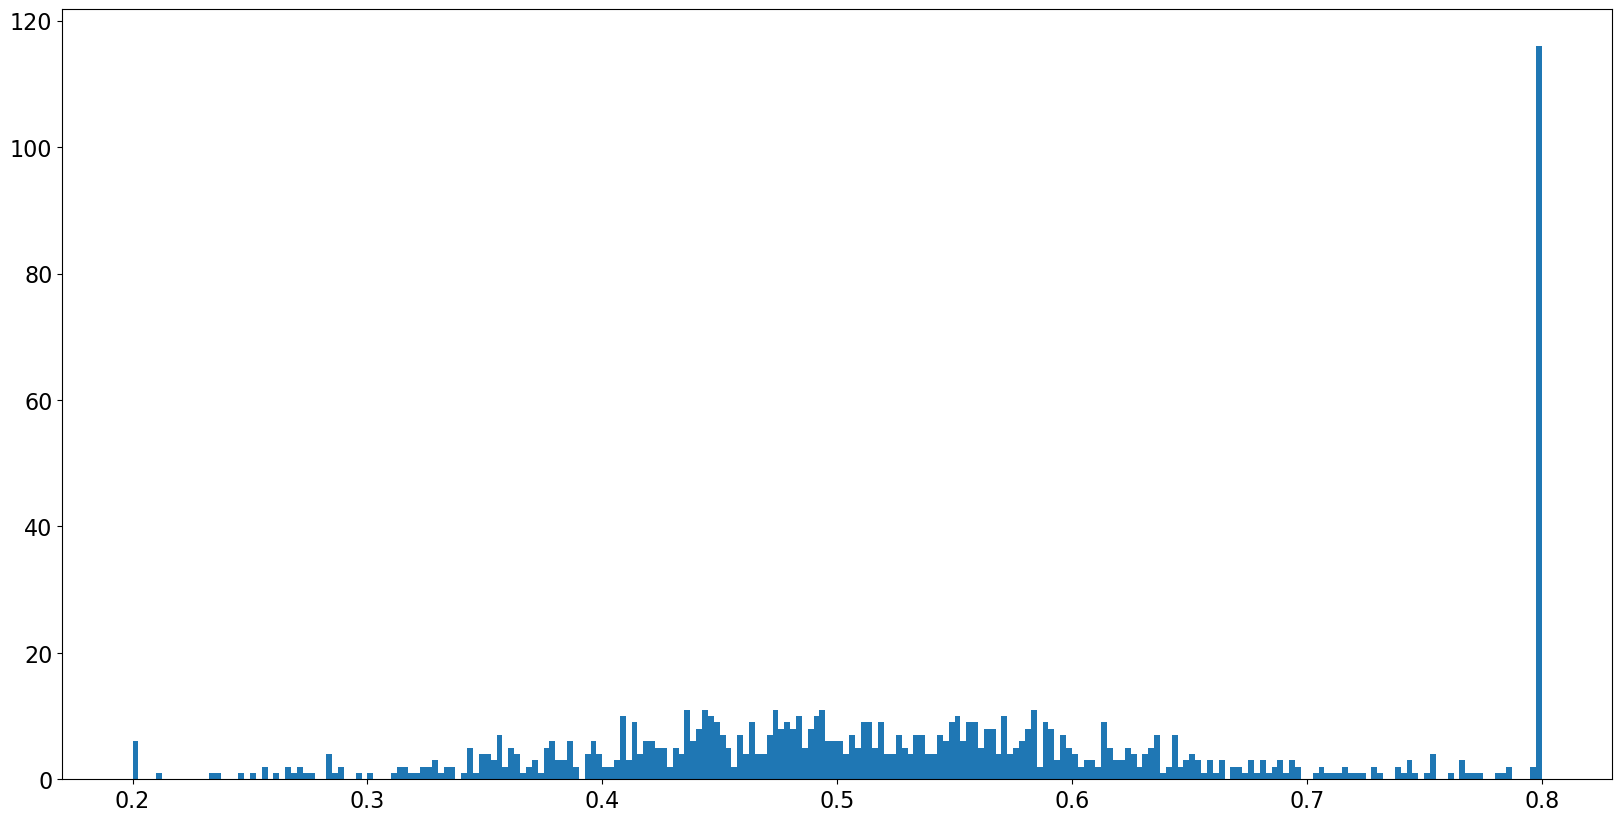

In [14]:
plt.figure(figsize=(20, 10))
counts2, bins2, _ = plt.hist(ks_hr.values(), bins=240)

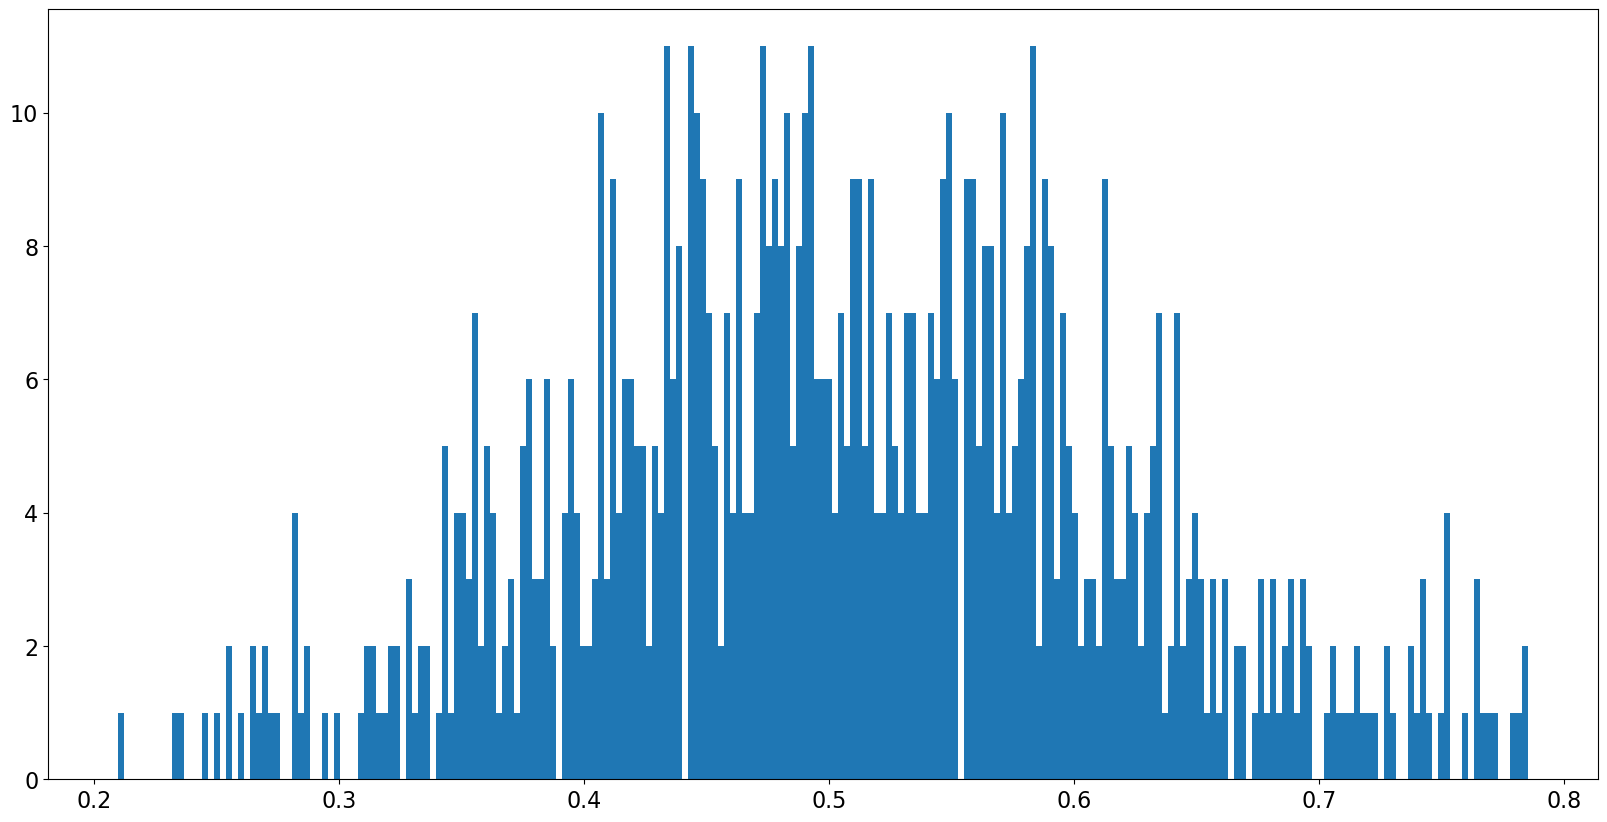

In [15]:
plt.figure(figsize=(20, 10))
counts2, bins2, _ = plt.hist([ x for x in ks_hr.values() if x > 0.20251 and x < 0.795 ], bins=235)

(0.5038633168165113, 0.004680107117480441, 0.10911001953910596)

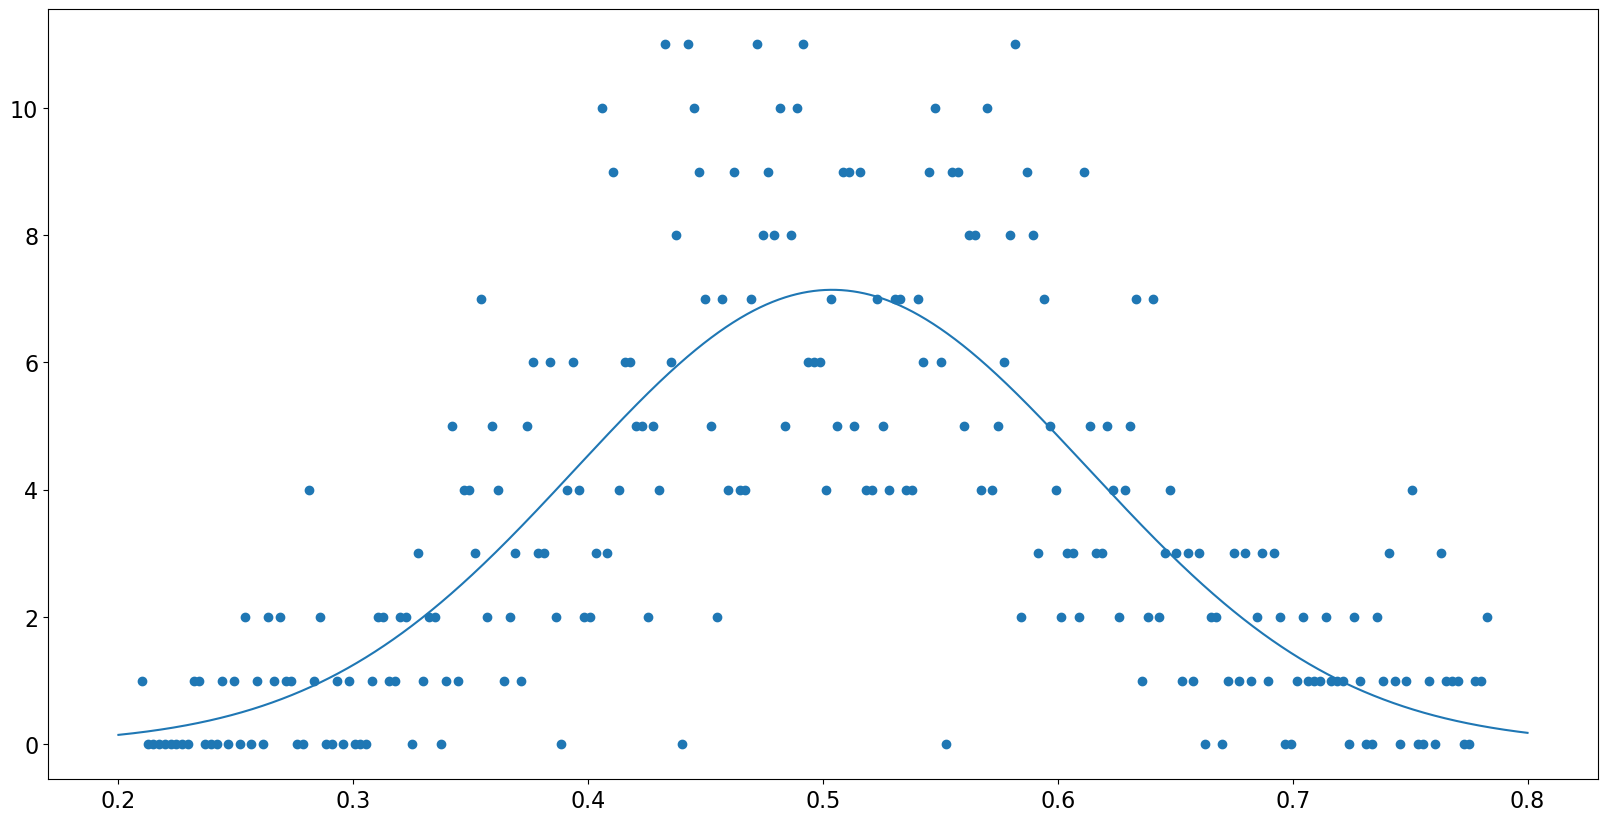

In [18]:
(A_fit, mu_fit, sigma_fit), var_matrix = curve_fit(gaussian, bins2[:-1], counts2, p0=[1, 0, 1])

xs = np.linspace(0.2, 0.8, 2000)
plt.figure(figsize=(20, 10))
plt.scatter(bins2[:-1], counts2)
plt.plot(xs, gaussian(xs, A_fit, mu_fit, sigma_fit))
mu_fit, var_matrix[1, 1]**.5, sigma_fit

In [14]:
ks_adj = {}
qs_adj = {}
for gaia_id in tqdm(DF[:1000][GAIA_ID_COLNAME]):
    min_k, min_rmse, min_q = 100, 100, 100
    gaia_flux = plot_conv_get_gaia(gaia_id=gaia_id)
    if gaia_flux is None:
        continue
    else:
        gaia_flux *= qs_hr[gaia_id]
            
    for k in np.arange(0.2, 0.8, 0.0025):
        rmse, q = plot_conv_k_rms(gaia_flux, gaia_id=gaia_id, k=k)
        if rmse < min_rmse:
            min_rmse = rmse
            min_k = k
            min_q = q
        else:
            break
        
    ks_adj[gaia_id] = min_k
    qs_adj[gaia_id] = min_q

  0%|                                                                                                                                | 0/1000 [00:00<?, ?it/s]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  0%|                                                                                                                    | 1/1000 [01:57<32:43:09, 117.91s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  0%|▏                                                                                                                    | 2/1000 [02:59<23:32:41, 84.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  0%|▎                                                                                                                    | 3/1000 [03:40<17:59:28, 64.96s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  0%|▍                                                                                                                    | 4/1000 [05:19<21:40:53, 78.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  0%|▌                                                                                                                    | 5/1000 [06:35<21:20:43, 77.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  1%|▋                                                                                                                    | 6/1000 [07:36<19:49:31, 71.80s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  1%|▊                                                                                                                    | 7/1000 [09:12<22:02:24, 79.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  1%|▉                                                                                                                    | 8/1000 [10:15<20:29:26, 74.36s/it]

Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  1%|█▎                                                                                                                  | 11/1000 [13:11<17:56:34, 65.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  1%|█▍                                                                                                                  | 12/1000 [13:31<15:15:03, 55.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  1%|█▌                                                                                                                  | 13/1000 [14:26<15:10:43, 55.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  1%|█▌                                                                                                                  | 14/1000 [15:42<16:38:02, 60.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  2%|█▋                                                                                                                  | 15/1000 [18:38<24:55:12, 91.08s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  2%|█▊                                                                                                                  | 16/1000 [18:50<18:56:20, 69.29s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  2%|██                                                                                                                  | 18/1000 [18:56<10:57:50, 40.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  2%|██▏                                                                                                                 | 19/1000 [20:38<15:00:01, 55.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  2%|██▎                                                                                                                 | 20/1000 [22:03<17:03:41, 62.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  2%|██▍                                                                                                                 | 21/1000 [24:59<25:15:35, 92.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  2%|██▌                                                                                                                 | 22/1000 [25:43<21:36:00, 79.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  2%|██▋                                                                                                                | 23/1000 [28:59<30:27:49, 112.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  2%|██▊                                                                                                                | 24/1000 [30:15<27:38:29, 101.96s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  2%|██▉                                                                                                                 | 25/1000 [31:02<23:13:50, 85.77s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  3%|███                                                                                                                 | 26/1000 [32:42<24:21:09, 90.01s/it]

Could not get SDSS data
Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  3%|███▍                                                                                                                | 30/1000 [34:14<12:56:08, 48.01s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  3%|███▋                                                                                                                | 32/1000 [35:18<11:34:47, 43.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  3%|███▊                                                                                                                | 33/1000 [35:51<11:05:20, 41.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  3%|███▉                                                                                                                | 34/1000 [36:59<12:33:26, 46.80s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  4%|████                                                                                                                | 35/1000 [38:16<14:21:40, 53.58s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  4%|████▏                                                                                                               | 36/1000 [41:28<23:25:28, 87.48s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  4%|████▍                                                                                                               | 38/1000 [43:10<19:20:26, 72.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  4%|████▌                                                                                                               | 39/1000 [44:25<19:29:38, 73.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  4%|████▌                                                                                                              | 40/1000 [47:41<27:30:58, 103.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  4%|████▋                                                                                                              | 41/1000 [49:18<27:04:33, 101.64s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  4%|████▊                                                                                                              | 42/1000 [51:20<28:30:49, 107.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  4%|████▉                                                                                                               | 43/1000 [52:38<26:18:34, 98.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  4%|█████                                                                                                               | 44/1000 [54:03<25:13:17, 94.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  4%|█████▏                                                                                                             | 45/1000 [56:17<28:09:44, 106.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  5%|█████▎                                                                                                             | 46/1000 [57:42<26:32:03, 100.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  5%|█████▍                                                                                                              | 47/1000 [58:54<24:19:59, 91.92s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  5%|█████▌                                                                                                            | 49/1000 [1:00:25<18:40:24, 70.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  5%|█████▋                                                                                                            | 50/1000 [1:01:10<16:57:41, 64.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  5%|█████▊                                                                                                            | 51/1000 [1:03:13<20:58:59, 79.60s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  5%|██████                                                                                                            | 53/1000 [1:04:35<16:35:37, 63.08s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  5%|██████▏                                                                                                           | 54/1000 [1:05:41<16:44:46, 63.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  6%|██████▎                                                                                                           | 55/1000 [1:06:27<15:37:05, 59.50s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  6%|██████▍                                                                                                           | 56/1000 [1:08:45<20:59:50, 80.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  6%|██████▍                                                                                                           | 57/1000 [1:10:14<21:35:14, 82.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  6%|██████▌                                                                                                          | 58/1000 [1:13:08<28:17:50, 108.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  6%|██████▋                                                                                                           | 59/1000 [1:14:03<24:16:04, 92.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  6%|██████▊                                                                                                           | 60/1000 [1:15:36<24:18:36, 93.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  6%|██████▉                                                                                                           | 61/1000 [1:16:16<20:11:22, 77.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  6%|███████                                                                                                           | 62/1000 [1:17:48<21:19:04, 81.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  6%|███████▏                                                                                                          | 63/1000 [1:19:52<24:33:56, 94.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  6%|███████▎                                                                                                          | 64/1000 [1:20:46<21:25:13, 82.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  6%|███████▍                                                                                                          | 65/1000 [1:22:42<23:58:35, 92.32s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  7%|███████▌                                                                                                          | 66/1000 [1:24:21<24:27:38, 94.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  7%|███████▋                                                                                                          | 67/1000 [1:25:17<21:30:04, 82.96s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  7%|███████▊                                                                                                          | 69/1000 [1:27:08<18:09:18, 70.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  7%|███████▉                                                                                                          | 70/1000 [1:28:16<17:58:48, 69.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  7%|████████                                                                                                          | 71/1000 [1:29:44<19:12:36, 74.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  7%|████████▏                                                                                                         | 72/1000 [1:31:32<21:33:30, 83.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  7%|████████▎                                                                                                         | 73/1000 [1:33:38<24:34:35, 95.44s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  8%|████████▌                                                                                                         | 75/1000 [1:35:45<20:53:56, 81.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  8%|████████▋                                                                                                         | 76/1000 [1:37:02<20:34:58, 80.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  8%|████████▊                                                                                                         | 77/1000 [1:38:58<22:53:53, 89.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  8%|████████▊                                                                                                        | 78/1000 [1:41:12<25:56:39, 101.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  8%|█████████                                                                                                         | 79/1000 [1:42:48<25:33:09, 99.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  8%|█████████                                                                                                         | 80/1000 [1:43:32<21:29:21, 84.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  8%|█████████▏                                                                                                        | 81/1000 [1:44:36<19:59:47, 78.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  8%|█████████▎                                                                                                        | 82/1000 [1:46:27<22:22:58, 87.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  8%|█████████▍                                                                                                        | 83/1000 [1:47:56<22:27:39, 88.18s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  8%|█████████▌                                                                                                        | 84/1000 [1:49:42<23:47:41, 93.52s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  8%|█████████▋                                                                                                        | 85/1000 [1:51:12<23:29:47, 92.45s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  9%|█████████▉                                                                                                        | 87/1000 [1:53:11<19:35:22, 77.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  9%|██████████                                                                                                        | 88/1000 [1:54:14<18:40:45, 73.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  9%|██████████▏                                                                                                       | 89/1000 [1:55:24<18:26:49, 72.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  9%|██████████▎                                                                                                       | 90/1000 [1:56:50<19:15:45, 76.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  9%|██████████▎                                                                                                       | 91/1000 [1:58:57<22:51:58, 90.56s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  9%|██████████▍                                                                                                       | 92/1000 [2:00:23<22:29:08, 89.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  9%|██████████▌                                                                                                      | 93/1000 [2:02:50<26:41:17, 105.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


  9%|██████████▋                                                                                                       | 94/1000 [2:03:58<23:53:17, 94.92s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 10%|██████████▋                                                                                                      | 95/1000 [2:06:03<26:04:15, 103.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 10%|██████████▉                                                                                                       | 96/1000 [2:07:07<23:07:10, 92.07s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 10%|███████████▏                                                                                                      | 98/1000 [2:09:05<19:16:09, 76.91s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 10%|███████████▎                                                                                                      | 99/1000 [2:10:59<21:32:48, 86.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 10%|███████████▎                                                                                                     | 100/1000 [2:12:27<21:38:25, 86.56s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 10%|███████████▎                                                                                                    | 101/1000 [2:15:09<26:41:57, 106.92s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 10%|███████████▌                                                                                                     | 102/1000 [2:16:26<24:34:53, 98.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 10%|███████████▌                                                                                                    | 103/1000 [2:18:27<26:07:35, 104.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 10%|███████████▋                                                                                                    | 104/1000 [2:20:50<28:51:07, 115.92s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 11%|███████████▉                                                                                                     | 106/1000 [2:22:43<22:06:55, 89.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 11%|████████████                                                                                                     | 107/1000 [2:24:38<23:40:21, 95.43s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 11%|████████████▏                                                                                                    | 108/1000 [2:26:06<23:12:05, 93.64s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 11%|████████████▎                                                                                                    | 109/1000 [2:27:27<22:19:47, 90.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 11%|████████████▍                                                                                                    | 110/1000 [2:27:34<16:32:56, 66.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 11%|████████████▌                                                                                                    | 111/1000 [2:28:44<16:45:42, 67.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 11%|████████████▋                                                                                                    | 112/1000 [2:30:21<18:47:57, 76.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 11%|████████████▋                                                                                                   | 113/1000 [2:33:17<25:58:08, 105.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 11%|████████████▊                                                                                                   | 114/1000 [2:36:13<31:01:50, 126.08s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 12%|████████████▉                                                                                                   | 115/1000 [2:38:20<31:04:24, 126.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 12%|████████████▉                                                                                                   | 116/1000 [2:40:34<31:35:11, 128.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 12%|█████████████                                                                                                   | 117/1000 [2:41:39<26:53:42, 109.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 12%|█████████████▏                                                                                                  | 118/1000 [2:42:59<24:42:37, 100.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 12%|█████████████▎                                                                                                  | 119/1000 [2:45:25<27:59:52, 114.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 12%|█████████████▍                                                                                                  | 120/1000 [2:46:52<25:55:35, 106.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 12%|█████████████▋                                                                                                   | 121/1000 [2:47:16<19:54:07, 81.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 12%|█████████████▊                                                                                                   | 122/1000 [2:48:39<19:59:22, 81.96s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 12%|█████████████▊                                                                                                  | 123/1000 [2:51:33<26:44:37, 109.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 12%|█████████████▉                                                                                                  | 124/1000 [2:53:12<25:53:05, 106.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 12%|██████████████▏                                                                                                  | 125/1000 [2:54:21<23:06:07, 95.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 13%|██████████████▏                                                                                                  | 126/1000 [2:56:05<23:47:37, 98.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 13%|██████████████▏                                                                                                 | 127/1000 [2:58:01<25:02:49, 103.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 13%|██████████████▎                                                                                                 | 128/1000 [2:59:40<24:40:51, 101.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 13%|██████████████▍                                                                                                 | 129/1000 [3:02:36<30:02:44, 124.18s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 13%|██████████████▌                                                                                                 | 130/1000 [3:04:27<29:03:02, 120.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 13%|██████████████▋                                                                                                 | 131/1000 [3:06:42<30:07:20, 124.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 13%|██████████████▊                                                                                                 | 132/1000 [3:07:45<25:34:28, 106.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 13%|███████████████                                                                                                  | 133/1000 [3:09:10<24:02:19, 99.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 13%|███████████████                                                                                                 | 134/1000 [3:11:16<25:55:46, 107.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 14%|███████████████                                                                                                 | 135/1000 [3:12:39<24:07:28, 100.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 14%|███████████████▏                                                                                                | 136/1000 [3:15:08<27:32:55, 114.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 14%|███████████████▎                                                                                                | 137/1000 [3:17:26<29:12:49, 121.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 14%|███████████████▍                                                                                                | 138/1000 [3:20:21<32:58:05, 137.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 14%|███████████████▌                                                                                                | 139/1000 [3:23:16<35:35:14, 148.80s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 14%|███████████████▋                                                                                                | 140/1000 [3:25:04<32:40:14, 136.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 14%|███████████████▊                                                                                                | 141/1000 [3:26:51<30:28:29, 127.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 14%|███████████████▉                                                                                                | 142/1000 [3:28:17<27:27:04, 115.18s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 14%|████████████████                                                                                                | 143/1000 [3:29:56<26:15:56, 110.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 14%|████████████████▎                                                                                                | 144/1000 [3:31:04<23:14:11, 97.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 14%|████████████████▏                                                                                               | 145/1000 [3:33:24<26:12:31, 110.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 15%|████████████████▎                                                                                               | 146/1000 [3:36:14<30:26:51, 128.35s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 15%|████████████████▋                                                                                                | 148/1000 [3:38:16<23:00:37, 97.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 15%|████████████████▊                                                                                                | 149/1000 [3:39:54<23:00:51, 97.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 15%|████████████████▊                                                                                               | 150/1000 [3:42:49<27:48:56, 117.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 15%|████████████████▉                                                                                               | 151/1000 [3:44:49<27:55:15, 118.39s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 15%|█████████████████▎                                                                                               | 153/1000 [3:46:07<19:40:17, 83.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 15%|█████████████████▍                                                                                               | 154/1000 [3:47:02<18:03:39, 76.86s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 16%|█████████████████▋                                                                                               | 156/1000 [3:48:42<15:27:59, 65.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 16%|█████████████████▋                                                                                               | 157/1000 [3:51:04<19:25:46, 82.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 16%|█████████████████▊                                                                                               | 158/1000 [3:52:17<18:49:33, 80.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 16%|█████████████████▉                                                                                               | 159/1000 [3:53:21<17:50:34, 76.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 16%|██████████████████                                                                                               | 160/1000 [3:54:46<18:19:55, 78.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 16%|██████████████████▏                                                                                              | 161/1000 [3:56:06<18:23:59, 78.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 16%|██████████████████▎                                                                                              | 162/1000 [3:57:21<18:08:27, 77.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 16%|██████████████████▍                                                                                              | 163/1000 [3:58:52<18:59:40, 81.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 16%|██████████████████▌                                                                                              | 164/1000 [4:00:01<18:04:58, 77.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 16%|██████████████████▋                                                                                              | 165/1000 [4:01:40<19:32:14, 84.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 17%|██████████████████▊                                                                                              | 166/1000 [4:02:58<19:04:31, 82.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 17%|██████████████████▋                                                                                             | 167/1000 [4:05:51<25:17:58, 109.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 17%|██████████████████▊                                                                                             | 168/1000 [4:07:34<24:47:37, 107.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 17%|██████████████████▉                                                                                             | 169/1000 [4:09:35<25:44:58, 111.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 17%|███████████████████                                                                                             | 170/1000 [4:11:38<26:28:51, 114.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 17%|███████████████████▏                                                                                            | 171/1000 [4:13:03<24:22:47, 105.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 17%|███████████████████▎                                                                                            | 172/1000 [4:15:05<25:27:17, 110.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 17%|███████████████████▍                                                                                            | 173/1000 [4:16:25<23:22:33, 101.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 17%|███████████████████▋                                                                                             | 174/1000 [4:17:50<22:11:24, 96.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 18%|███████████████████▊                                                                                             | 175/1000 [4:19:27<22:11:02, 96.80s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 18%|███████████████████▉                                                                                             | 176/1000 [4:21:00<21:50:46, 95.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 18%|███████████████████▊                                                                                            | 177/1000 [4:22:57<23:20:57, 102.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 18%|████████████████████                                                                                             | 178/1000 [4:24:11<21:21:50, 93.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 18%|████████████████████                                                                                            | 179/1000 [4:27:26<28:14:57, 123.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 18%|████████████████████▏                                                                                           | 180/1000 [4:30:20<31:41:32, 139.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 18%|████████████████████▎                                                                                           | 181/1000 [4:33:11<33:47:28, 148.53s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 18%|████████████████████▍                                                                                           | 182/1000 [4:35:32<33:16:28, 146.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 18%|████████████████████▍                                                                                           | 183/1000 [4:36:40<27:54:02, 122.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 18%|████████████████████▌                                                                                           | 184/1000 [4:38:10<25:35:13, 112.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 18%|████████████████████▋                                                                                           | 185/1000 [4:40:02<25:29:56, 112.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 19%|████████████████████▊                                                                                           | 186/1000 [4:41:58<25:41:18, 113.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 19%|████████████████████▉                                                                                           | 187/1000 [4:43:36<24:38:17, 109.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 19%|█████████████████████                                                                                           | 188/1000 [4:45:11<23:38:11, 104.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 19%|█████████████████████▏                                                                                          | 189/1000 [4:46:43<22:44:17, 100.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 19%|█████████████████████▍                                                                                           | 190/1000 [4:48:13<21:59:28, 97.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 19%|█████████████████████▌                                                                                           | 191/1000 [4:49:50<21:53:59, 97.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 19%|█████████████████████▋                                                                                           | 192/1000 [4:50:43<18:53:04, 84.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 19%|█████████████████████▊                                                                                           | 193/1000 [4:52:02<18:31:38, 82.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 19%|█████████████████████▋                                                                                          | 194/1000 [4:54:56<24:35:11, 109.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 20%|██████████████████████                                                                                           | 195/1000 [4:56:09<22:05:46, 98.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 20%|██████████████████████▏                                                                                          | 196/1000 [4:57:40<21:31:51, 96.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 20%|██████████████████████▎                                                                                          | 197/1000 [4:58:15<17:24:54, 78.08s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 20%|██████████████████████▎                                                                                          | 198/1000 [5:00:18<20:25:22, 91.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 20%|██████████████████████▎                                                                                         | 199/1000 [5:02:25<22:44:44, 102.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 20%|██████████████████████▌                                                                                          | 200/1000 [5:03:43<21:07:28, 95.06s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 20%|██████████████████████▊                                                                                          | 202/1000 [5:06:55<21:08:42, 95.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 20%|██████████████████████▉                                                                                          | 203/1000 [5:07:59<19:24:46, 87.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 20%|██████████████████████▊                                                                                         | 204/1000 [5:11:12<25:27:34, 115.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 20%|██████████████████████▉                                                                                         | 205/1000 [5:12:20<22:37:16, 102.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 21%|███████████████████████▎                                                                                         | 206/1000 [5:13:52<21:57:10, 99.54s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 21%|███████████████████████▌                                                                                         | 208/1000 [5:15:37<17:15:36, 78.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 21%|███████████████████████▌                                                                                         | 209/1000 [5:16:59<17:27:54, 79.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 21%|███████████████████████▋                                                                                         | 210/1000 [5:18:21<17:33:05, 79.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 21%|███████████████████████▊                                                                                         | 211/1000 [5:19:05<15:24:19, 70.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 21%|███████████████████████▉                                                                                         | 212/1000 [5:20:56<17:52:28, 81.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 21%|███████████████████████▊                                                                                        | 213/1000 [5:23:51<23:37:46, 108.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 21%|███████████████████████▉                                                                                        | 214/1000 [5:25:48<24:09:16, 110.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 22%|████████████████████████▎                                                                                        | 215/1000 [5:26:44<20:40:35, 94.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 22%|████████████████████████▍                                                                                        | 216/1000 [5:28:12<20:11:18, 92.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 22%|████████████████████████▌                                                                                        | 217/1000 [5:29:47<20:18:19, 93.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 22%|████████████████████████▋                                                                                        | 218/1000 [5:31:32<21:04:11, 97.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 22%|████████████████████████▋                                                                                        | 219/1000 [5:32:38<18:59:24, 87.53s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 22%|████████████████████████▊                                                                                        | 220/1000 [5:33:43<17:33:30, 81.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 22%|████████████████████████▊                                                                                       | 221/1000 [5:36:11<21:50:54, 100.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 22%|████████████████████████▊                                                                                       | 222/1000 [5:38:04<22:36:59, 104.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 22%|█████████████████████████▏                                                                                       | 223/1000 [5:39:25<21:03:12, 97.54s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 22%|█████████████████████████▎                                                                                       | 224/1000 [5:40:51<20:14:47, 93.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 22%|█████████████████████████▏                                                                                      | 225/1000 [5:43:45<25:23:44, 117.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 23%|█████████████████████████▌                                                                                       | 226/1000 [5:44:37<21:08:37, 98.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 23%|█████████████████████████▋                                                                                       | 227/1000 [5:45:36<18:31:54, 86.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 23%|█████████████████████████▊                                                                                       | 228/1000 [5:46:52<17:52:16, 83.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 23%|█████████████████████████▉                                                                                       | 229/1000 [5:48:38<19:18:10, 90.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 23%|█████████████████████████▉                                                                                       | 230/1000 [5:50:29<20:37:55, 96.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 23%|██████████████████████████                                                                                       | 231/1000 [5:51:02<16:30:44, 77.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 23%|██████████████████████████▏                                                                                      | 232/1000 [5:53:16<20:09:40, 94.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 23%|██████████████████████████                                                                                      | 233/1000 [5:55:23<22:11:53, 104.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 23%|██████████████████████████▏                                                                                     | 234/1000 [5:57:24<23:11:42, 109.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 24%|██████████████████████████▎                                                                                     | 235/1000 [5:59:26<24:01:51, 113.09s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 24%|██████████████████████████▊                                                                                      | 237/1000 [6:00:57<17:21:31, 81.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 24%|██████████████████████████▉                                                                                      | 238/1000 [6:02:34<18:06:36, 85.56s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 24%|███████████████████████████                                                                                      | 239/1000 [6:03:38<16:55:54, 80.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 24%|██████████████████████████▉                                                                                     | 240/1000 [6:06:20<21:34:07, 102.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 24%|███████████████████████████▏                                                                                     | 241/1000 [6:07:39<20:10:24, 95.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 24%|███████████████████████████▎                                                                                     | 242/1000 [6:08:42<18:12:31, 86.48s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 24%|███████████████████████████▍                                                                                     | 243/1000 [6:09:43<16:38:20, 79.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 24%|███████████████████████████▌                                                                                     | 244/1000 [6:11:32<18:24:27, 87.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 24%|███████████████████████████▍                                                                                    | 245/1000 [6:14:46<25:00:38, 119.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 25%|███████████████████████████▌                                                                                    | 246/1000 [6:16:12<22:51:51, 109.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 25%|███████████████████████████▋                                                                                    | 247/1000 [6:18:02<22:55:28, 109.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 25%|████████████████████████████                                                                                     | 248/1000 [6:19:16<20:40:22, 98.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 25%|███████████████████████████▉                                                                                    | 249/1000 [6:21:48<23:58:11, 114.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 25%|████████████████████████████                                                                                    | 250/1000 [6:23:31<23:08:39, 111.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 25%|████████████████████████████                                                                                    | 251/1000 [6:25:22<23:06:57, 111.11s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 25%|████████████████████████████▏                                                                                   | 252/1000 [6:26:40<21:01:51, 101.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 25%|████████████████████████████▌                                                                                    | 253/1000 [6:27:24<17:25:51, 84.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 25%|████████████████████████████▍                                                                                   | 254/1000 [6:30:21<23:13:41, 112.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 26%|████████████████████████████▌                                                                                   | 255/1000 [6:31:52<21:50:34, 105.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 26%|████████████████████████████▋                                                                                   | 256/1000 [6:34:03<23:25:54, 113.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 26%|█████████████████████████████                                                                                    | 257/1000 [6:35:02<20:00:56, 96.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 26%|████████████████████████████▉                                                                                   | 258/1000 [6:37:00<21:18:06, 103.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 26%|█████████████████████████████                                                                                   | 259/1000 [6:39:55<25:41:25, 124.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 26%|█████████████████████████████                                                                                   | 260/1000 [6:41:53<25:15:06, 122.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 26%|█████████████████████████████▏                                                                                  | 261/1000 [6:42:59<21:40:35, 105.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 26%|█████████████████████████████▎                                                                                  | 262/1000 [6:44:37<21:11:40, 103.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 26%|█████████████████████████████▍                                                                                  | 263/1000 [6:46:13<20:41:57, 101.11s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 26%|█████████████████████████████▊                                                                                   | 264/1000 [6:47:20<18:37:35, 91.11s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 26%|█████████████████████████████▉                                                                                   | 265/1000 [6:48:11<16:07:53, 79.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 27%|██████████████████████████████                                                                                   | 266/1000 [6:49:21<15:34:00, 76.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 27%|██████████████████████████████▏                                                                                  | 267/1000 [6:50:49<16:15:26, 79.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 27%|██████████████████████████████▎                                                                                  | 268/1000 [6:52:18<16:46:30, 82.50s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 27%|██████████████████████████████▏                                                                                 | 269/1000 [6:55:01<21:38:35, 106.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 27%|██████████████████████████████▏                                                                                 | 270/1000 [6:56:42<21:15:38, 104.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 27%|██████████████████████████████▎                                                                                 | 271/1000 [6:58:21<20:52:14, 103.07s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 27%|██████████████████████████████▊                                                                                  | 273/1000 [6:59:44<15:05:45, 74.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 27%|██████████████████████████████▉                                                                                  | 274/1000 [7:02:32<19:45:29, 97.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 28%|███████████████████████████████                                                                                  | 275/1000 [7:04:18<20:07:36, 99.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 28%|███████████████████████████████▏                                                                                 | 276/1000 [7:05:54<19:52:00, 98.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 28%|███████████████████████████████▎                                                                                 | 277/1000 [7:07:18<19:00:51, 94.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 28%|███████████████████████████████▍                                                                                 | 278/1000 [7:08:45<18:33:43, 92.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 28%|███████████████████████████████▌                                                                                 | 279/1000 [7:10:30<19:16:17, 96.22s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 28%|███████████████████████████████▊                                                                                 | 281/1000 [7:13:26<18:28:19, 92.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 28%|███████████████████████████████▊                                                                                 | 282/1000 [7:15:20<19:30:36, 97.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 28%|███████████████████████████████▉                                                                                 | 283/1000 [7:16:18<17:25:22, 87.48s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 28%|████████████████████████████████                                                                                 | 284/1000 [7:18:11<18:44:57, 94.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 28%|████████████████████████████████▏                                                                                | 285/1000 [7:20:00<19:33:11, 98.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 29%|████████████████████████████████▎                                                                                | 286/1000 [7:20:51<16:50:20, 84.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 29%|████████████████████████████████▍                                                                                | 287/1000 [7:21:38<14:38:28, 73.92s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 29%|████████████████████████████████▌                                                                                | 288/1000 [7:23:20<16:14:51, 82.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 29%|████████████████████████████████▋                                                                                | 289/1000 [7:25:02<17:22:26, 87.97s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 29%|████████████████████████████████▉                                                                                | 291/1000 [7:27:11<15:12:17, 77.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 29%|████████████████████████████████▉                                                                                | 292/1000 [7:28:20<14:48:14, 75.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 29%|█████████████████████████████████                                                                                | 293/1000 [7:29:25<14:15:55, 72.64s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 29%|█████████████████████████████████▏                                                                               | 294/1000 [7:31:19<16:25:21, 83.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 30%|█████████████████████████████████▎                                                                               | 295/1000 [7:32:14<14:48:35, 75.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 30%|█████████████████████████████████▍                                                                               | 296/1000 [7:33:34<15:02:08, 76.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 30%|█████████████████████████████████▌                                                                               | 297/1000 [7:35:02<15:41:17, 80.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 30%|█████████████████████████████████▋                                                                               | 298/1000 [7:36:29<16:00:04, 82.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 30%|█████████████████████████████████▊                                                                               | 299/1000 [7:38:44<19:01:52, 97.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 30%|█████████████████████████████████▉                                                                               | 300/1000 [7:39:31<16:03:32, 82.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 30%|██████████████████████████████████                                                                               | 301/1000 [7:41:18<17:28:26, 89.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 30%|██████████████████████████████████▏                                                                              | 302/1000 [7:42:37<16:49:10, 86.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 30%|█████████████████████████████████▉                                                                              | 303/1000 [7:44:59<19:58:32, 103.17s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 30%|██████████████████████████████████▍                                                                              | 305/1000 [7:46:10<13:53:20, 71.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 31%|██████████████████████████████████▌                                                                              | 306/1000 [7:47:46<15:03:45, 78.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 31%|██████████████████████████████████▋                                                                              | 307/1000 [7:50:06<18:07:37, 94.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 31%|██████████████████████████████████▊                                                                              | 308/1000 [7:51:38<17:59:50, 93.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 31%|██████████████████████████████████▌                                                                             | 309/1000 [7:54:02<20:41:05, 107.77s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 31%|██████████████████████████████████▋                                                                             | 310/1000 [7:56:05<21:28:48, 112.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 31%|██████████████████████████████████▊                                                                             | 311/1000 [7:57:34<20:09:33, 105.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 31%|██████████████████████████████████▉                                                                             | 312/1000 [7:59:35<20:59:24, 109.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 31%|███████████████████████████████████▎                                                                             | 313/1000 [8:00:45<18:45:36, 98.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 31%|███████████████████████████████████▏                                                                            | 314/1000 [8:03:57<24:00:38, 126.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 32%|███████████████████████████████████▎                                                                            | 315/1000 [8:07:16<28:07:16, 147.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 32%|███████████████████████████████████▍                                                                            | 316/1000 [8:08:59<25:29:42, 134.18s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 32%|███████████████████████████████████▌                                                                            | 317/1000 [8:10:52<24:17:18, 128.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 32%|███████████████████████████████████▉                                                                             | 318/1000 [8:11:01<17:30:24, 92.41s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 32%|████████████████████████████████████▏                                                                            | 320/1000 [8:13:13<15:08:25, 80.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 32%|████████████████████████████████████▎                                                                            | 321/1000 [8:14:24<14:43:12, 78.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 32%|████████████████████████████████████                                                                            | 322/1000 [8:17:21<19:33:53, 103.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 32%|████████████████████████████████████▏                                                                           | 323/1000 [8:19:07<19:37:28, 104.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 32%|████████████████████████████████████▌                                                                            | 324/1000 [8:20:16<17:42:52, 94.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 32%|████████████████████████████████████▋                                                                            | 325/1000 [8:21:04<15:13:13, 81.18s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 33%|████████████████████████████████████▊                                                                            | 326/1000 [8:22:50<16:32:40, 88.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 33%|████████████████████████████████████▉                                                                            | 327/1000 [8:23:47<14:48:04, 79.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 33%|█████████████████████████████████████                                                                            | 328/1000 [8:25:27<15:56:47, 85.43s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 33%|█████████████████████████████████████▏                                                                           | 329/1000 [8:27:07<16:44:43, 89.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 33%|█████████████████████████████████████▎                                                                           | 330/1000 [8:28:09<15:09:36, 81.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 33%|█████████████████████████████████████▍                                                                           | 331/1000 [8:30:01<16:49:08, 90.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 33%|█████████████████████████████████████▌                                                                           | 332/1000 [8:31:39<17:13:22, 92.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 33%|█████████████████████████████████████▋                                                                           | 333/1000 [8:33:08<16:58:00, 91.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 33%|█████████████████████████████████████▋                                                                           | 334/1000 [8:34:42<17:03:49, 92.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 34%|█████████████████████████████████████▊                                                                           | 335/1000 [8:36:18<17:17:18, 93.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 34%|█████████████████████████████████████▉                                                                           | 336/1000 [8:37:24<15:43:20, 85.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 34%|██████████████████████████████████████                                                                           | 337/1000 [8:39:16<17:10:40, 93.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 34%|█████████████████████████████████████▊                                                                          | 338/1000 [8:41:37<19:46:40, 107.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 34%|█████████████████████████████████████▉                                                                          | 339/1000 [8:43:22<19:35:31, 106.70s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 34%|██████████████████████████████████████▌                                                                          | 341/1000 [8:44:18<12:54:55, 70.56s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 34%|██████████████████████████████████████▋                                                                          | 342/1000 [8:44:27<10:06:30, 55.30s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 34%|███████████████████████████████████████▏                                                                          | 344/1000 [8:45:41<8:41:17, 47.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 34%|██████████████████████████████████████▉                                                                          | 345/1000 [8:47:44<11:48:14, 64.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 35%|███████████████████████████████████████                                                                          | 346/1000 [8:50:35<16:32:02, 91.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 35%|███████████████████████████████████████▏                                                                         | 347/1000 [8:52:04<16:24:40, 90.48s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 35%|██████████████████████████████████████▉                                                                         | 348/1000 [8:54:57<20:24:00, 112.64s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 35%|███████████████████████████████████████                                                                         | 349/1000 [8:56:33<19:34:07, 108.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 35%|███████████████████████████████████████▏                                                                        | 350/1000 [8:58:17<19:19:08, 107.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 35%|███████████████████████████████████████▋                                                                         | 351/1000 [8:59:38<17:55:35, 99.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 35%|███████████████████████████████████████▍                                                                        | 352/1000 [9:02:08<20:32:48, 114.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 35%|███████████████████████████████████████▉                                                                         | 353/1000 [9:02:56<16:59:36, 94.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 35%|████████████████████████████████████████                                                                         | 354/1000 [9:04:37<17:18:51, 96.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 36%|███████████████████████████████████████▊                                                                        | 355/1000 [9:06:47<19:07:01, 106.70s/it]

Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 36%|████████████████████████████████████████▍                                                                        | 358/1000 [9:08:39<12:03:56, 67.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 36%|████████████████████████████████████████▌                                                                        | 359/1000 [9:10:23<13:24:55, 75.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 36%|████████████████████████████████████████▋                                                                        | 360/1000 [9:11:45<13:41:53, 77.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 36%|████████████████████████████████████████▊                                                                        | 361/1000 [9:13:25<14:39:50, 82.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 36%|████████████████████████████████████████▉                                                                        | 362/1000 [9:15:02<15:19:46, 86.50s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 36%|█████████████████████████████████████████                                                                        | 363/1000 [9:16:42<15:56:51, 90.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 36%|█████████████████████████████████████████▏                                                                       | 364/1000 [9:18:09<15:45:04, 89.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 36%|█████████████████████████████████████████▏                                                                       | 365/1000 [9:19:10<14:19:50, 81.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 37%|████████████████████████████████████████▉                                                                       | 366/1000 [9:22:03<18:58:05, 107.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 37%|█████████████████████████████████████████                                                                       | 367/1000 [9:24:20<20:26:23, 116.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 37%|█████████████████████████████████████████▏                                                                      | 368/1000 [9:27:30<24:14:18, 138.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 37%|█████████████████████████████████████████▎                                                                      | 369/1000 [9:29:36<23:33:19, 134.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 37%|█████████████████████████████████████████▍                                                                      | 370/1000 [9:31:39<22:57:47, 131.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 37%|█████████████████████████████████████████▌                                                                      | 371/1000 [9:34:27<24:49:50, 142.12s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 37%|█████████████████████████████████████████▋                                                                      | 372/1000 [9:35:45<21:26:32, 122.92s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 37%|█████████████████████████████████████████▊                                                                      | 373/1000 [9:36:57<18:44:31, 107.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 37%|██████████████████████████████████████████▎                                                                      | 374/1000 [9:37:42<15:29:08, 89.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 38%|██████████████████████████████████████████▍                                                                      | 375/1000 [9:39:01<14:56:23, 86.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 38%|██████████████████████████████████████████▍                                                                      | 376/1000 [9:40:07<13:50:13, 79.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 38%|██████████████████████████████████████████▏                                                                     | 377/1000 [9:43:18<19:36:13, 113.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 38%|██████████████████████████████████████████▎                                                                     | 378/1000 [9:44:38<17:52:14, 103.43s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 38%|██████████████████████████████████████████▊                                                                      | 379/1000 [9:46:01<16:44:43, 97.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 38%|██████████████████████████████████████████▌                                                                     | 380/1000 [9:47:49<17:16:32, 100.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 38%|██████████████████████████████████████████▋                                                                     | 381/1000 [9:49:34<17:30:20, 101.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 38%|██████████████████████████████████████████▊                                                                     | 382/1000 [9:52:18<20:41:05, 120.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 38%|██████████████████████████████████████████▉                                                                     | 383/1000 [9:53:51<19:13:53, 112.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 38%|███████████████████████████████████████████                                                                     | 384/1000 [9:55:30<18:32:51, 108.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 38%|███████████████████████████████████████████                                                                     | 385/1000 [9:57:20<18:34:26, 108.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 39%|███████████████████████████████████████████▏                                                                    | 386/1000 [9:59:17<18:58:14, 111.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 39%|██████████████████████████████████████████▉                                                                    | 387/1000 [10:00:37<17:20:19, 101.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 39%|███████████████████████████████████████████                                                                    | 388/1000 [10:02:39<18:21:11, 107.96s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 39%|███████████████████████████████████████████▋                                                                    | 390/1000 [10:04:49<14:56:03, 88.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 39%|███████████████████████████████████████████▊                                                                    | 391/1000 [10:06:05<14:23:19, 85.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 39%|███████████████████████████████████████████▌                                                                   | 392/1000 [10:08:51<17:57:04, 106.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 39%|███████████████████████████████████████████▌                                                                   | 393/1000 [10:10:35<17:48:10, 105.59s/it]

calibrating gaia...
[Errno 104] Connection reset by peer
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 39%|████████████████████████████████████████████▏                                                                   | 394/1000 [10:11:49<16:19:17, 96.96s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 40%|███████████████████████████████████████████▊                                                                   | 395/1000 [10:14:11<18:26:47, 109.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 40%|████████████████████████████████████████████▎                                                                   | 396/1000 [10:14:54<15:09:21, 90.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 40%|████████████████████████████████████████████▍                                                                   | 397/1000 [10:16:46<16:12:02, 96.72s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 40%|████████████████████████████████████████████▋                                                                   | 399/1000 [10:18:09<11:56:46, 71.56s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 40%|████████████████████████████████████████████▊                                                                   | 400/1000 [10:20:05<13:43:14, 82.32s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 40%|████████████████████████████████████████████▉                                                                   | 401/1000 [10:22:01<15:11:06, 91.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 40%|████████████████████████████████████████████▌                                                                  | 402/1000 [10:24:19<17:15:16, 103.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 40%|████████████████████████████████████████████▋                                                                  | 403/1000 [10:25:56<16:53:14, 101.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 40%|████████████████████████████████████████████▊                                                                  | 404/1000 [10:28:49<20:13:06, 122.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 40%|█████████████████████████████████████████████▎                                                                  | 405/1000 [10:29:03<15:00:11, 90.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 41%|█████████████████████████████████████████████▍                                                                  | 406/1000 [10:30:04<13:34:52, 82.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 41%|█████████████████████████████████████████████▌                                                                  | 407/1000 [10:32:02<15:17:24, 92.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 41%|█████████████████████████████████████████████▋                                                                  | 408/1000 [10:33:28<14:55:01, 90.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 41%|█████████████████████████████████████████████▊                                                                  | 409/1000 [10:34:52<14:34:22, 88.77s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 41%|█████████████████████████████████████████████▉                                                                  | 410/1000 [10:36:35<15:15:16, 93.08s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 41%|██████████████████████████████████████████████                                                                  | 411/1000 [10:37:48<14:12:55, 86.89s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 41%|██████████████████████████████████████████████▎                                                                 | 413/1000 [10:39:10<10:44:13, 65.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 41%|██████████████████████████████████████████████▎                                                                 | 414/1000 [10:39:59<10:01:36, 61.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 42%|██████████████████████████████████████████████▍                                                                 | 415/1000 [10:41:29<11:13:04, 69.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 42%|██████████████████████████████████████████████▌                                                                 | 416/1000 [10:43:48<14:16:13, 87.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 42%|██████████████████████████████████████████████▋                                                                 | 417/1000 [10:44:59<13:30:02, 83.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 42%|██████████████████████████████████████████████▊                                                                 | 418/1000 [10:46:15<13:07:53, 81.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 42%|██████████████████████████████████████████████▉                                                                 | 419/1000 [10:48:06<14:28:42, 89.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 42%|███████████████████████████████████████████████                                                                 | 420/1000 [10:49:52<15:15:54, 94.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 42%|███████████████████████████████████████████████▏                                                                | 421/1000 [10:51:27<15:13:09, 94.63s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 42%|███████████████████████████████████████████████▍                                                                | 423/1000 [10:53:48<13:24:49, 83.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 42%|███████████████████████████████████████████████▍                                                                | 424/1000 [10:55:18<13:38:48, 85.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 42%|███████████████████████████████████████████████▌                                                                | 425/1000 [10:57:09<14:41:12, 91.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 43%|███████████████████████████████████████████████▋                                                                | 426/1000 [10:58:09<13:14:59, 83.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 43%|███████████████████████████████████████████████▊                                                                | 427/1000 [10:59:31<13:10:36, 82.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 43%|███████████████████████████████████████████████▉                                                                | 428/1000 [11:00:32<12:11:34, 76.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 43%|████████████████████████████████████████████████                                                                | 429/1000 [11:02:49<14:55:22, 94.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 43%|████████████████████████████████████████████████▏                                                               | 430/1000 [11:02:53<10:44:48, 67.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 43%|████████████████████████████████████████████████▎                                                               | 431/1000 [11:03:55<10:26:19, 66.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 43%|████████████████████████████████████████████████▍                                                               | 432/1000 [11:05:52<12:47:03, 81.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 43%|████████████████████████████████████████████████▍                                                               | 433/1000 [11:07:32<13:41:42, 86.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 43%|████████████████████████████████████████████████▌                                                               | 434/1000 [11:09:10<14:11:17, 90.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 44%|████████████████████████████████████████████████▋                                                               | 435/1000 [11:10:52<14:41:06, 93.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 44%|████████████████████████████████████████████████▍                                                              | 436/1000 [11:13:56<18:54:11, 120.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 44%|████████████████████████████████████████████████▌                                                              | 437/1000 [11:15:39<18:02:24, 115.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 44%|████████████████████████████████████████████████▌                                                              | 438/1000 [11:18:27<20:27:08, 131.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 44%|████████████████████████████████████████████████▋                                                              | 439/1000 [11:19:33<17:25:07, 111.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 44%|████████████████████████████████████████████████▊                                                              | 440/1000 [11:21:41<18:06:19, 116.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 44%|████████████████████████████████████████████████▉                                                              | 441/1000 [11:23:10<16:48:57, 108.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 44%|█████████████████████████████████████████████████                                                              | 442/1000 [11:25:20<17:48:24, 114.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 44%|█████████████████████████████████████████████████▏                                                             | 443/1000 [11:26:41<16:11:38, 104.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 44%|█████████████████████████████████████████████████▎                                                             | 444/1000 [11:28:52<17:23:50, 112.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 44%|█████████████████████████████████████████████████▍                                                             | 445/1000 [11:30:36<16:57:00, 109.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 45%|█████████████████████████████████████████████████▌                                                             | 446/1000 [11:32:33<17:14:08, 112.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 45%|█████████████████████████████████████████████████▌                                                             | 447/1000 [11:34:00<16:04:38, 104.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 45%|██████████████████████████████████████████████████▏                                                             | 448/1000 [11:35:21<14:56:31, 97.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 45%|█████████████████████████████████████████████████▊                                                             | 449/1000 [11:37:21<15:58:05, 104.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 45%|██████████████████████████████████████████████████▍                                                             | 450/1000 [11:38:49<15:09:53, 99.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 45%|██████████████████████████████████████████████████                                                             | 451/1000 [11:41:10<17:04:46, 112.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 45%|██████████████████████████████████████████████████▏                                                            | 452/1000 [11:44:23<20:43:38, 136.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 45%|██████████████████████████████████████████████████▎                                                            | 453/1000 [11:45:57<18:46:57, 123.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 45%|██████████████████████████████████████████████████▍                                                            | 454/1000 [11:47:25<17:07:52, 112.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 46%|██████████████████████████████████████████████████▌                                                            | 455/1000 [11:49:01<16:18:38, 107.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 46%|███████████████████████████████████████████████████                                                             | 456/1000 [11:50:12<14:36:11, 96.64s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 46%|██████████████████████████████████████████████████▋                                                            | 457/1000 [11:52:50<17:22:48, 115.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 46%|███████████████████████████████████████████████████▎                                                            | 458/1000 [11:53:49<14:47:02, 98.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 46%|██████████████████████████████████████████████████▉                                                            | 459/1000 [11:55:56<16:03:19, 106.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 46%|███████████████████████████████████████████████████▌                                                            | 460/1000 [11:57:00<14:07:05, 94.12s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 46%|███████████████████████████████████████████████████▏                                                           | 461/1000 [11:59:37<16:54:43, 112.96s/it]

Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 46%|███████████████████████████████████████████████████▉                                                            | 464/1000 [12:01:27<10:24:44, 69.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 46%|████████████████████████████████████████████████████                                                            | 465/1000 [12:02:55<10:57:58, 73.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 47%|████████████████████████████████████████████████████▏                                                           | 466/1000 [12:05:33<13:51:08, 93.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 47%|████████████████████████████████████████████████████▎                                                           | 467/1000 [12:06:21<12:10:12, 82.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 47%|████████████████████████████████████████████████████▍                                                           | 468/1000 [12:07:12<10:54:33, 73.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 47%|████████████████████████████████████████████████████▌                                                           | 469/1000 [12:08:27<10:57:40, 74.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 47%|████████████████████████████████████████████████████▋                                                           | 470/1000 [12:10:08<12:01:13, 81.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 47%|████████████████████████████████████████████████████▎                                                          | 471/1000 [12:13:19<16:35:34, 112.92s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 47%|████████████████████████████████████████████████████▍                                                          | 472/1000 [12:15:47<18:03:07, 123.08s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 47%|████████████████████████████████████████████████████▌                                                          | 473/1000 [12:16:50<15:26:18, 105.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 47%|████████████████████████████████████████████████████▌                                                          | 474/1000 [12:18:47<15:54:32, 108.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 48%|████████████████████████████████████████████████████▋                                                          | 475/1000 [12:20:40<16:03:41, 110.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 48%|█████████████████████████████████████████████████████▎                                                          | 476/1000 [12:21:09<12:30:31, 85.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 48%|█████████████████████████████████████████████████████▍                                                          | 477/1000 [12:22:54<13:19:59, 91.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 48%|█████████████████████████████████████████████████████▌                                                          | 478/1000 [12:24:41<13:57:43, 96.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 48%|█████████████████████████████████████████████████████▋                                                          | 479/1000 [12:26:06<13:26:57, 92.93s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 48%|█████████████████████████████████████████████████████▊                                                          | 481/1000 [12:27:31<10:02:30, 69.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 48%|█████████████████████████████████████████████████████▉                                                          | 482/1000 [12:28:53<10:27:30, 72.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 48%|██████████████████████████████████████████████████████                                                          | 483/1000 [12:30:37<11:37:54, 81.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 48%|██████████████████████████████████████████████████████▏                                                         | 484/1000 [12:32:17<12:21:11, 86.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 48%|██████████████████████████████████████████████████████▎                                                         | 485/1000 [12:34:05<13:11:08, 92.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 49%|██████████████████████████████████████████████████████▍                                                         | 486/1000 [12:34:55<11:25:23, 80.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 49%|██████████████████████████████████████████████████████▌                                                         | 487/1000 [12:36:11<11:14:34, 78.90s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 49%|███████████████████████████████████████████████████████▎                                                         | 489/1000 [12:37:00<7:42:27, 54.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 49%|███████████████████████████████████████████████████████▎                                                         | 490/1000 [12:38:06<8:06:53, 57.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 49%|██████████████████████████████████████████████████████▉                                                         | 491/1000 [12:39:56<10:01:42, 70.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 49%|███████████████████████████████████████████████████████                                                         | 492/1000 [12:42:09<12:20:08, 87.42s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 49%|███████████████████████████████████████████████████████▏                                                        | 493/1000 [12:43:24<11:50:20, 84.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 49%|███████████████████████████████████████████████████████▎                                                        | 494/1000 [12:45:19<13:04:16, 93.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 50%|███████████████████████████████████████████████████████▍                                                        | 495/1000 [12:46:48<12:52:01, 91.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 50%|███████████████████████████████████████████████████████                                                        | 496/1000 [12:49:10<14:54:50, 106.53s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 50%|███████████████████████████████████████████████████████▋                                                        | 497/1000 [12:50:09<12:56:00, 92.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 50%|███████████████████████████████████████████████████████▊                                                        | 498/1000 [12:51:18<11:53:52, 85.32s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 50%|███████████████████████████████████████████████████████▉                                                        | 499/1000 [12:52:32<11:26:13, 82.18s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 50%|████████████████████████████████████████████████████████                                                        | 500/1000 [12:53:32<10:29:11, 75.50s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 50%|████████████████████████████████████████████████████████                                                        | 501/1000 [12:55:40<12:38:35, 91.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 50%|███████████████████████████████████████████████████████▋                                                       | 502/1000 [12:57:57<14:29:39, 104.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 50%|███████████████████████████████████████████████████████▊                                                       | 503/1000 [12:59:28<13:55:32, 100.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 50%|███████████████████████████████████████████████████████▉                                                       | 504/1000 [13:02:02<16:03:30, 116.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 50%|████████████████████████████████████████████████████████                                                       | 505/1000 [13:04:57<18:27:30, 134.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 51%|████████████████████████████████████████████████████████▏                                                      | 506/1000 [13:06:50<17:32:36, 127.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 51%|████████████████████████████████████████████████████████▎                                                      | 507/1000 [13:07:53<14:50:51, 108.42s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 51%|████████████████████████████████████████████████████████▉                                                       | 508/1000 [13:08:53<12:49:33, 93.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 51%|████████████████████████████████████████████████████████▍                                                      | 509/1000 [13:11:48<16:07:36, 118.24s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 51%|█████████████████████████████████████████████████████████▏                                                      | 511/1000 [13:13:12<11:16:21, 82.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 51%|█████████████████████████████████████████████████████████▎                                                      | 512/1000 [13:14:40<11:24:25, 84.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 51%|█████████████████████████████████████████████████████████▍                                                      | 513/1000 [13:16:06<11:27:27, 84.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 51%|█████████████████████████████████████████████████████████▌                                                      | 514/1000 [13:17:11<10:43:25, 79.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 52%|█████████████████████████████████████████████████████████▋                                                      | 515/1000 [13:18:30<10:40:35, 79.25s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 52%|██████████████████████████████████████████████████████████▍                                                      | 517/1000 [13:20:12<8:57:16, 66.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 52%|██████████████████████████████████████████████████████████▌                                                      | 518/1000 [13:21:37<9:31:59, 71.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 52%|██████████████████████████████████████████████████████████▏                                                     | 519/1000 [13:23:22<10:40:11, 79.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 52%|██████████████████████████████████████████████████████████▏                                                     | 520/1000 [13:25:15<11:49:46, 88.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 52%|█████████████████████████████████████████████████████████▊                                                     | 521/1000 [13:27:28<13:24:34, 100.78s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 52%|███████████████████████████████████████████████████████████                                                      | 523/1000 [13:28:51<9:54:12, 74.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 52%|██████████████████████████████████████████████████████████▋                                                     | 524/1000 [13:30:41<10:59:39, 83.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 52%|██████████████████████████████████████████████████████████▊                                                     | 525/1000 [13:32:32<11:53:35, 90.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 53%|██████████████████████████████████████████████████████████▉                                                     | 526/1000 [13:33:32<10:49:12, 82.18s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 53%|███████████████████████████████████████████████████████████                                                     | 527/1000 [13:35:06<11:13:33, 85.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 53%|███████████████████████████████████████████████████████████▏                                                    | 528/1000 [13:37:04<12:23:47, 94.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 53%|███████████████████████████████████████████████████████████▏                                                    | 529/1000 [13:38:34<12:13:10, 93.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 53%|███████████████████████████████████████████████████████████▎                                                    | 530/1000 [13:40:20<12:40:57, 97.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 53%|███████████████████████████████████████████████████████████▍                                                    | 531/1000 [13:41:59<12:43:09, 97.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 53%|███████████████████████████████████████████████████████████▌                                                    | 532/1000 [13:43:17<11:55:50, 91.77s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 53%|████████████████████████████████████████████████████████████▎                                                    | 534/1000 [13:44:47<9:06:24, 70.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 54%|████████████████████████████████████████████████████████████▍                                                    | 535/1000 [13:46:22<9:51:35, 76.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 54%|████████████████████████████████████████████████████████████                                                    | 536/1000 [13:47:44<10:02:11, 77.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 54%|████████████████████████████████████████████████████████████▏                                                   | 537/1000 [13:49:28<10:54:57, 84.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 54%|████████████████████████████████████████████████████████████▎                                                   | 538/1000 [13:50:36<10:18:22, 80.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 54%|███████████████████████████████████████████████████████████▊                                                   | 539/1000 [13:53:28<13:38:23, 106.52s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 54%|████████████████████████████████████████████████████████████▍                                                   | 540/1000 [13:54:36<12:09:18, 95.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 54%|████████████████████████████████████████████████████████████▌                                                   | 541/1000 [13:55:58<11:38:15, 91.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 54%|████████████████████████████████████████████████████████████▋                                                   | 542/1000 [13:57:46<12:15:16, 96.32s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 54%|████████████████████████████████████████████████████████████▊                                                   | 543/1000 [13:58:59<11:22:02, 89.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 54%|████████████████████████████████████████████████████████████▉                                                   | 544/1000 [14:00:38<11:40:43, 92.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 55%|████████████████████████████████████████████████████████████▍                                                  | 545/1000 [14:03:01<13:34:15, 107.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 55%|████████████████████████████████████████████████████████████▌                                                  | 546/1000 [14:04:57<13:51:48, 109.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 55%|████████████████████████████████████████████████████████████▋                                                  | 547/1000 [14:07:09<14:40:15, 116.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 55%|████████████████████████████████████████████████████████████▊                                                  | 548/1000 [14:09:30<15:32:18, 123.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 55%|████████████████████████████████████████████████████████████▉                                                  | 549/1000 [14:12:25<17:27:02, 139.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 55%|█████████████████████████████████████████████████████████████                                                  | 550/1000 [14:15:14<18:31:38, 148.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 55%|█████████████████████████████████████████████████████████████▏                                                 | 551/1000 [14:18:11<19:33:56, 156.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 55%|█████████████████████████████████████████████████████████████▎                                                 | 552/1000 [14:19:30<16:36:25, 133.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 55%|█████████████████████████████████████████████████████████████▍                                                 | 553/1000 [14:21:04<15:05:33, 121.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 55%|█████████████████████████████████████████████████████████████▍                                                 | 554/1000 [14:23:21<15:38:43, 126.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 56%|█████████████████████████████████████████████████████████████▌                                                 | 555/1000 [14:24:57<14:28:35, 117.11s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 56%|█████████████████████████████████████████████████████████████▋                                                 | 556/1000 [14:26:24<13:20:38, 108.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 56%|█████████████████████████████████████████████████████████████▊                                                 | 557/1000 [14:29:19<15:46:41, 128.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 56%|█████████████████████████████████████████████████████████████▉                                                 | 558/1000 [14:30:51<14:24:11, 117.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 56%|██████████████████████████████████████████████████████████████                                                 | 559/1000 [14:32:56<14:39:21, 119.64s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 56%|██████████████████████████████████████████████████████████████▊                                                 | 561/1000 [14:34:27<10:24:35, 85.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 56%|██████████████████████████████████████████████████████████████▉                                                 | 562/1000 [14:35:58<10:32:52, 86.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 56%|███████████████████████████████████████████████████████████████▌                                                 | 563/1000 [14:37:03<9:50:11, 81.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 56%|███████████████████████████████████████████████████████████████▏                                                | 564/1000 [14:38:52<10:44:35, 88.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 56%|███████████████████████████████████████████████████████████████▎                                                | 565/1000 [14:40:03<10:07:42, 83.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 57%|███████████████████████████████████████████████████████████████▉                                                 | 566/1000 [14:40:50<8:49:04, 73.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 57%|██████████████████████████████████████████████████████████████▉                                                | 567/1000 [14:44:03<12:59:40, 108.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 57%|███████████████████████████████████████████████████████████████                                                | 568/1000 [14:45:30<12:12:51, 101.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 57%|███████████████████████████████████████████████████████████████▏                                               | 569/1000 [14:47:30<12:49:49, 107.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 57%|███████████████████████████████████████████████████████████████▎                                               | 570/1000 [14:48:55<12:00:10, 100.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 57%|███████████████████████████████████████████████████████████████▉                                                | 571/1000 [14:50:18<11:22:10, 95.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 57%|████████████████████████████████████████████████████████████████                                                | 572/1000 [14:51:34<10:38:38, 89.53s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 57%|████████████████████████████████████████████████████████████████▏                                               | 573/1000 [14:53:08<10:48:06, 91.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 57%|███████████████████████████████████████████████████████████████▋                                               | 574/1000 [14:55:17<12:05:22, 102.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 57%|████████████████████████████████████████████████████████████████▍                                               | 575/1000 [14:56:42<11:28:14, 97.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 58%|███████████████████████████████████████████████████████████████▉                                               | 576/1000 [14:58:39<12:08:27, 103.08s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 58%|████████████████████████████████████████████████████████████████                                               | 577/1000 [15:01:34<14:39:03, 124.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 58%|████████████████████████████████████████████████████████████████▏                                              | 578/1000 [15:02:37<12:26:32, 106.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 58%|████████████████████████████████████████████████████████████████▎                                              | 579/1000 [15:04:40<13:00:18, 111.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 58%|████████████████████████████████████████████████████████████████▍                                              | 580/1000 [15:06:07<12:07:58, 104.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 58%|████████████████████████████████████████████████████████████████▍                                              | 581/1000 [15:07:51<12:06:17, 104.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 58%|████████████████████████████████████████████████████████████████▌                                              | 582/1000 [15:10:44<14:29:19, 124.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 58%|████████████████████████████████████████████████████████████████▋                                              | 583/1000 [15:12:31<13:49:40, 119.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 58%|████████████████████████████████████████████████████████████████▊                                              | 584/1000 [15:14:07<12:59:23, 112.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 58%|████████████████████████████████████████████████████████████████▉                                              | 585/1000 [15:15:26<11:47:16, 102.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 59%|█████████████████████████████████████████████████████████████████▋                                              | 586/1000 [15:16:34<10:35:09, 92.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 59%|█████████████████████████████████████████████████████████████████▏                                             | 587/1000 [15:18:39<11:40:27, 101.76s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 59%|██████████████████████████████████████████████████████████████████▌                                              | 589/1000 [15:20:29<9:09:55, 80.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 59%|██████████████████████████████████████████████████████████████████▋                                              | 590/1000 [15:21:23<8:24:24, 73.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 59%|██████████████████████████████████████████████████████████████████▊                                              | 591/1000 [15:23:06<9:15:22, 81.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 59%|██████████████████████████████████████████████████████████████████▉                                              | 592/1000 [15:24:38<9:33:12, 84.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 59%|███████████████████████████████████████████████████████████████████                                              | 593/1000 [15:25:01<7:35:25, 67.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 59%|███████████████████████████████████████████████████████████████████                                              | 594/1000 [15:26:37<8:30:31, 75.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 60%|██████████████████████████████████████████████████████████████████▋                                             | 595/1000 [15:29:08<10:55:41, 97.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 60%|██████████████████████████████████████████████████████████████████▊                                             | 596/1000 [15:30:48<10:59:59, 98.02s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 60%|███████████████████████████████████████████████████████████████████▌                                             | 598/1000 [15:32:15<8:10:00, 73.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 60%|███████████████████████████████████████████████████████████████████▋                                             | 599/1000 [15:33:19<7:55:12, 71.10s/it]

Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 60%|████████████████████████████████████████████████████████████████████                                             | 602/1000 [15:34:41<5:21:58, 48.54s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 60%|████████████████████████████████████████████████████████████████████▏                                            | 603/1000 [15:35:45<5:41:49, 51.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 60%|████████████████████████████████████████████████████████████████████▎                                            | 604/1000 [15:37:18<6:40:26, 60.67s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 61%|████████████████████████████████████████████████████████████████████▍                                            | 606/1000 [15:39:10<6:26:48, 58.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 61%|████████████████████████████████████████████████████████████████████▌                                            | 607/1000 [15:41:49<8:47:21, 80.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 61%|████████████████████████████████████████████████████████████████████▋                                            | 608/1000 [15:42:12<7:16:48, 66.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 61%|████████████████████████████████████████████████████████████████████▊                                            | 609/1000 [15:43:58<8:20:23, 76.79s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 61%|█████████████████████████████████████████████████████████████████████                                            | 611/1000 [15:45:33<6:57:49, 64.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 61%|████████████████████████████████████████████████████████████████████▌                                           | 612/1000 [15:48:45<10:07:41, 93.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 61%|████████████████████████████████████████████████████████████████████                                           | 613/1000 [15:51:38<12:11:59, 113.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 61%|████████████████████████████████████████████████████████████████████▏                                          | 614/1000 [15:53:03<11:20:55, 105.84s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 62%|█████████████████████████████████████████████████████████████████████▌                                           | 616/1000 [15:54:53<8:58:19, 84.11s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 62%|█████████████████████████████████████████████████████████████████████▋                                           | 617/1000 [15:56:09<8:45:57, 82.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 62%|████████████████████████████████████████████████████████████████████▌                                          | 618/1000 [15:59:25<11:44:36, 110.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 62%|████████████████████████████████████████████████████████████████████▋                                          | 619/1000 [16:00:53<11:04:57, 104.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 62%|████████████████████████████████████████████████████████████████████▊                                          | 620/1000 [16:03:11<12:01:47, 113.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 62%|████████████████████████████████████████████████████████████████████▉                                          | 621/1000 [16:05:01<11:52:45, 112.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 62%|██████████████████████████████████████████████████████████████████████▎                                          | 622/1000 [16:05:42<9:40:57, 92.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 62%|█████████████████████████████████████████████████████████████████████▊                                          | 623/1000 [16:07:40<10:26:07, 99.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 62%|█████████████████████████████████████████████████████████████████████▎                                         | 624/1000 [16:09:32<10:48:05, 103.42s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 62%|█████████████████████████████████████████████████████████████████████▍                                         | 625/1000 [16:11:11<10:37:24, 101.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 63%|█████████████████████████████████████████████████████████████████████▍                                         | 626/1000 [16:12:55<10:40:13, 102.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 63%|█████████████████████████████████████████████████████████████████████▌                                         | 627/1000 [16:15:37<12:26:59, 120.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 63%|█████████████████████████████████████████████████████████████████████▋                                         | 628/1000 [16:17:14<11:42:41, 113.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 63%|█████████████████████████████████████████████████████████████████████▊                                         | 629/1000 [16:19:01<11:29:49, 111.56s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 63%|███████████████████████████████████████████████████████████████████████▏                                         | 630/1000 [16:20:02<9:54:19, 96.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 63%|██████████████████████████████████████████████████████████████████████                                         | 631/1000 [16:22:22<11:12:21, 109.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 63%|██████████████████████████████████████████████████████████████████████▏                                        | 632/1000 [16:24:00<10:49:51, 105.96s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 63%|███████████████████████████████████████████████████████████████████████▋                                         | 634/1000 [16:25:21<7:42:05, 75.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 64%|███████████████████████████████████████████████████████████████████████▊                                         | 635/1000 [16:27:08<8:28:45, 83.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 64%|███████████████████████████████████████████████████████████████████████▊                                         | 636/1000 [16:28:33<8:29:24, 83.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 64%|███████████████████████████████████████████████████████████████████████▉                                         | 637/1000 [16:30:19<9:04:16, 89.96s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 64%|████████████████████████████████████████████████████████████████████████                                         | 638/1000 [16:31:29<8:29:24, 84.43s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 64%|████████████████████████████████████████████████████████████████████████▏                                        | 639/1000 [16:32:59<8:36:54, 85.91s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 64%|████████████████████████████████████████████████████████████████████████▍                                        | 641/1000 [16:36:11<9:00:39, 90.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 64%|████████████████████████████████████████████████████████████████████████▌                                        | 642/1000 [16:37:16<8:23:02, 84.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 64%|████████████████████████████████████████████████████████████████████████▋                                        | 643/1000 [16:38:47<8:31:05, 85.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 64%|████████████████████████████████████████████████████████████████████████▊                                        | 644/1000 [16:40:33<9:02:15, 91.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 64%|████████████████████████████████████████████████████████████████████████▉                                        | 645/1000 [16:42:32<9:46:01, 99.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 65%|███████████████████████████████████████████████████████████████████████▋                                       | 646/1000 [16:45:28<11:53:12, 120.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 65%|███████████████████████████████████████████████████████████████████████▊                                       | 647/1000 [16:47:34<12:00:56, 122.54s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 65%|███████████████████████████████████████████████████████████████████████▉                                       | 648/1000 [16:48:54<10:44:35, 109.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 65%|████████████████████████████████████████████████████████████████████████                                       | 649/1000 [16:52:08<13:07:42, 134.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 650/1000 [16:53:27<11:30:44, 118.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 65%|████████████████████████████████████████████████████████████████████████▎                                      | 651/1000 [16:56:00<12:28:08, 128.62s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 65%|████████████████████████████████████████████████████████████████████████▎                                      | 652/1000 [16:57:02<10:30:49, 108.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 65%|████████████████████████████████████████████████████████████████████████▍                                      | 653/1000 [16:58:57<10:40:07, 110.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 65%|█████████████████████████████████████████████████████████████████████████▉                                       | 654/1000 [16:59:52<9:02:03, 94.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 66%|██████████████████████████████████████████████████████████████████████████                                       | 655/1000 [17:01:17<8:44:46, 91.27s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 66%|██████████████████████████████████████████████████████████████████████████▏                                      | 657/1000 [17:02:44<6:35:00, 69.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 66%|██████████████████████████████████████████████████████████████████████████▎                                      | 658/1000 [17:04:47<7:50:01, 82.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 659/1000 [17:07:43<10:07:51, 106.96s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 660/1000 [17:09:27<10:01:53, 106.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 66%|██████████████████████████████████████████████████████████████████████████                                      | 661/1000 [17:11:06<9:48:11, 104.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 662/1000 [17:13:04<10:09:47, 108.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 66%|██████████████████████████████████████████████████████████████████████████▉                                      | 663/1000 [17:13:45<8:17:20, 88.55s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 66%|███████████████████████████████████████████████████████████████████████████▏                                     | 665/1000 [17:14:36<5:35:58, 60.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 67%|███████████████████████████████████████████████████████████████████████████▎                                     | 666/1000 [17:16:14<6:26:20, 69.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 67%|██████████████████████████████████████████████████████████████████████████▋                                     | 667/1000 [17:19:28<9:23:42, 101.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 67%|███████████████████████████████████████████████████████████████████████████▍                                     | 668/1000 [17:20:53<8:57:47, 97.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 67%|██████████████████████████████████████████████████████████████████████████▉                                     | 669/1000 [17:22:47<9:20:56, 101.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 67%|███████████████████████████████████████████████████████████████████████████▋                                     | 670/1000 [17:24:09<8:49:33, 96.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 67%|███████████████████████████████████████████████████████████████████████████▊                                     | 671/1000 [17:25:31<8:24:18, 91.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 67%|███████████████████████████████████████████████████████████████████████████▎                                    | 672/1000 [17:27:58<9:51:17, 108.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 67%|███████████████████████████████████████████████████████████████████████████▍                                    | 673/1000 [17:29:33<9:27:55, 104.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 67%|███████████████████████████████████████████████████████████████████████████▍                                    | 674/1000 [17:31:28<9:43:19, 107.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 68%|██████████████████████████████████████████████████████████████████████████▉                                    | 675/1000 [17:33:46<10:31:50, 116.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 68%|███████████████████████████████████████████████████████████████████████████                                    | 676/1000 [17:35:45<10:32:36, 117.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 68%|███████████████████████████████████████████████████████████████████████████▊                                    | 677/1000 [17:37:14<9:46:26, 108.94s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 68%|████████████████████████████████████████████████████████████████████████████▋                                    | 679/1000 [17:38:53<7:16:36, 81.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 68%|████████████████████████████████████████████████████████████████████████████▊                                    | 680/1000 [17:41:16<8:36:23, 96.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 68%|████████████████████████████████████████████████████████████████████████████▉                                    | 681/1000 [17:42:43<8:20:47, 94.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 68%|█████████████████████████████████████████████████████████████████████████████                                    | 682/1000 [17:43:23<7:01:19, 79.50s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 68%|█████████████████████████████████████████████████████████████████████████████▏                                   | 683/1000 [17:44:57<7:20:13, 83.32s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 68%|█████████████████████████████████████████████████████████████████████████████▎                                   | 684/1000 [17:46:19<7:17:47, 83.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 68%|█████████████████████████████████████████████████████████████████████████████▍                                   | 685/1000 [17:48:23<8:18:14, 94.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 69%|█████████████████████████████████████████████████████████████████████████████▌                                   | 686/1000 [17:50:08<8:32:45, 97.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 69%|█████████████████████████████████████████████████████████████████████████████▋                                   | 687/1000 [17:51:41<8:23:12, 96.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 69%|█████████████████████████████████████████████████████████████████████████████▋                                   | 688/1000 [17:53:27<8:36:36, 99.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 69%|█████████████████████████████████████████████████████████████████████████████▊                                   | 689/1000 [17:54:50<8:08:44, 94.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 69%|█████████████████████████████████████████████████████████████████████████████▉                                   | 690/1000 [17:56:09<7:43:56, 89.80s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 69%|██████████████████████████████████████████████████████████████████████████████                                   | 691/1000 [17:57:32<7:32:31, 87.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 69%|█████████████████████████████████████████████████████████████████████████████▌                                  | 692/1000 [17:59:56<8:56:44, 104.56s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 69%|█████████████████████████████████████████████████████████████████████████████▌                                  | 693/1000 [18:02:01<9:26:16, 110.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 69%|█████████████████████████████████████████████████████████████████████████████▋                                  | 694/1000 [18:04:03<9:41:55, 114.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 70%|██████████████████████████████████████████████████████████████████████████████▌                                  | 695/1000 [18:05:10<8:27:33, 99.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 70%|██████████████████████████████████████████████████████████████████████████████▋                                  | 696/1000 [18:05:41<6:41:50, 79.31s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 70%|██████████████████████████████████████████████████████████████████████████████▊                                  | 698/1000 [18:07:04<5:11:55, 61.97s/it]

Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 70%|███████████████████████████████████████████████████████████████████████████████▏                                 | 701/1000 [18:09:02<4:12:06, 50.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 70%|███████████████████████████████████████████████████████████████████████████████▎                                 | 702/1000 [18:10:02<4:20:10, 52.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 70%|███████████████████████████████████████████████████████████████████████████████▍                                 | 703/1000 [18:11:50<5:18:57, 64.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 70%|███████████████████████████████████████████████████████████████████████████████▌                                 | 704/1000 [18:14:43<7:23:30, 89.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 70%|██████████████████████████████████████████████████████████████████████████████▉                                 | 705/1000 [18:16:59<8:19:22, 101.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 71%|███████████████████████████████████████████████████████████████████████████████▊                                 | 706/1000 [18:17:58<7:22:40, 90.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 71%|███████████████████████████████████████████████████████████████████████████████▉                                 | 707/1000 [18:19:01<6:44:37, 82.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 71%|████████████████████████████████████████████████████████████████████████████████                                 | 708/1000 [18:20:39<7:02:46, 86.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 71%|███████████████████████████████████████████████████████████████████████████████▍                                | 709/1000 [18:23:32<9:01:55, 111.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 71%|███████████████████████████████████████████████████████████████████████████████▌                                | 710/1000 [18:24:51<8:14:16, 102.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 71%|████████████████████████████████████████████████████████████████████████████████▎                                | 711/1000 [18:26:04<7:30:08, 93.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 71%|███████████████████████████████████████████████████████████████████████████████▋                                | 712/1000 [18:28:12<8:17:46, 103.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 71%|████████████████████████████████████████████████████████████████████████████████▌                                | 713/1000 [18:29:36<7:48:11, 97.88s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 72%|████████████████████████████████████████████████████████████████████████████████▊                                | 715/1000 [18:32:42<7:34:29, 95.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 72%|████████████████████████████████████████████████████████████████████████████████▉                                | 716/1000 [18:34:13<7:27:03, 94.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 72%|████████████████████████████████████████████████████████████████████████████████▎                               | 717/1000 [18:36:46<8:37:51, 109.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 72%|████████████████████████████████████████████████████████████████████████████████▍                               | 718/1000 [18:38:32<8:30:39, 108.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 72%|█████████████████████████████████████████████████████████████████████████████████▏                               | 719/1000 [18:39:46<7:44:18, 99.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 72%|████████████████████████████████████████████████████████████████████████████████▋                               | 720/1000 [18:42:13<8:45:41, 112.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 72%|█████████████████████████████████████████████████████████████████████████████████▍                               | 721/1000 [18:43:21<7:44:15, 99.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 72%|█████████████████████████████████████████████████████████████████████████████████▌                               | 722/1000 [18:44:12<6:36:20, 85.54s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 72%|█████████████████████████████████████████████████████████████████████████████████▋                               | 723/1000 [18:45:15<6:04:47, 79.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 72%|█████████████████████████████████████████████████████████████████████████████████▊                               | 724/1000 [18:46:23<5:47:54, 75.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 72%|█████████████████████████████████████████████████████████████████████████████████▏                              | 725/1000 [18:49:05<7:44:30, 101.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 73%|█████████████████████████████████████████████████████████████████████████████████▎                              | 726/1000 [18:51:03<8:04:48, 106.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 73%|██████████████████████████████████████████████████████████████████████████████████▏                              | 727/1000 [18:51:57<6:52:42, 90.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 73%|█████████████████████████████████████████████████████████████████████████████████▌                              | 728/1000 [18:54:50<8:43:16, 115.43s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 73%|█████████████████████████████████████████████████████████████████████████████████▋                              | 729/1000 [18:56:51<8:48:13, 116.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 73%|█████████████████████████████████████████████████████████████████████████████████▊                              | 730/1000 [18:58:06<7:49:24, 104.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 73%|█████████████████████████████████████████████████████████████████████████████████▊                              | 731/1000 [18:59:56<7:55:48, 106.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 73%|█████████████████████████████████████████████████████████████████████████████████▉                              | 732/1000 [19:01:25<7:30:56, 100.96s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 73%|██████████████████████████████████████████████████████████████████████████████████                              | 733/1000 [19:04:06<8:49:04, 118.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 73%|██████████████████████████████████████████████████████████████████████████████████▉                              | 734/1000 [19:04:48<7:05:04, 95.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 74%|███████████████████████████████████████████████████████████████████████████████████                              | 735/1000 [19:05:55<6:25:53, 87.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 74%|███████████████████████████████████████████████████████████████████████████████████▏                             | 736/1000 [19:08:01<7:14:32, 98.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 74%|███████████████████████████████████████████████████████████████████████████████████▎                             | 737/1000 [19:09:32<7:02:42, 96.44s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 74%|███████████████████████████████████████████████████████████████████████████████████▌                             | 739/1000 [19:10:54<5:08:53, 71.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 74%|███████████████████████████████████████████████████████████████████████████████████▌                             | 740/1000 [19:12:51<5:56:20, 82.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 74%|███████████████████████████████████████████████████████████████████████████████████▋                             | 741/1000 [19:14:54<6:41:11, 92.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 74%|███████████████████████████████████████████████████████████████████████████████████▊                             | 742/1000 [19:16:19<6:30:45, 90.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 74%|███████████████████████████████████████████████████████████████████████████████████▏                            | 743/1000 [19:19:11<8:05:44, 113.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 74%|███████████████████████████████████████████████████████████████████████████████████▎                            | 744/1000 [19:20:56<7:53:39, 111.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 74%|███████████████████████████████████████████████████████████████████████████████████▍                            | 745/1000 [19:22:49<7:55:05, 111.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 75%|███████████████████████████████████████████████████████████████████████████████████▌                            | 746/1000 [19:25:44<9:11:22, 130.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 75%|███████████████████████████████████████████████████████████████████████████████████▋                            | 747/1000 [19:27:30<8:39:11, 123.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 75%|███████████████████████████████████████████████████████████████████████████████████▊                            | 748/1000 [19:29:06<8:02:50, 114.96s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 75%|████████████████████████████████████████████████████████████████████████████████████                            | 750/1000 [19:32:00<7:05:55, 102.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 751/1000 [19:33:28<6:49:56, 98.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 75%|████████████████████████████████████████████████████████████████████████████████████▏                           | 752/1000 [19:35:14<6:55:57, 100.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 75%|█████████████████████████████████████████████████████████████████████████████████████                            | 753/1000 [19:36:14<6:09:01, 89.64s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 75%|█████████████████████████████████████████████████████████████████████████████████████▏                           | 754/1000 [19:37:18<5:37:23, 82.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 76%|█████████████████████████████████████████████████████████████████████████████████████▎                           | 755/1000 [19:38:54<5:52:45, 86.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 76%|█████████████████████████████████████████████████████████████████████████████████████▍                           | 756/1000 [19:40:59<6:35:40, 97.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 76%|█████████████████████████████████████████████████████████████████████████████████████▌                           | 757/1000 [19:41:15<4:58:01, 73.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 76%|████████████████████████████████████████████████████████████████████████████████████▉                           | 758/1000 [19:44:10<6:58:03, 103.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 76%|█████████████████████████████████████████████████████████████████████████████████████▊                           | 759/1000 [19:45:33<6:31:19, 97.43s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 76%|█████████████████████████████████████████████████████████████████████████████████████                           | 760/1000 [19:47:28<6:50:33, 102.64s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 76%|█████████████████████████████████████████████████████████████████████████████████████▉                           | 761/1000 [19:48:52<6:27:18, 97.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 76%|██████████████████████████████████████████████████████████████████████████████████████                           | 762/1000 [19:50:28<6:23:17, 96.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 76%|██████████████████████████████████████████████████████████████████████████████████████▏                          | 763/1000 [19:52:01<6:18:16, 95.77s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 76%|██████████████████████████████████████████████████████████████████████████████████████▎                          | 764/1000 [19:53:16<5:51:25, 89.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 76%|██████████████████████████████████████████████████████████████████████████████████████▍                          | 765/1000 [19:54:36<5:38:54, 86.53s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 77%|██████████████████████████████████████████████████████████████████████████████████████▌                          | 766/1000 [19:56:00<5:34:44, 85.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 77%|██████████████████████████████████████████████████████████████████████████████████████▋                          | 767/1000 [19:57:15<5:20:27, 82.52s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 77%|██████████████████████████████████████████████████████████████████████████████████████▊                          | 768/1000 [19:58:33<5:13:46, 81.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 77%|██████████████████████████████████████████████████████████████████████████████████████▉                          | 769/1000 [19:59:46<5:03:15, 78.77s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 77%|███████████████████████████████████████████████████████████████████████████████████████                          | 770/1000 [20:01:44<5:47:49, 90.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 77%|███████████████████████████████████████████████████████████████████████████████████████                          | 771/1000 [20:02:42<5:07:49, 80.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 77%|███████████████████████████████████████████████████████████████████████████████████████▏                         | 772/1000 [20:04:27<5:34:08, 87.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 77%|██████████████████████████████████████████████████████████████████████████████████████▌                         | 773/1000 [20:07:11<6:59:29, 110.88s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 78%|███████████████████████████████████████████████████████████████████████████████████████▌                         | 775/1000 [20:08:47<5:06:57, 81.85s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 78%|███████████████████████████████████████████████████████████████████████████████████████▊                         | 777/1000 [20:09:37<3:40:16, 59.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 78%|███████████████████████████████████████████████████████████████████████████████████████▉                         | 778/1000 [20:10:56<3:55:26, 63.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 78%|████████████████████████████████████████████████████████████████████████████████████████                         | 779/1000 [20:13:00<4:47:52, 78.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 78%|████████████████████████████████████████████████████████████████████████████████████████▏                        | 780/1000 [20:14:44<5:10:25, 84.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 78%|████████████████████████████████████████████████████████████████████████████████████████▎                        | 781/1000 [20:16:11<5:11:58, 85.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 78%|████████████████████████████████████████████████████████████████████████████████████████▎                        | 782/1000 [20:17:09<4:42:52, 77.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 78%|████████████████████████████████████████████████████████████████████████████████████████▍                        | 783/1000 [20:18:49<5:04:07, 84.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 78%|███████████████████████████████████████████████████████████████████████████████████████▊                        | 784/1000 [20:21:46<6:38:54, 110.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 78%|███████████████████████████████████████████████████████████████████████████████████████▉                        | 785/1000 [20:23:23<6:22:04, 106.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 79%|████████████████████████████████████████████████████████████████████████████████████████                        | 786/1000 [20:26:19<7:33:53, 127.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 79%|████████████████████████████████████████████████████████████████████████████████████████▏                       | 787/1000 [20:29:32<8:39:58, 146.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 79%|████████████████████████████████████████████████████████████████████████████████████████▎                       | 788/1000 [20:31:06<7:42:48, 130.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 79%|████████████████████████████████████████████████████████████████████████████████████████▎                       | 789/1000 [20:33:19<7:42:30, 131.52s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 79%|████████████████████████████████████████████████████████████████████████████████████████▍                       | 790/1000 [20:34:48<6:56:19, 118.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 79%|████████████████████████████████████████████████████████████████████████████████████████▌                       | 791/1000 [20:36:10<6:15:42, 107.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 79%|████████████████████████████████████████████████████████████████████████████████████████▋                       | 792/1000 [20:38:02<6:17:48, 108.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 79%|████████████████████████████████████████████████████████████████████████████████████████▊                       | 793/1000 [20:40:48<7:15:48, 126.32s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 79%|████████████████████████████████████████████████████████████████████████████████████████▉                       | 794/1000 [20:43:06<7:25:22, 129.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 80%|█████████████████████████████████████████████████████████████████████████████████████████                       | 795/1000 [20:46:00<8:08:49, 143.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                      | 796/1000 [20:47:14<6:55:42, 122.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                      | 797/1000 [20:48:45<6:21:51, 112.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 80%|██████████████████████████████████████████████████████████████████████████████████████████▏                      | 798/1000 [20:49:45<5:27:00, 97.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 80%|██████████████████████████████████████████████████████████████████████████████████████████▎                      | 799/1000 [20:50:58<5:01:13, 89.92s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 80%|██████████████████████████████████████████████████████████████████████████████████████████▌                      | 801/1000 [20:53:01<4:14:34, 76.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 80%|█████████████████████████████████████████████████████████████████████████████████████████▊                      | 802/1000 [20:56:15<5:48:54, 105.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 80%|█████████████████████████████████████████████████████████████████████████████████████████▉                      | 803/1000 [20:58:01<5:47:26, 105.82s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 80%|██████████████████████████████████████████████████████████████████████████████████████████▉                      | 805/1000 [20:58:19<3:29:03, 64.32s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 81%|███████████████████████████████████████████████████████████████████████████████████████████                      | 806/1000 [21:00:02<3:57:39, 73.50s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 81%|███████████████████████████████████████████████████████████████████████████████████████████▏                     | 807/1000 [21:02:43<5:06:35, 95.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 81%|███████████████████████████████████████████████████████████████████████████████████████████▎                     | 808/1000 [21:03:43<4:35:34, 86.12s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 81%|███████████████████████████████████████████████████████████████████████████████████████████▍                     | 809/1000 [21:05:54<5:13:29, 98.48s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 81%|██████████████████████████████████████████████████████████████████████████████████████████▋                     | 810/1000 [21:08:50<6:20:46, 120.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 81%|██████████████████████████████████████████████████████████████████████████████████████████▊                     | 811/1000 [21:11:55<7:16:33, 138.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 81%|██████████████████████████████████████████████████████████████████████████████████████████▉                     | 812/1000 [21:13:48<6:51:39, 131.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 81%|███████████████████████████████████████████████████████████████████████████████████████████                     | 813/1000 [21:14:29<5:26:30, 104.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 81%|███████████████████████████████████████████████████████████████████████████████████████████▉                     | 814/1000 [21:15:45<4:58:33, 96.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 82%|████████████████████████████████████████████████████████████████████████████████████████████                     | 815/1000 [21:16:33<4:12:38, 81.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                    | 816/1000 [21:19:29<5:36:41, 109.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 82%|████████████████████████████████████████████████████████████████████████████████████████████▎                    | 817/1000 [21:20:36<4:55:57, 97.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 82%|████████████████████████████████████████████████████████████████████████████████████████████▍                    | 818/1000 [21:21:53<4:36:16, 91.08s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 82%|████████████████████████████████████████████████████████████████████████████████████████████▌                    | 819/1000 [21:23:42<4:51:31, 96.64s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 82%|███████████████████████████████████████████████████████████████████████████████████████████▊                    | 820/1000 [21:25:34<5:03:22, 101.12s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 82%|████████████████████████████████████████████████████████████████████████████████████████████▊                    | 821/1000 [21:26:26<4:18:16, 86.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 82%|████████████████████████████████████████████████████████████████████████████████████████████                    | 822/1000 [21:28:55<5:11:48, 105.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 82%|████████████████████████████████████████████████████████████████████████████████████████████▉                    | 823/1000 [21:30:12<4:45:16, 96.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 82%|█████████████████████████████████████████████████████████████████████████████████████████████                    | 824/1000 [21:30:48<3:50:28, 78.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 82%|█████████████████████████████████████████████████████████████████████████████████████████████▏                   | 825/1000 [21:32:01<3:43:46, 76.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 83%|█████████████████████████████████████████████████████████████████████████████████████████████▎                   | 826/1000 [21:33:53<4:13:56, 87.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 83%|█████████████████████████████████████████████████████████████████████████████████████████████▍                   | 827/1000 [21:35:05<3:58:59, 82.89s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 83%|█████████████████████████████████████████████████████████████████████████████████████████████▋                   | 829/1000 [21:37:05<3:25:38, 72.16s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 83%|█████████████████████████████████████████████████████████████████████████████████████████████▉                   | 831/1000 [21:40:02<3:41:27, 78.62s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                  | 833/1000 [21:41:56<3:17:13, 70.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                  | 834/1000 [21:42:49<3:05:54, 67.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████▎                  | 835/1000 [21:44:39<3:31:35, 76.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████▍                  | 836/1000 [21:46:06<3:37:08, 79.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████▌                  | 837/1000 [21:48:11<4:07:23, 91.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████▋                  | 838/1000 [21:49:47<4:09:34, 92.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████▊                  | 839/1000 [21:51:03<3:55:43, 87.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████                  | 840/1000 [21:53:18<4:30:15, 101.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████▏                 | 841/1000 [21:55:16<4:41:33, 106.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████▎                 | 842/1000 [21:56:47<4:27:32, 101.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████▍                 | 843/1000 [21:58:24<4:22:22, 100.27s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 84%|███████████████████████████████████████████████████████████████████████████████████████████████▍                 | 845/1000 [21:59:44<3:08:08, 72.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▌                 | 846/1000 [22:00:53<3:04:30, 71.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▋                 | 847/1000 [22:02:15<3:09:44, 74.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▊                 | 848/1000 [22:04:31<3:51:18, 91.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▉                 | 849/1000 [22:06:15<3:58:02, 94.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 85%|████████████████████████████████████████████████████████████████████████████████████████████████                 | 850/1000 [22:08:03<4:06:31, 98.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▎                | 851/1000 [22:10:34<4:42:34, 113.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▍                | 852/1000 [22:12:22<4:36:27, 112.08s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 85%|████████████████████████████████████████████████████████████████████████████████████████████████▌                | 854/1000 [22:14:16<3:31:45, 87.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊                | 855/1000 [22:17:10<4:21:53, 108.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊                | 856/1000 [22:18:36<4:05:58, 102.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉                | 857/1000 [22:20:16<4:02:36, 101.80s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▉                | 858/1000 [22:21:44<3:51:38, 97.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▏               | 859/1000 [22:23:50<4:09:18, 106.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▎               | 860/1000 [22:25:27<4:01:00, 103.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▍               | 861/1000 [22:27:04<3:55:02, 101.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▌               | 862/1000 [22:28:59<4:02:40, 105.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▋               | 863/1000 [22:30:59<4:10:41, 109.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▊               | 864/1000 [22:32:52<4:11:16, 110.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▉               | 865/1000 [22:35:03<4:22:53, 116.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉               | 866/1000 [22:36:28<3:59:17, 107.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████               | 867/1000 [22:38:04<3:50:20, 103.92s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████               | 868/1000 [22:38:58<3:15:39, 88.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▎              | 869/1000 [22:41:20<3:48:45, 104.77s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▍              | 870/1000 [22:43:00<3:43:55, 103.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▌              | 871/1000 [22:45:18<4:04:42, 113.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▋              | 872/1000 [22:47:04<3:57:44, 111.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▊              | 873/1000 [22:48:36<3:43:22, 105.53s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▊              | 874/1000 [22:49:49<3:21:04, 95.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▉              | 875/1000 [22:50:22<2:40:28, 77.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████              | 876/1000 [22:53:15<3:38:36, 105.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏             | 877/1000 [22:55:01<3:37:12, 105.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▎             | 878/1000 [22:56:54<3:39:27, 107.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▍             | 879/1000 [23:00:06<4:28:51, 133.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▍             | 880/1000 [23:00:25<3:18:02, 99.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▋             | 881/1000 [23:03:05<3:52:13, 117.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▊             | 882/1000 [23:04:56<3:47:05, 115.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▉             | 883/1000 [23:06:11<3:21:05, 103.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▉             | 884/1000 [23:07:38<3:10:09, 98.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████             | 885/1000 [23:08:09<2:29:40, 78.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████             | 886/1000 [23:09:55<2:44:42, 86.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 887/1000 [23:11:33<2:49:29, 89.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 888/1000 [23:13:22<2:58:26, 95.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▌            | 889/1000 [23:15:33<3:16:39, 106.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▋            | 890/1000 [23:17:53<3:33:24, 116.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▊            | 891/1000 [23:19:15<3:12:44, 106.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▉            | 892/1000 [23:21:20<3:21:17, 111.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████            | 893/1000 [23:23:27<3:27:42, 116.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 894/1000 [23:24:53<3:09:11, 107.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 895/1000 [23:26:21<2:57:27, 101.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 896/1000 [23:29:34<3:43:29, 128.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 897/1000 [23:30:39<3:08:34, 109.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 898/1000 [23:31:05<2:24:03, 84.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 899/1000 [23:32:14<2:14:38, 79.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 900/1000 [23:34:05<2:28:51, 89.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 901/1000 [23:36:14<2:46:41, 101.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 902/1000 [23:37:39<2:37:18, 96.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████           | 903/1000 [23:39:26<2:41:03, 99.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 904/1000 [23:42:22<3:15:52, 122.42s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 905/1000 [23:43:26<2:46:05, 104.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 906/1000 [23:45:22<2:49:39, 108.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 907/1000 [23:46:14<2:21:39, 91.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 908/1000 [23:48:47<2:48:33, 109.93s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 910/1000 [23:50:02<1:54:42, 76.48s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 911/1000 [23:51:20<1:53:52, 76.77s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████          | 912/1000 [23:52:07<1:41:16, 69.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 913/1000 [23:53:58<1:56:39, 80.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 914/1000 [23:54:59<1:47:17, 74.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 915/1000 [23:56:47<1:59:30, 84.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 916/1000 [23:58:00<1:53:44, 81.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 917/1000 [23:58:59<1:43:16, 74.66s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 919/1000 [24:00:46<1:27:40, 64.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 920/1000 [24:02:32<1:40:00, 75.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████         | 921/1000 [24:04:13<1:47:34, 81.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 922/1000 [24:06:01<1:55:47, 89.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 923/1000 [24:07:27<1:53:05, 88.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 924/1000 [24:08:20<1:38:50, 78.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 925/1000 [24:10:29<1:55:56, 92.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 926/1000 [24:12:16<1:59:39, 97.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 927/1000 [24:14:29<2:10:58, 107.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 928/1000 [24:15:33<1:53:30, 94.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████        | 929/1000 [24:18:05<2:12:18, 111.81s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 931/1000 [24:19:56<1:38:48, 85.91s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 932/1000 [24:22:51<2:02:15, 107.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 933/1000 [24:24:26<1:56:38, 104.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 934/1000 [24:26:07<1:53:52, 103.52s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 935/1000 [24:27:54<1:53:12, 104.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 936/1000 [24:29:32<1:49:36, 102.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 937/1000 [24:30:09<1:27:46, 83.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 938/1000 [24:31:14<1:20:53, 78.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████       | 939/1000 [24:32:40<1:21:57, 80.62s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 940/1000 [24:33:35<1:13:00, 73.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 941/1000 [24:35:30<1:24:05, 85.52s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 942/1000 [24:36:36<1:16:58, 79.64s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 943/1000 [24:38:19<1:22:07, 86.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 944/1000 [24:41:12<1:45:04, 112.58s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 945/1000 [24:41:45<1:21:07, 88.50s/it]

Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 948/1000 [24:43:08<47:09, 54.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 949/1000 [24:44:48<54:24, 64.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 950/1000 [24:46:48<1:04:08, 76.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 951/1000 [24:48:30<1:07:59, 83.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 952/1000 [24:50:15<1:11:11, 88.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 953/1000 [24:53:09<1:27:42, 111.98s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 955/1000 [24:54:49<1:03:40, 84.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 956/1000 [24:55:49<57:56, 79.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 957/1000 [24:58:45<1:14:14, 103.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 958/1000 [24:59:53<1:05:55, 94.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 959/1000 [25:01:04<59:57, 87.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 960/1000 [25:02:13<55:02, 82.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 961/1000 [25:03:35<53:32, 82.37s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 963/1000 [25:05:22<42:46, 69.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 964/1000 [25:07:24<49:15, 82.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 965/1000 [25:08:36<46:24, 79.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 966/1000 [25:10:00<45:41, 80.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 967/1000 [25:11:30<45:48, 83.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 968/1000 [25:13:14<47:30, 89.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 969/1000 [25:15:04<49:16, 95.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 970/1000 [25:17:03<51:08, 102.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 971/1000 [25:19:09<52:47, 109.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 972/1000 [25:19:59<42:46, 91.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 973/1000 [25:22:23<48:11, 107.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 974/1000 [25:24:19<47:36, 109.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 975/1000 [25:27:06<52:51, 126.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 976/1000 [25:29:24<52:07, 130.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 977/1000 [25:32:07<53:37, 139.91s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 978/1000 [25:34:59<54:51, 149.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 979/1000 [25:35:30<39:54, 114.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 980/1000 [25:36:58<35:25, 106.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 981/1000 [25:38:39<33:10, 104.77s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 983/1000 [25:40:29<23:10, 81.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 984/1000 [25:41:21<19:48, 74.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 985/1000 [25:43:02<20:17, 81.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 986/1000 [25:44:00<17:28, 74.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 987/1000 [25:44:39<14:05, 65.08s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 988/1000 [25:47:23<18:37, 93.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 989/1000 [25:48:34<15:54, 86.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 990/1000 [25:51:13<17:59, 107.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 991/1000 [25:52:34<14:59, 99.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 992/1000 [25:53:01<10:26, 78.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 993/1000 [25:54:51<10:13, 87.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 994/1000 [25:55:19<07:00, 70.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 995/1000 [25:58:08<08:17, 99.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 996/1000 [25:58:14<04:46, 71.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 997/1000 [25:59:12<03:22, 67.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 998/1000 [26:01:09<02:44, 82.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 999/1000 [26:02:50<01:27, 87.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                              

done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [26:05:10<00:00, 93.91s/it]


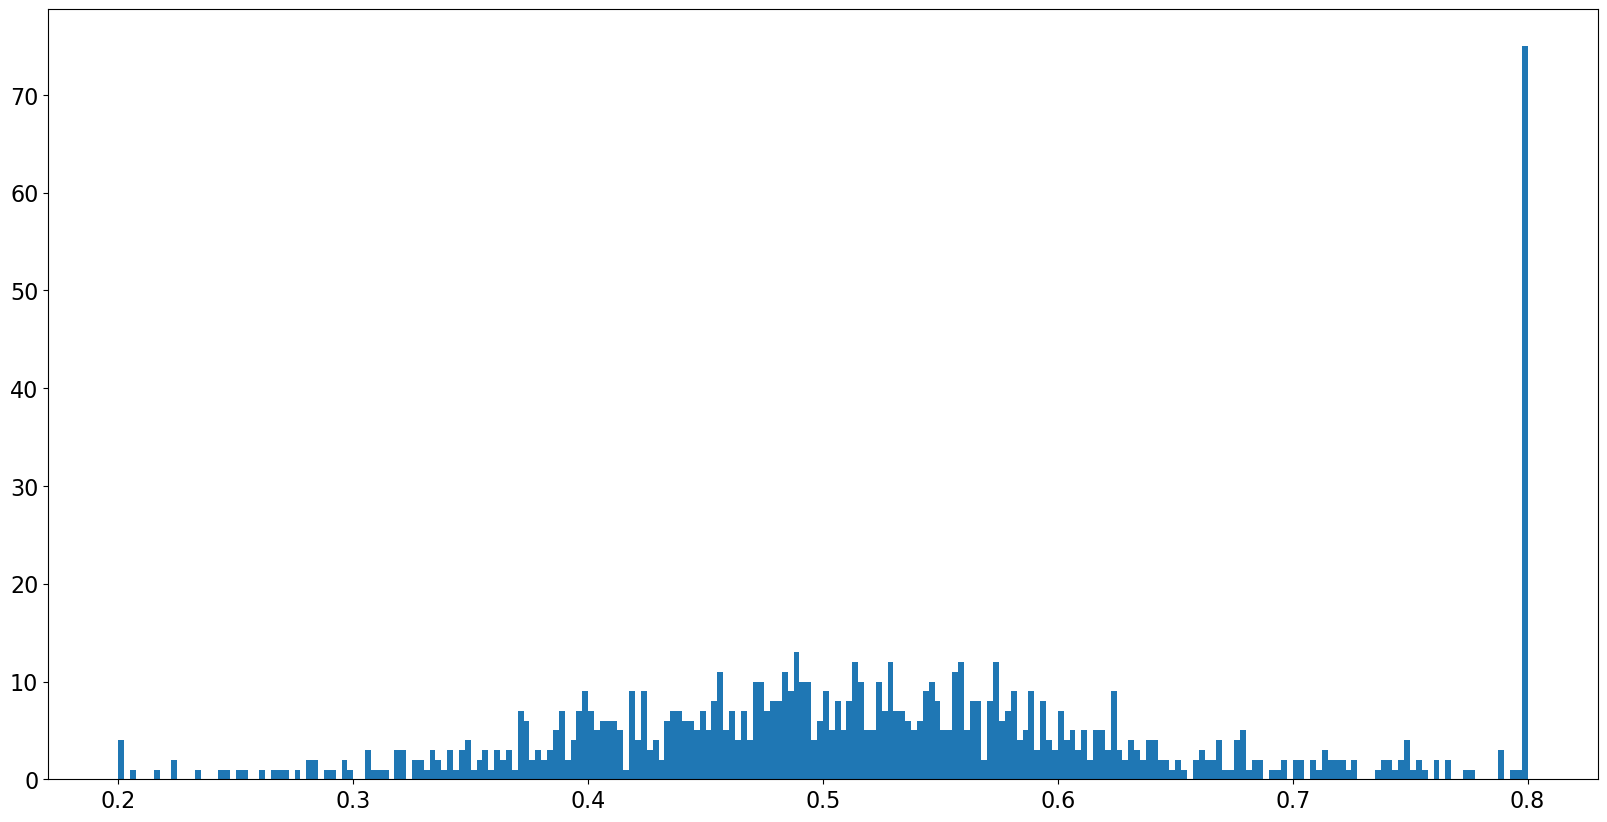

In [15]:
plt.figure(figsize=(20, 10))
counts_adj, bins_adj, _ = plt.hist(ks_adj.values(), bins=240)

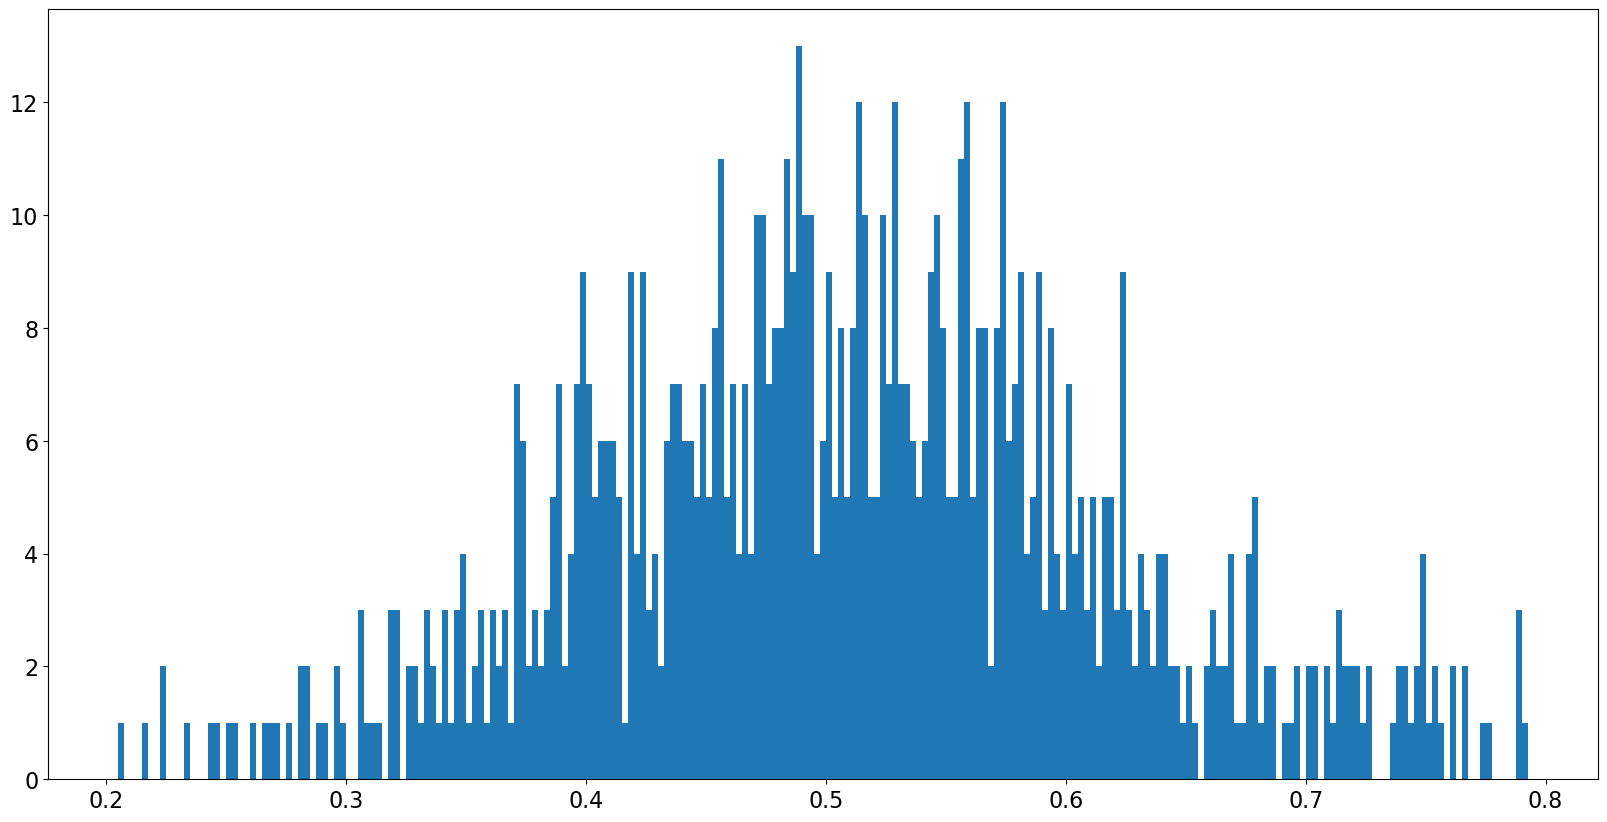

In [16]:
plt.figure(figsize=(20, 10))
counts_adj, bins_adj, _ = plt.hist([ x for x in ks_adj.values() if x > 0.20251 and x < 0.795 ], bins=235)

(0.5050190398142043, 0.003761077475545994, -0.10263454827485849)

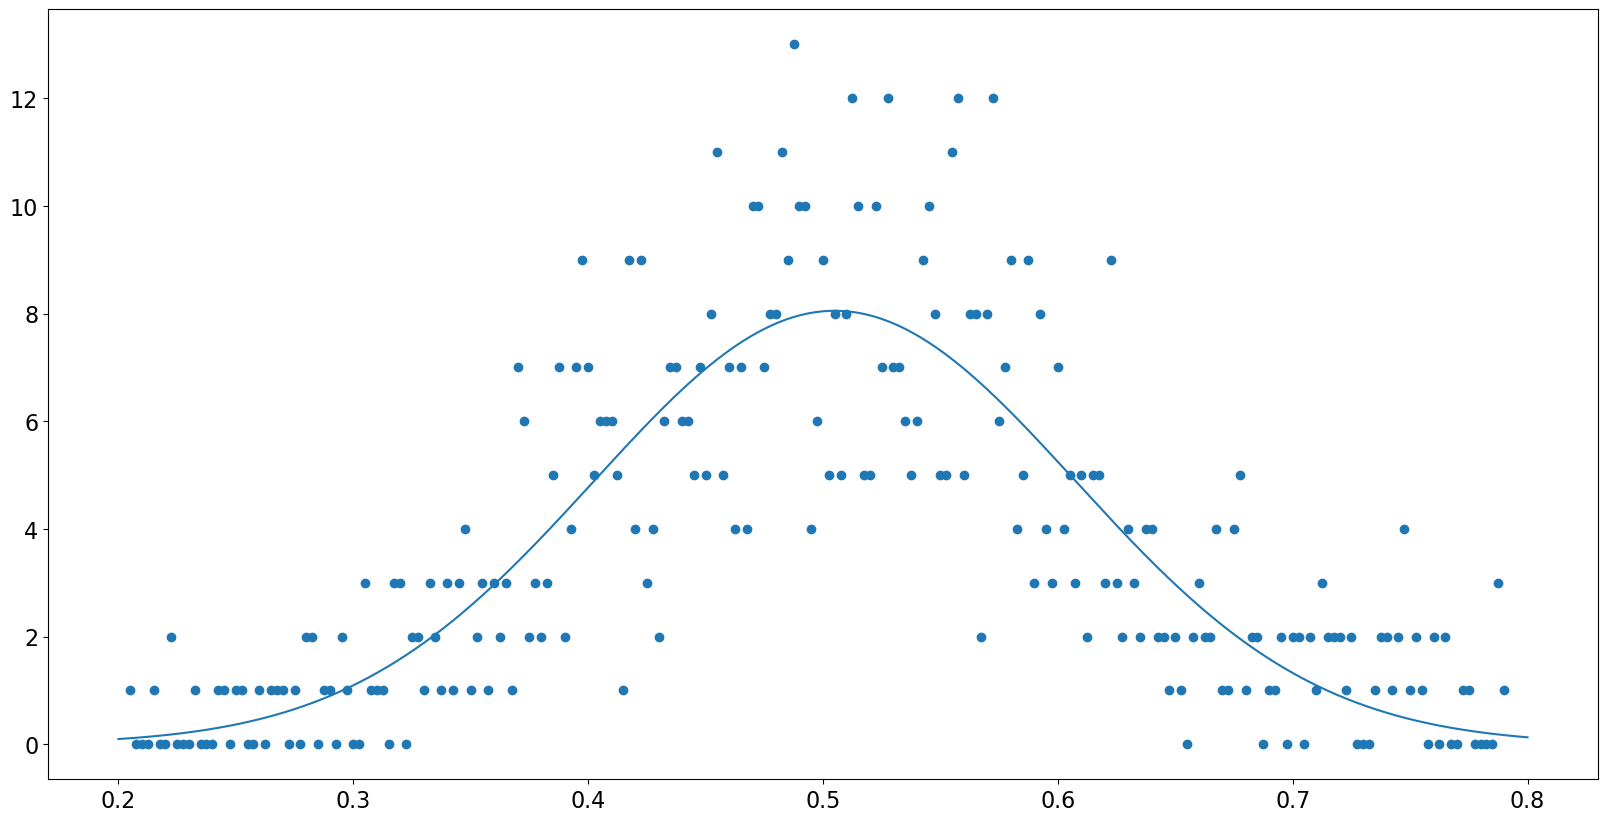

In [25]:
(A_fit, mu_fit, sigma_fit), var_matrix = curve_fit(gaussian, bins_adj[:-1], counts_adj, p0=[1, 0, 1])

xs = np.linspace(0.2, 0.8, 2000)
plt.figure(figsize=(20, 10))
plt.scatter(bins_adj[:-1], counts_adj)
plt.plot(xs, gaussian(xs, A_fit, mu_fit, sigma_fit))
mu_fit, var_matrix[1, 1]**.5, sigma_fit

In [17]:
bins_adj

array([0.205 , 0.2075, 0.21  , 0.2125, 0.215 , 0.2175, 0.22  , 0.2225,
       0.225 , 0.2275, 0.23  , 0.2325, 0.235 , 0.2375, 0.24  , 0.2425,
       0.245 , 0.2475, 0.25  , 0.2525, 0.255 , 0.2575, 0.26  , 0.2625,
       0.265 , 0.2675, 0.27  , 0.2725, 0.275 , 0.2775, 0.28  , 0.2825,
       0.285 , 0.2875, 0.29  , 0.2925, 0.295 , 0.2975, 0.3   , 0.3025,
       0.305 , 0.3075, 0.31  , 0.3125, 0.315 , 0.3175, 0.32  , 0.3225,
       0.325 , 0.3275, 0.33  , 0.3325, 0.335 , 0.3375, 0.34  , 0.3425,
       0.345 , 0.3475, 0.35  , 0.3525, 0.355 , 0.3575, 0.36  , 0.3625,
       0.365 , 0.3675, 0.37  , 0.3725, 0.375 , 0.3775, 0.38  , 0.3825,
       0.385 , 0.3875, 0.39  , 0.3925, 0.395 , 0.3975, 0.4   , 0.4025,
       0.405 , 0.4075, 0.41  , 0.4125, 0.415 , 0.4175, 0.42  , 0.4225,
       0.425 , 0.4275, 0.43  , 0.4325, 0.435 , 0.4375, 0.44  , 0.4425,
       0.445 , 0.4475, 0.45  , 0.4525, 0.455 , 0.4575, 0.46  , 0.4625,
       0.465 , 0.4675, 0.47  , 0.4725, 0.475 , 0.4775, 0.48  , 0.4825,
      

(array([68.,  8.,  6.,  6.,  1.,  5.,  7.,  1.,  2.,  1.,  3.,  1.,  0.,
         2.,  3.,  0.,  0.,  0.,  0.,  2.]),
 array([0.  , 0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.3 ,
        0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.51, 0.54, 0.57, 0.6 ]),
 <BarContainer object of 20 artists>)

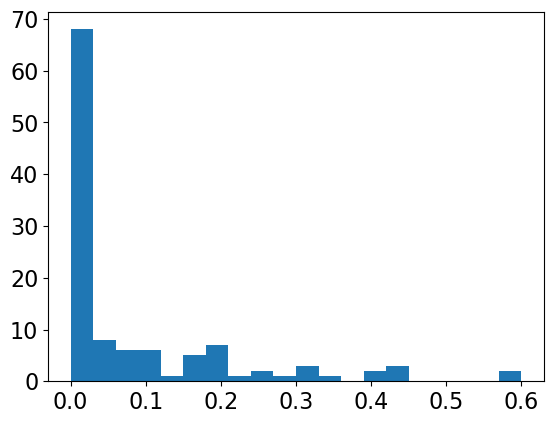

In [20]:
plt.hist(list({ gid: ks_hr[gid] - ks_adj[gid] for gid in ks_hr.keys() if np.abs(ks_hr[gid]) > 0.8 }.values()), bins=20)

(array([  1.,   0.,   1.,   1.,   0.,   2.,   5.,  11.,  11.,   7.,   7.,
          8.,  28.,  45., 129., 227., 205., 103.,  54.,  18.,  12.,  11.,
          5.,   6.,   6.,   4.,   3.,   2.,   1.,   1.]),
 array([0.50482386, 0.5368825 , 0.56894114, 0.60099978, 0.63305841,
        0.66511705, 0.69717569, 0.72923433, 0.76129296, 0.7933516 ,
        0.82541024, 0.85746888, 0.88952751, 0.92158615, 0.95364479,
        0.98570342, 1.01776206, 1.0498207 , 1.08187934, 1.11393797,
        1.14599661, 1.17805525, 1.21011389, 1.24217252, 1.27423116,
        1.3062898 , 1.33834844, 1.37040707, 1.40246571, 1.43452435,
        1.46658299]),
 <BarContainer object of 30 artists>)

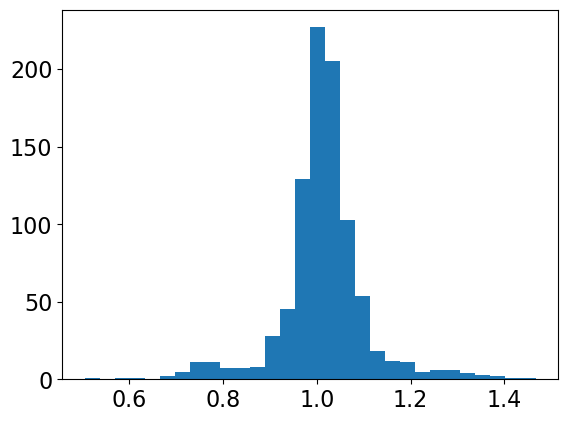

In [21]:
plt.hist([ x for x in qs_hr.values() if abs(x-1) < 0.5], bins=30)

In [22]:
ks_adj

{2542246912654630912: 0.6000000000000003,
 2689854321458250112: 0.3850000000000002,
 2500641186499915392: 0.3050000000000001,
 2686850112096922368: 0.5200000000000002,
 2541998766623853184: 0.4400000000000002,
 3263125837205951872: 0.4000000000000002,
 2686240123658296192: 0.5100000000000002,
 3256467332228378624: 0.3950000000000002,
 3267690425368759680: 0.8000000000000005,
 2693482636814536576: 0.25000000000000006,
 2506564938538312960: 0.35250000000000015,
 2677612324634274176: 0.45000000000000023,
 4227003188048533888: 0.8000000000000005,
 2679977683383222656: 0.22250000000000003,
 2535815796128392448: 0.2,
 5187724218963904256: 0.5450000000000004,
 2542478806528953600: 0.48250000000000026,
 2510512666318224640: 0.8000000000000005,
 2508625732566432512: 0.3175000000000001,
 2494655750140354048: 0.8000000000000005,
 2538007328960080640: 0.44500000000000023,
 2677157088165139584: 0.34750000000000014,
 3265446528294787968: 0.4950000000000003,
 2506627443197595648: 0.47000000000000025,

In [23]:
qs_adj

{2542246912654630912: 1.0006366312133717,
 2689854321458250112: 1.0000624017454887,
 2500641186499915392: 1.0004091666307466,
 2686850112096922368: 1.0003178624656646,
 2541998766623853184: 1.0000213477561226,
 3263125837205951872: 1.001734100187774,
 2686240123658296192: 0.9999677326903917,
 3256467332228378624: 0.9999687828431645,
 3267690425368759680: 1.0,
 2693482636814536576: 0.9999999999999999,
 2506564938538312960: 1.00523582353774,
 2677612324634274176: 1.0000375918476652,
 4227003188048533888: 1.0006398420826674,
 2679977683383222656: 1.0000490792952674,
 2535815796128392448: 1.0,
 5187724218963904256: 1.0000212733786946,
 2542478806528953600: 0.9999987816202215,
 2510512666318224640: 1.0,
 2508625732566432512: 1.0001260464014123,
 2494655750140354048: 1.0,
 2538007328960080640: 1.0000684985933768,
 2677157088165139584: 1.0000203940600276,
 3265446528294787968: 0.999988502418748,
 2506627443197595648: 1.0020177660026393,
 5187816126968839424: 0.9999678596294044,
 2641023940620